In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
import time

import shap

import feature_engine.selection as fsel
import feature_engine.outliers as fout

from sklearn import preprocessing as pre
from sklearn import metrics as met
from sklearn import model_selection as mod
from sklearn import ensemble as ens
from sklearn import pipeline as pip
from sklearn.base import BaseEstimator, TransformerMixin

import optuna
import xgboost as xgb

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_predictions(df, predicted, ticker, rnn_type = False, dropout = False, epochs = False, num_layers = False, activation_function = False, batch_size = False, elapsed_time = False, classification = False, line = False, open_ = False):
    
    """
    Visualizes the actual versus predicted prices using bar charts and line graphs.
    
    Parameters:
    - df (DataFrame): DataFrame containing the original data.
    - predicted (list): Predicted values from the model.
    - ticker (str): Stock ticker symbol.
    - epochs (int): Number of training epochs.
    - elapsed_time (float): Time taken to train the model.
    - batch_size (int): Size of each training batch.
    - activation_function (str): Activation function for LSTM layers.
    - num_layers (int): Number of LSTM layers.
    - classification (bool): If true, indicates this is a classification task. Default is False.
    
    Returns:
    - Displays a plot.
    
    Notes:
    -----
    
    plot_predictions(df = df,
                     predicted = predicted_price_NASDAQ_LSTM,
                     ticker = ticker,
                     rnn_type = rnn_type,
                     dropout = dropout,
                     epochs = epoch,
                     num_layers=num_layers,
                     activation_function=activation_function,
                     batch_size = batch_size,
                     elapsed_time = elapsed_time,
                     classification = False,
                     line = False)
    
    """
    target = "Close"
    if open_:
        target = "Open"
    
    fig, ax = plt.subplots(figsize=(12, 5))
    bar_df = df[-len(predicted):]
    if line:
        ax.plot(bar_df.index, bar_df[target], color='red', label=f'{ticker} {target}ing Price', linewidth=1, marker = "o")
    else:
        color = ["green" if close_price >= open_price else "red" for close_price, open_price in zip(bar_df[target], bar_df["Open"])]
        candlesticks = ax.bar(x=bar_df.index, height=np.abs(bar_df["Open"] - bar_df["Close"]), bottom=np.min((bar_df["Open"], bar_df["Close"]), axis=0), color=color, width=0.6, align='center')
        ax.vlines(x=bar_df.index, ymin=bar_df["Low"], ymax=bar_df["High"], color=color)
    
    if classification:
        actual = (df[target].rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])[-len(predicted):]).astype(int).values
        errors = [i for i, (a, c) in enumerate(zip(actual, predicted)) if a != c]
        for err in errors:
            ax.axvline(x=bar_df.index[err], color='blue', linestyle='dotted', label='Misclassification' if 'Misclassification' not in [l.get_label() for l in ax.lines] else "")
    else:
        if line:
            ax.plot(bar_df.index, predicted, color='blue', label=f'Predicted {ticker} {target}ing Price', linewidth=1, marker = "o")
        else:
            ax.plot(bar_df.index, predicted, color='blue', label=f'Predicted {ticker} {target}ing Price', linewidth=1)
    ax.legend()
    
    title = []
    if epochs:
        title.append(f'# of Epochs: {epochs}, ')
    if elapsed_time:
        title.append(f'Computation Time: {elapsed_time} Seconds, ')
    if batch_size:
        title.append(f'Batch Size: {batch_size}, ')
    if activation_function:
        title.append(f'Activation Function: {activation_function}, ')
    if num_layers:
        title.append(f'# of Layers: {num_layers}, Dropout: {dropout}, ')
    if rnn_type:
        title.append(f'RNN Type: {rnn_type}, ')

    if len(title) > 0:
        title = ''.join(title)[:-2]
    else:
        title = ticker

    ax.set_title(title , fontsize=10)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{ticker} {target}ing Price')
    plt.tight_layout()
    plt.show()
    
def add_technical_indicators(df_orig):
    
    """
    Add technical indicators to the given dataframe of stock data.

    Parameters:
    - df (pd.DataFrame): A dataframe containing stock data with columns like 'Open', 'Close', 'High', 'Low', etc.
                         The index should be the date.

    Returns:
    - pd.DataFrame: The dataframe enriched with technical indicators.

    Added Indicators:
    1. Day of the week as sine/cosine encoding
    2. Week of the year as sine/cosine encoding
    3. Percentage change of 'Close' and 'Open' from the previous day
    4. Winning indicator for 'Close' and 'Open' (1 if positive percentage change, otherwise 0)
    5. Simple Moving Averages (SMA) for 50 and 200 days
    6. Relative Strength Index (RSI) for 14 days
    7. Momentum (Close difference from 4 days ago)
    8. Stochastic Oscillator (%K and %D for 14 days)
    9. Exponential Moving Averages (EMA) for 12 and 26 days and Moving Average Convergence Divergence (MACD)
    10. Average True Range (ATR) for 14 days
    11. On-Balance Volume (OBV)
    12. Bollinger Bands (Middle, Upper, Lower Band for 20 days)

    Note:
    - The function assumes certain columns are present in the dataframe ('Open', 'Close', 'High', 'Low', etc.)
    - The function will remove the original 'High', 'Low', 'Dividends', and 'Stock Splits' columns from the dataframe.
    - The index will be set to only the date, removing any timestamp if present.
    """
    df = df_orig.copy()
    df["dayofweek"]  = pd.to_datetime(df.index).dayofweek    
    df["weekofyear"] = pd.to_datetime(df.index).isocalendar().week.astype("int64")
    df["pct_close"]  = df["Close"].pct_change() * 100
    df["pct_open_from_prev_close"]   = pd.Series((df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100
    df["pct_high_from_prev_close"] = ((df['High'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100
    df["pct_low_from_prev_close"] = ((df['Low'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100
    
    def cycle_encode(data, cols):
        for col in cols:
            data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
            data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        return data

    cols  = ["dayofweek","weekofyear"]
    df = cycle_encode(df,cols)
    df.drop(cols, axis=1, inplace=True)
     
    df['SMA_50'] = ((df['Close'] - df['Close'].rolling(window=50).mean()) / df['Close'].rolling(window=50).mean()) * 100
    df['SMA_100'] = ((df['Close'] - df['Close'].rolling(window=100).mean()) / df['Close'].rolling(window=100).mean()) * 100
    df['SMA_200'] = ((df['Close'] - df['Close'].rolling(window=200).mean()) / df['Close'].rolling(window=200).mean()) * 100

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df['Momentum'] = df['Close'] - df['Close'].shift(4)

    low_min  = df['Low'].rolling(window=14).min()
    high_max = df['High'].rolling(window=14).max()
    df['%K'] = (df['Close'] - low_min) * 100 / (high_max - low_min)
    df['%D'] = df['%K'].rolling(window=3).mean()
    
    df['EMA_8'] = ((df['Close'] - df['Close'].ewm(span=8).mean()) / df['Close'].ewm(span=8).mean()) * 100
    df['EMA_12'] = ((df['Close'] - df['Close'].ewm(span=12).mean()) / df['Close'].ewm(span=12).mean()) * 100
    df['EMA_26'] = ((df['Close'] - df['Close'].ewm(span=26).mean()) / df['Close'].ewm(span=26).mean()) * 100
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()

    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(np.abs(df['High'] - df['Close'].shift(1)), 
                                     np.abs(df['Low'] - df['Close'].shift(1))))
    df['ATR'] = df['TR'].rolling(window=14).mean()

    df['OBV'] = np.where(df['Close'] > df['Close'].shift(1), df['Volume'], 
                        np.where(df['Close'] < df['Close'].shift(1), -df['Volume'], 0)).cumsum()

    df['Middle_Band'] = ((df['Close'] - df['Close'].rolling(window=20).mean()) / df['Close'].rolling(window=20).mean()) * 100
    df['Upper_Band'] = ((df['Close'] - (df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std())) / (df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std())) * 100
    df['Lower_Band'] = ((df['Close'] - (df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std())) / (df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std())) * 100
    df['vol_pct_change'] = df["Volume"].pct_change()
    
    df.drop(["High", "Low", "Dividends", "Stock Splits"], axis = 1, inplace = True)
    
    df = df[df.Volume != 0]
    df.dropna(inplace = True)

    return df

def get_indices_pct_change(indices):
    
    """
    Fetches historical closing prices for the given stock indices and merges them into a single DataFrame.
    
    Parameters:
    indices (list): A list of stock indices for which to fetch historical data.
    
    Returns:
    DataFrame: A DataFrame where each column represents the closing prices for one index, and rows are indexed by date.
    """
    
    data = {index: yf.Ticker(index).history(period="max") for index in indices}

    sorted_indices = sorted(data.keys(), key=lambda x: len(data[x]), reverse=True)

    base_index = sorted_indices[0]
    df_indices = data[base_index][["Close"]]
    df_indices.columns = [base_index]
    df_indices.index = df_indices.index.date

    for index in sorted_indices[1:]:
        df_indice = data[index][["Close"]]
        df_indice.index = df_indice.index.date
        df_indice.columns = [index]
        df_indices = pd.merge(df_indices, df_indice, left_index=True, right_index=True, how='outer')
    return df_indices

class LogTransformer(BaseEstimator, TransformerMixin):
    
    """
    Transforms specified columns of a DataFrame using the natural logarithm function.
    
    Parameters:
    columns (list): A list of column names that will be transformed.
    """
    
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        
        """
        Fit method for LogTransformer, does nothing as this transformation doesn't require fitting.
        
        Parameters:
        X (DataFrame): The input data. Not used.
        y (array-like): The target data. Not used.
        
        Returns:
        self: Returns the instance itself.
        """
        
        return self

    def transform(self, X):
        
        """
        Applies the natural logarithm transformation to specified columns of the DataFrame.
        
        Parameters:
        X (DataFrame): The input data to be transformed.
        
        Returns:
        DataFrame: A DataFrame with transformed columns.
        """
        
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = np.log1p(X_copy[col])
        return X_copy

In [3]:
nasdaq = yf.Ticker("^IXIC")
df_NASDAQ = nasdaq.history(period="max")
df_NASDAQ.index = df_NASDAQ.index.date
df_NASDAQ.tail()

Open          High           Low         Close  \
2023-08-28  13695.360352  13735.980469  13626.639648  13705.129883   
2023-08-29  13687.230469  13959.809570  13677.059570  13943.759766   
2023-08-30  13961.769531  14050.820312  13924.200195  14019.309570   
2023-08-31  14041.540039  14114.669922  14010.480469  14034.969727   
2023-09-01  14130.000000  14149.622070  13985.593750  13989.094727   

                Volume  Dividends  Stock Splits  
2023-08-28  3666680000        0.0           0.0  
2023-08-29  4748180000        0.0           0.0  
2023-08-30  4364600000        0.0           0.0  
2023-08-31  4568610000        0.0           0.0  
2023-09-01  1747874000        0.0           0.0

In [4]:
df_NASDAQ_technical = add_technical_indicators(df_NASDAQ)
df_NASDAQ_technical = df_NASDAQ_technical[df_NASDAQ_technical.Volume != 0]
df_NASDAQ_technical["pct_close"] = df_NASDAQ_technical["pct_close"].shift(-1)
df_NASDAQ_technical.dropna(inplace=True)

df_NASDAQ_technical.head()

Open       Close    Volume  pct_close  \
1984-10-11  244.199997  244.699997  62860000   0.612996   
1984-10-12  245.500000  246.199997  58860000   0.609261   
1984-10-15  246.800003  247.699997  61820000  -0.161483   
1984-10-16  247.800003  247.300003  57440000  -0.080872   
1984-10-17  247.100006  247.100006  64670000   1.092674   

            pct_open_from_prev_close  pct_high_from_prev_close  \
1984-10-11                  0.374041                  0.579557   
1984-10-12                  0.326932                  0.612996   
1984-10-15                  0.243707                  0.609261   
1984-10-16                  0.040374                  0.080742   
1984-10-17                 -0.080872                 -0.080872   

            pct_low_from_prev_close  dayofweek_sin  dayofweek_cos  \
1984-10-11                 0.374041  -1.000000e+00  -1.836970e-16   
1984-10-12                 0.326932  -2.449294e-16   1.000000e+00   
1984-10-15                 0.243707   0.000000e+00   1.000000e+00   
1984-10-16                -0.242225   1.000000e+00   6.123234e-17   
1984-10-17                -0.202184   1.224647e-16  -1.000000e+00   

            weekofyear_sin  ...    EMA_26      MACD  Signal_Line        TR  \
1984-10-11       -0.989040  ... -1.334817  0.712337     0.415138  1.410004   
1984-10-12       -0.989040  ... -0.676296  0.665041     0.465119  1.500000   
1984-10-15       -0.964636  ... -0.065888  0.571370     0.486369  1.500000   
1984-10-16       -0.964636  ... -0.210466  0.500698     0.489235  0.799988   
1984-10-17       -0.964636  ... -0.269658  0.446553     0.480698  0.500000   

                 ATR        OBV  Middle_Band  Upper_Band  Lower_Band  \
1984-10-11  0.904287   62860000    -1.749400   -4.852445    1.562868   
1984-10-12  0.877145  121720000    -0.960228   -3.898087    2.162917   
1984-10-15  0.927859  183540000    -0.202456   -2.900124    2.649391   
1984-10-16  0.969286  126100000    -0.229152   -2.717557    2.389897   
1984-10-17  1.000715   61430000    -0.190850   -2.500313    2.230674   

            vol_pct_change  
1984-10-11             inf  
1984-10-12       -0.063633  
1984-10-15        0.050289  
1984-10-16       -0.070851  
1984-10-17        0.125870  

[5 rows x 30 columns]

In [5]:
df_NASDAQ_technical.tail()

Open         Close      Volume  pct_close  \
2023-08-25  13514.370117  13590.650391  3970060000   0.842340   
2023-08-28  13695.360352  13705.129883  3666680000   1.741172   
2023-08-29  13687.230469  13943.759766  4748180000   0.541818   
2023-08-30  13961.769531  14019.309570  4364600000   0.111704   
2023-08-31  14041.540039  14034.969727  4568610000  -0.326862   

            pct_open_from_prev_close  pct_high_from_prev_close  \
2023-08-25                  0.374335                  1.258546   
2023-08-28                  0.770456                  1.069339   
2023-08-29                 -0.130604                  1.858280   
2023-08-30                  0.129160                  0.767803   
2023-08-31                  0.158570                  0.680207   

            pct_low_from_prev_close  dayofweek_sin  dayofweek_cos  \
2023-08-25                -0.650775  -2.449294e-16   1.000000e+00   
2023-08-28                 0.264809   0.000000e+00   1.000000e+00   
2023-08-29                -0.204816   1.000000e+00   6.123234e-17   
2023-08-30                -0.140275   1.224647e-16  -1.000000e+00   
2023-08-31                -0.062978  -1.000000e+00  -1.836970e-16   

            weekofyear_sin  ...    EMA_26      MACD  Signal_Line          TR  \
2023-08-25       -0.776524  ... -0.799675  0.736772     0.575493  257.070312   
2023-08-28       -0.845596  ...  0.033266  0.625020     0.585398  145.330078   
2023-08-29       -0.845596  ...  1.641377  0.391094     0.546537  282.750000   
2023-08-30       -0.845596  ...  2.026421  0.152475     0.467725  126.620117   
2023-08-31       -0.845596  ...  1.978704 -0.045265     0.365127  104.189453   

                   ATR            OBV  Middle_Band  Upper_Band  Lower_Band  \
2023-08-25  213.892229  1179112690000    -1.064198   -5.034996    3.253156   
2023-08-28  208.197196  1182779370000     0.002458   -3.501744    3.770750   
2023-08-29  214.097168  1187527550000     1.870093   -1.256767    5.201462   
2023-08-30  204.523577  1191892150000     2.404888   -0.785609    5.807401   
2023-08-31  202.822126  1196460760000     2.491111   -0.777429    5.982327   

            vol_pct_change  
2023-08-25       -0.094383  
2023-08-28       -0.076417  
2023-08-29        0.294953  
2023-08-30       -0.080785  
2023-08-31        0.046742  

[5 rows x 30 columns]

In [6]:
df_NASDAQ_technical = df_NASDAQ_technical.iloc[1:,:]
df_NASDAQ_technical.describe()

Open         Close        Volume    pct_close  \
count   9800.000000   9800.000000  9.800000e+03  9800.000000   
mean    3275.508008   3275.433723  1.569746e+09     0.051079   
std     3523.259558   3523.476478  1.361432e+09     1.402279   
min      238.000000    238.100006  3.884000e+07   -12.321331   
25%      760.517517    761.419998  3.012575e+08    -0.511756   
50%     2103.690063   2102.589966  1.650640e+09     0.109639   
75%     4145.814941   4148.477417  2.070972e+09     0.692242   
max    16120.919922  16057.440430  1.162119e+10    14.173196   

       pct_open_from_prev_close  pct_high_from_prev_close  \
count               9800.000000               9800.000000   
mean                   0.041243                  0.684871   
std                    0.725905                  0.997146   
min                   -7.531389                 -5.748401   
25%                   -0.216338                  0.146177   
50%                    0.065964                  0.499137   
75%                    0.335758                  1.000226   
max                    5.673448                 14.231668   

       pct_low_from_prev_close  dayofweek_sin  dayofweek_cos  weekofyear_sin  \
count              9800.000000   9.800000e+03   9.800000e+03    9.800000e+03   
mean                 -0.676078   3.571429e-03   1.837755e-01   -2.780279e-04   
std                   1.139816   6.373799e-01   7.483710e-01    7.148951e-01   
min                 -13.603541  -1.000000e+00  -1.000000e+00   -9.995608e-01   
25%                  -1.052144  -2.449294e-16  -1.836970e-16   -7.378333e-01   
50%                  -0.404614   0.000000e+00   6.123234e-17   -2.449294e-16   
75%                  -0.026025   1.224647e-16   1.000000e+00    7.378333e-01   
max                   4.850526   1.000000e+00   1.000000e+00    9.995608e-01   

       ...       EMA_26         MACD  Signal_Line           TR          ATR  \
count  ...  9800.000000  9800.000000  9800.000000  9800.000000  9800.000000   
mean   ...     0.507592    -0.286097    -0.286077    55.063466    54.931319   
std    ...     3.386565     1.590214     1.509110    81.696343    73.594620   
min    ...   -24.996679    -5.393506    -5.137689     0.300003     0.877145   
25%    ...    -0.979624    -1.227417    -1.179938     7.200012     6.932317   
50%    ...     0.950851    -0.494814    -0.480794    29.074951    31.876413   
75%    ...     2.496371     0.432944     0.393474    60.770142    59.475340   
max    ...    12.034275     9.292506     7.746909   992.020020   564.737898   

                OBV  Middle_Band   Upper_Band   Lower_Band  vol_pct_change  
count  9.800000e+03  9800.000000  9800.000000  9800.000000     9800.000000  
mean   3.700264e+11     0.416989    -3.591194     4.950755        0.017207  
std    3.531878e+11     3.377424     4.311850     4.400362        0.203674  
min   -5.377000e+08   -26.551175   -43.007036   -10.533841       -0.827369  
25%    6.347867e+10    -1.136797    -4.660673     2.005570       -0.081685  
50%    2.280904e+11     0.814622    -2.151191     4.031720        0.002279  
75%    6.171364e+11     2.362647    -0.962804     6.604211        0.093857  
max    1.286922e+12    16.739793     2.492583    35.954057        6.546584  

[8 rows x 30 columns]

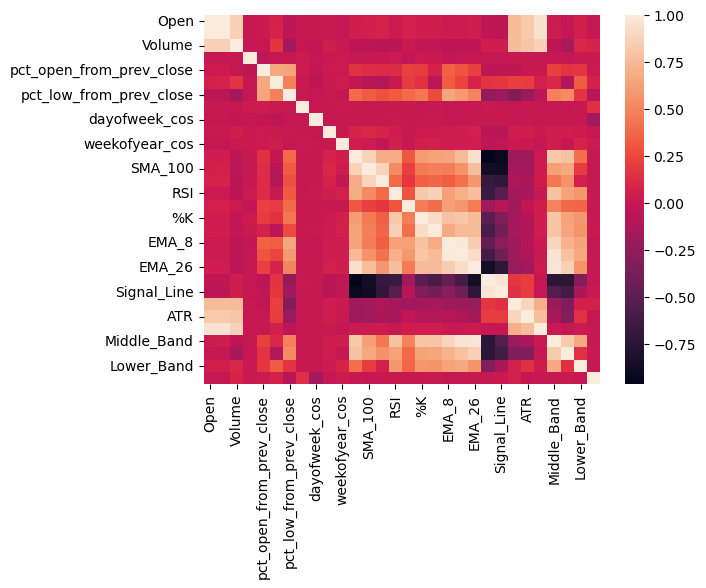

In [7]:
sns.heatmap(df_NASDAQ_technical.corr())
plt.show()

In [8]:
df_NASDAQ_technical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9800 entries, 1984-10-12 to 2023-08-31
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Open                      9800 non-null   float64
 1   Close                     9800 non-null   float64
 2   Volume                    9800 non-null   int64  
 3   pct_close                 9800 non-null   float64
 4   pct_open_from_prev_close  9800 non-null   float64
 5   pct_high_from_prev_close  9800 non-null   float64
 6   pct_low_from_prev_close   9800 non-null   float64
 7   dayofweek_sin             9800 non-null   float64
 8   dayofweek_cos             9800 non-null   float64
 9   weekofyear_sin            9800 non-null   float64
 10  weekofyear_cos            9800 non-null   float64
 11  SMA_50                    9800 non-null   float64
 12  SMA_100                   9800 non-null   float64
 13  SMA_200                   9800 non-null   float64
 14

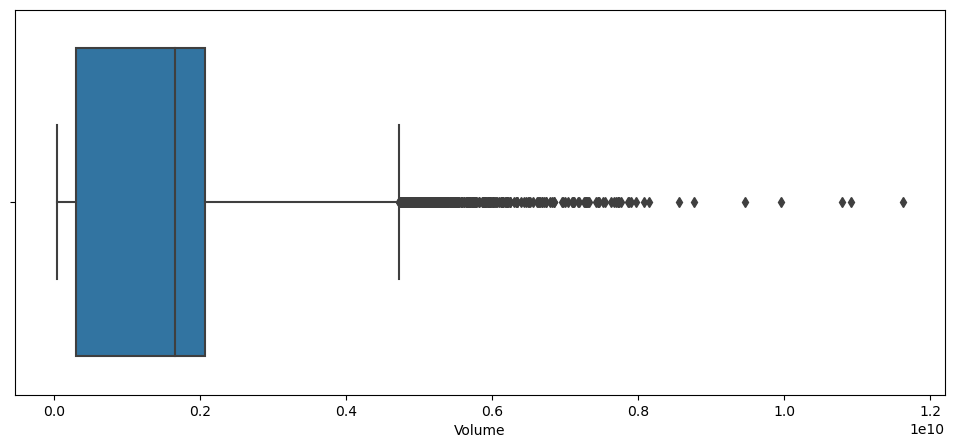

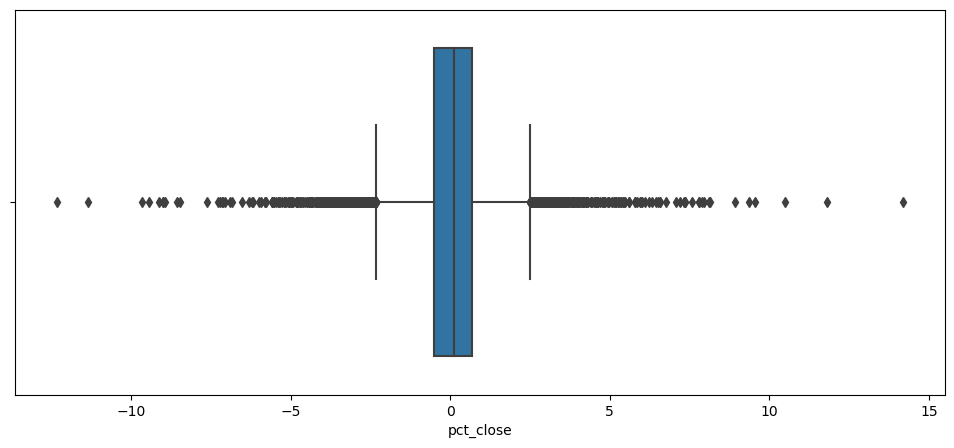

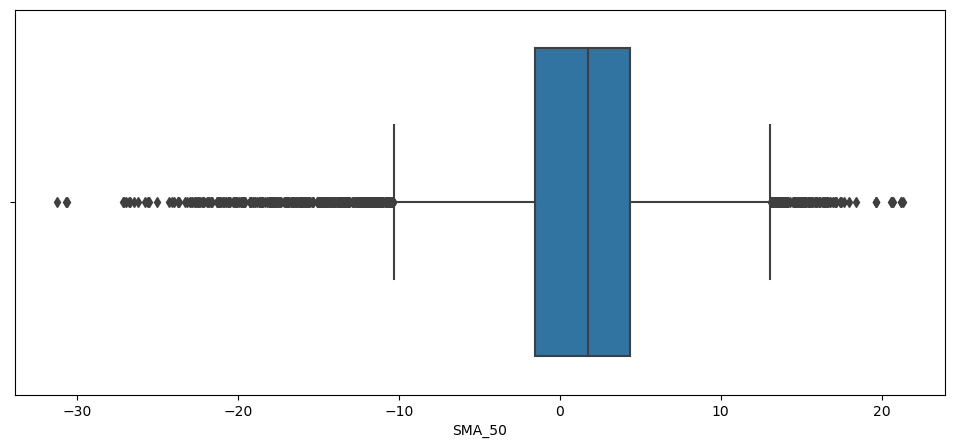

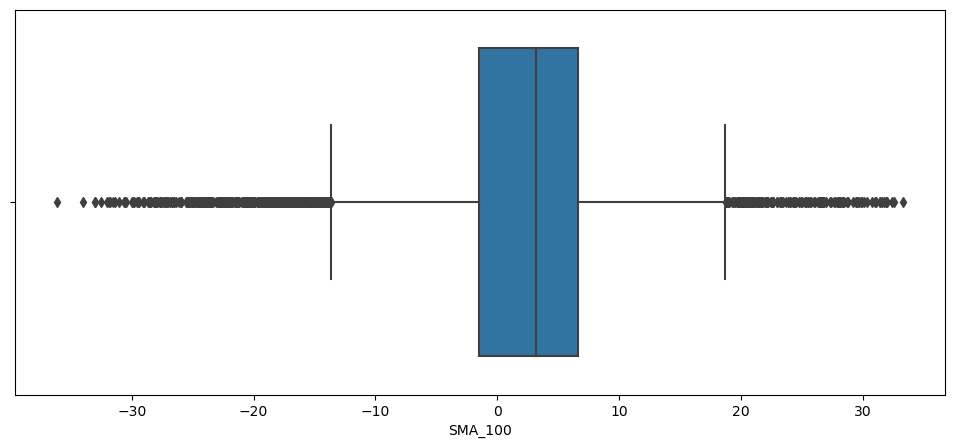

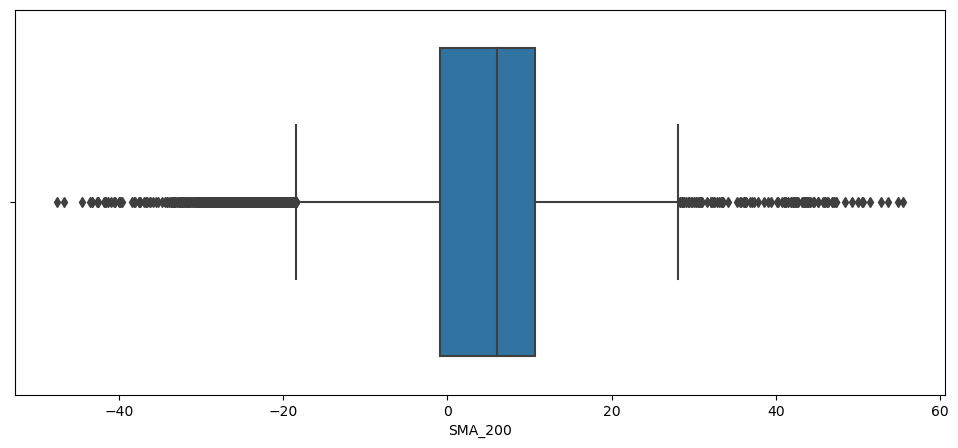

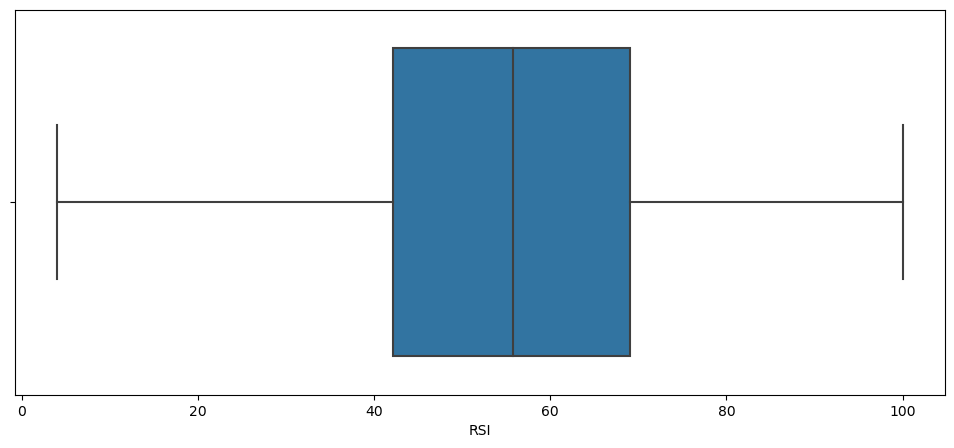

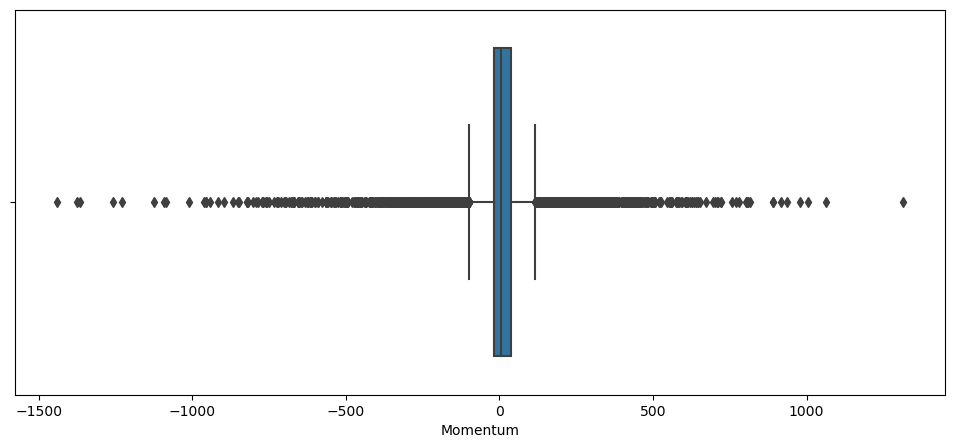

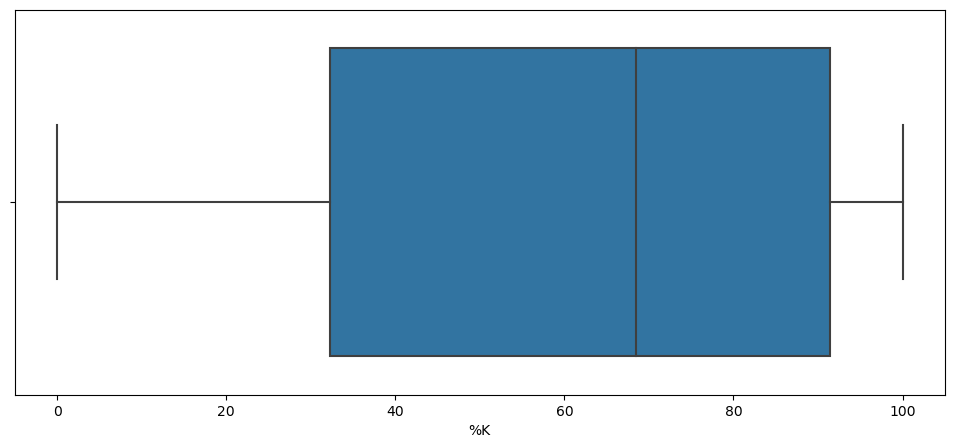

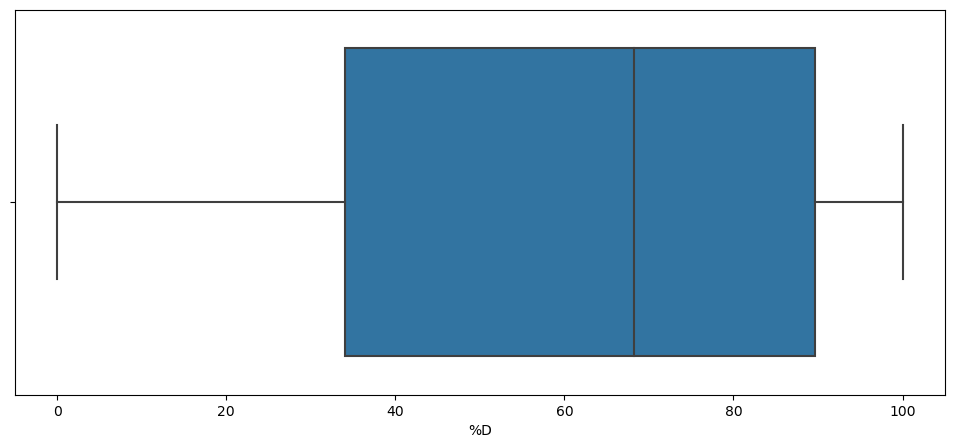

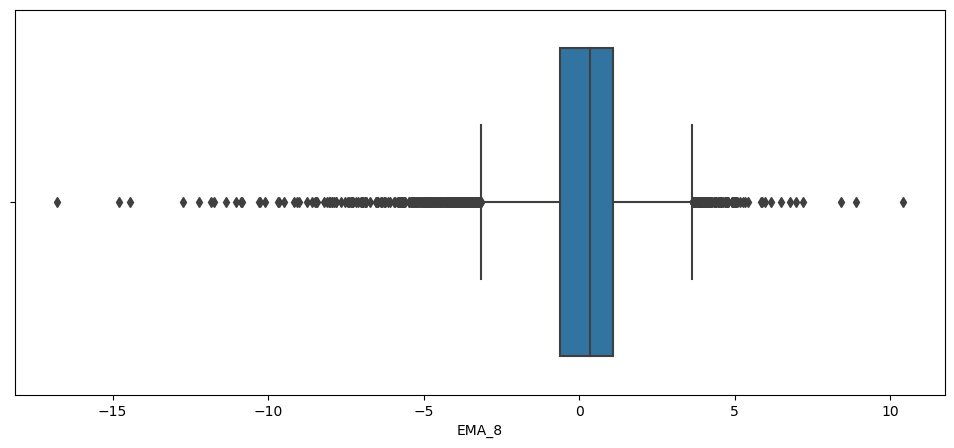

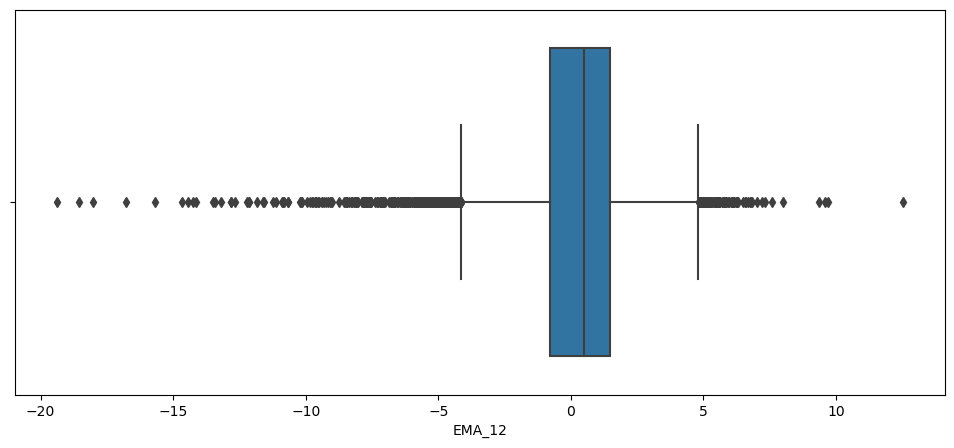

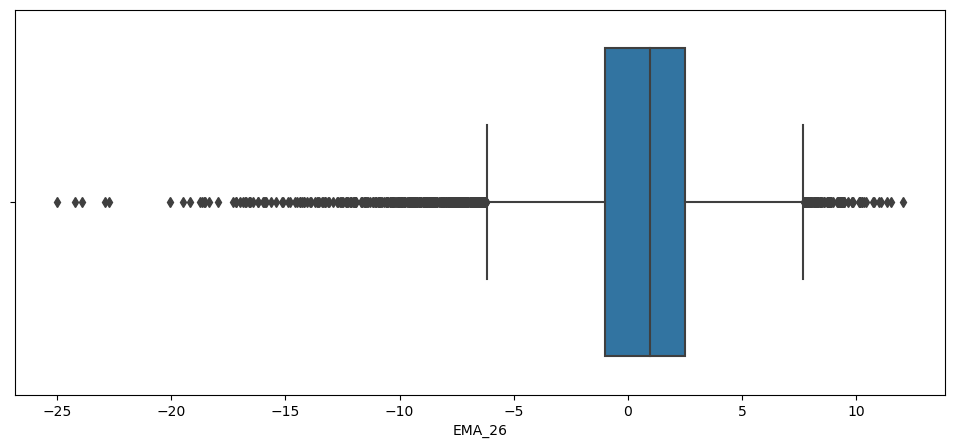

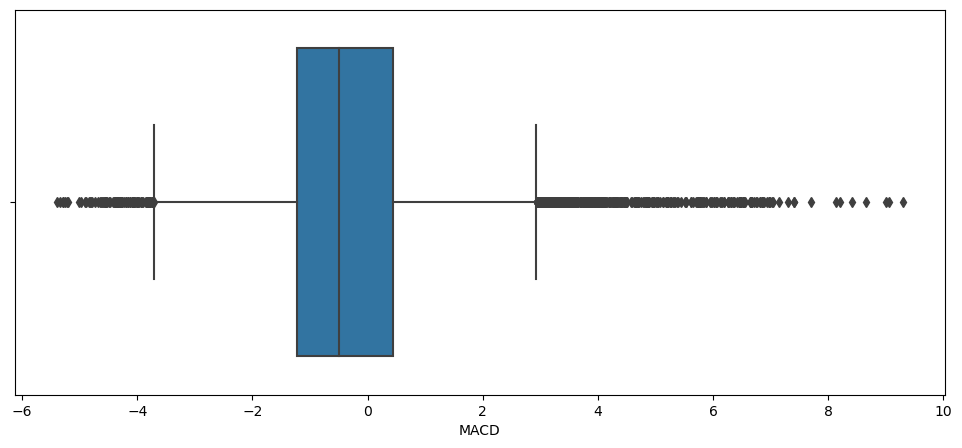

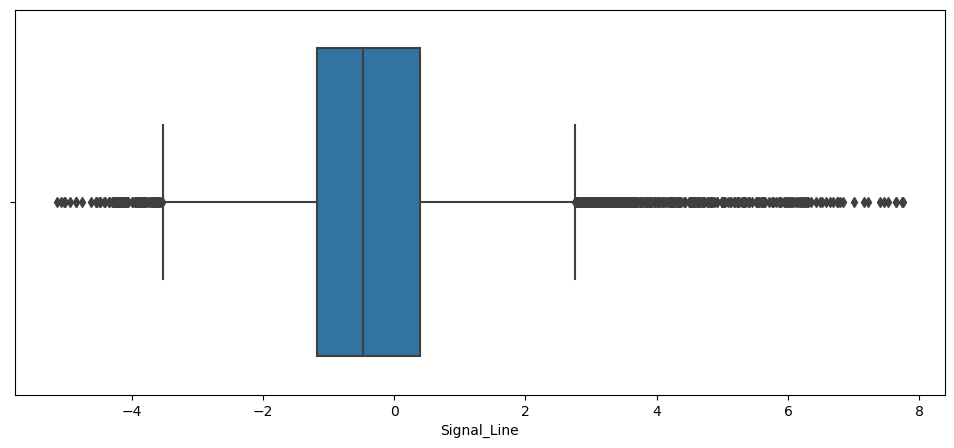

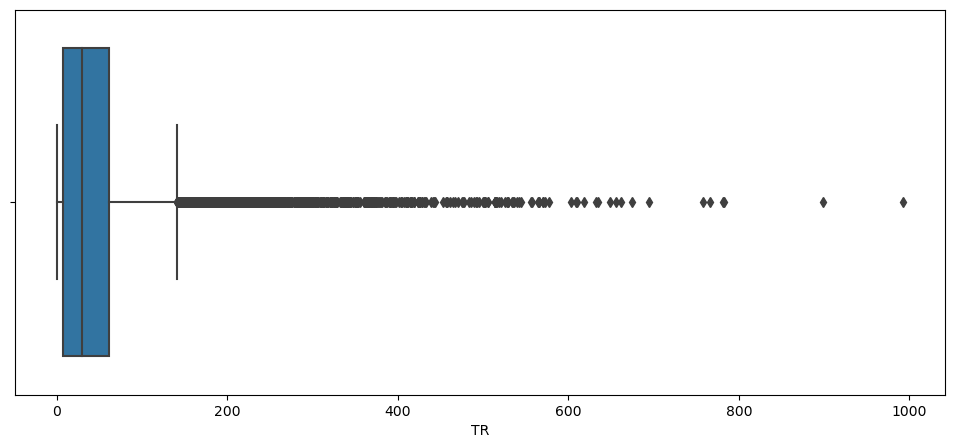

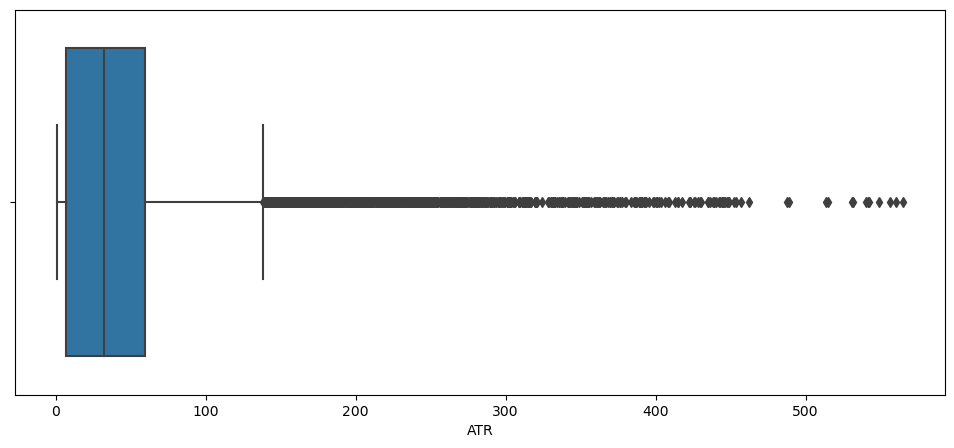

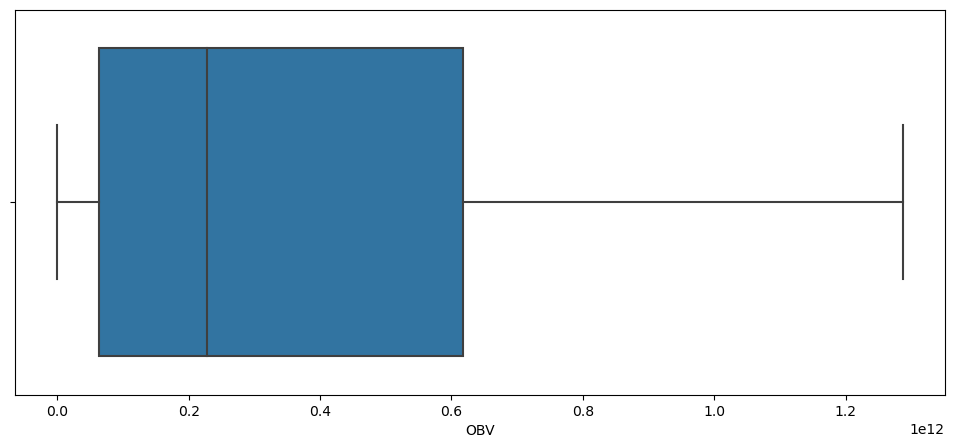

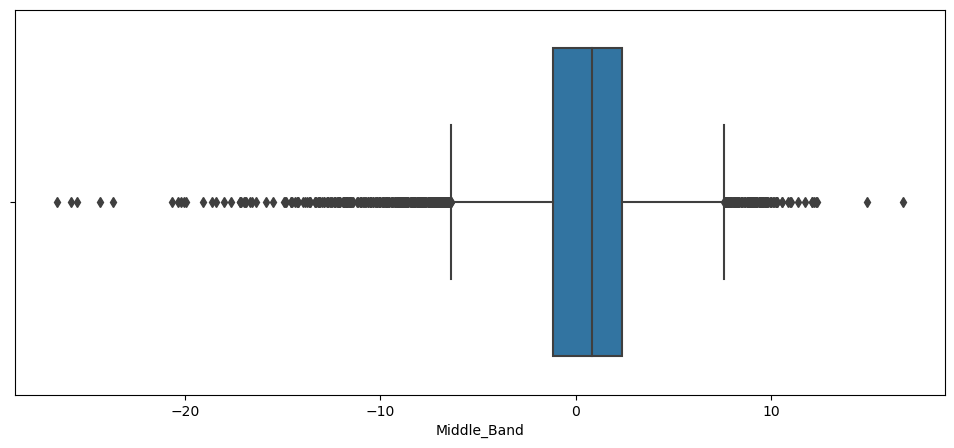

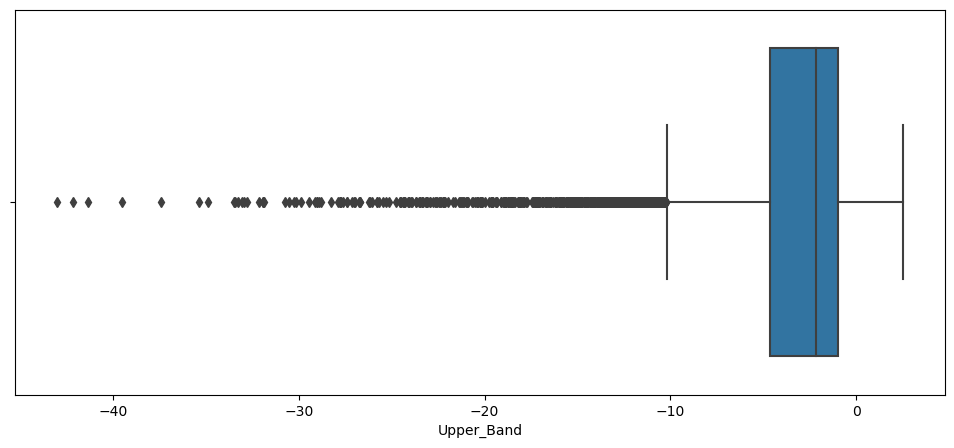

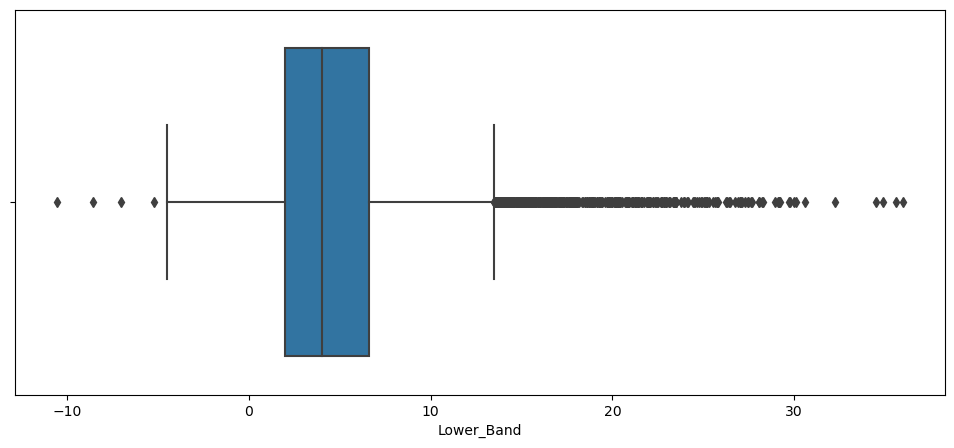

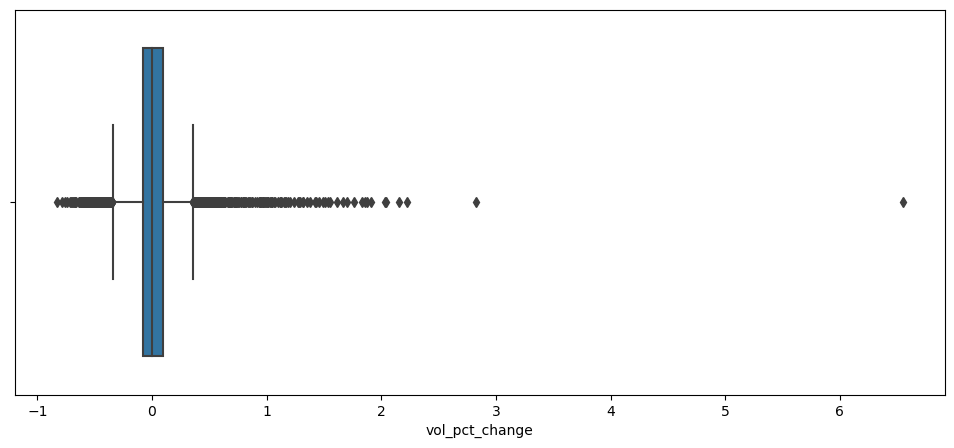

In [9]:
dis_cols = ['Volume', 'pct_close', 'SMA_50', 'SMA_100', 'SMA_200', 'RSI', 'Momentum', '%K', '%D', 'EMA_8', 'EMA_12', 'EMA_26','MACD', 'Signal_Line', 'TR', 'ATR', 'OBV', 'Middle_Band', 'Upper_Band','Lower_Band', 'vol_pct_change']

for i in dis_cols:
    plt.figure(figsize = (12,5))
    sns.boxplot(data = df_NASDAQ_technical,
                x = i,
                orient = "h")
    plt.show()

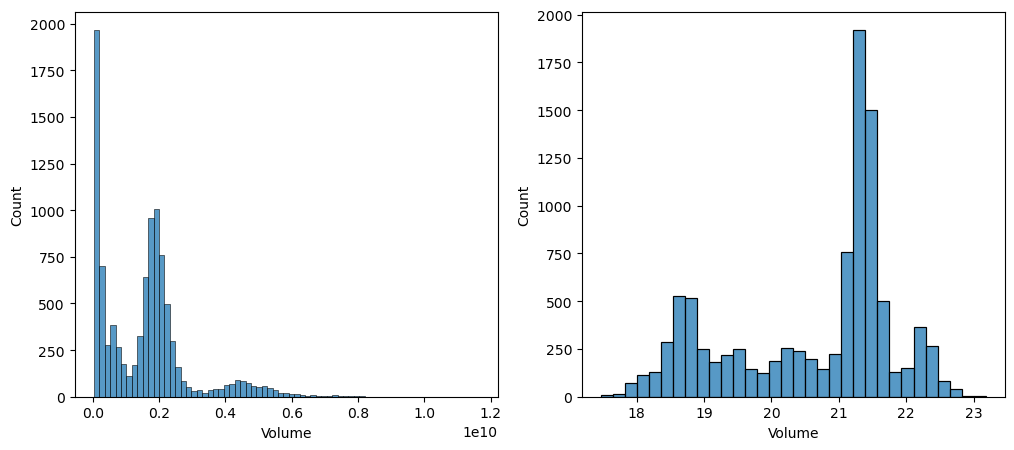

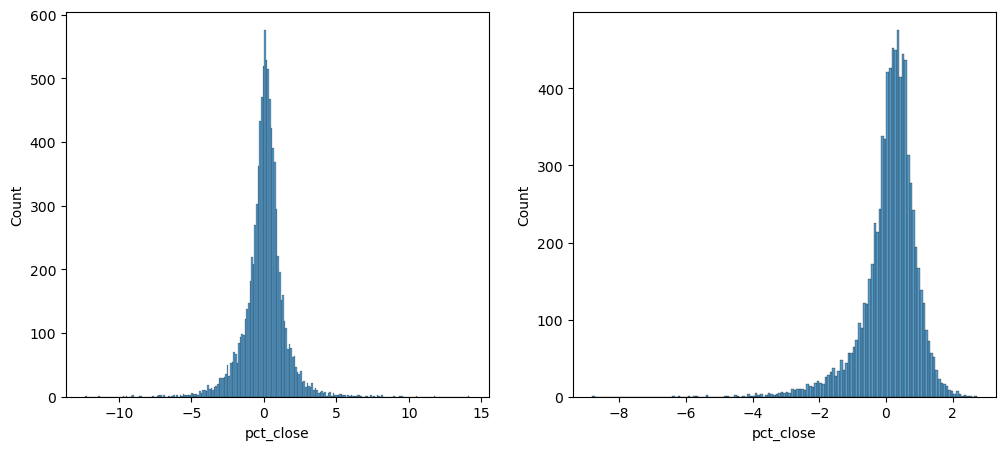

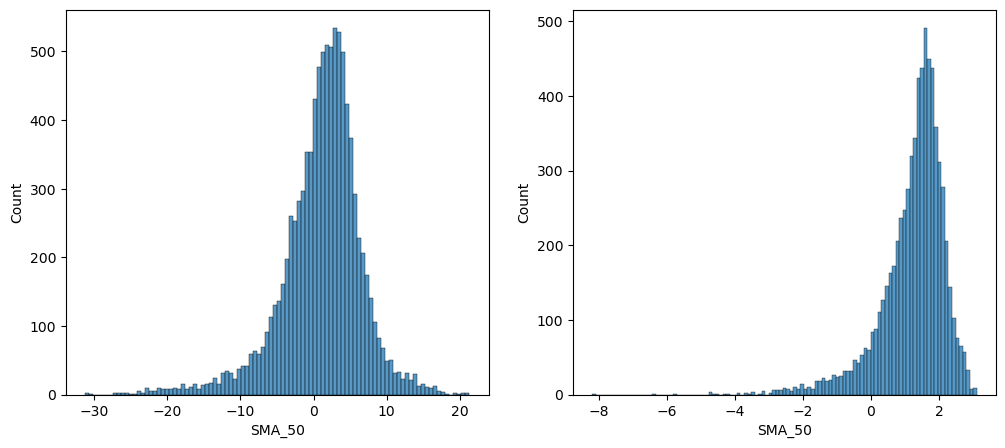

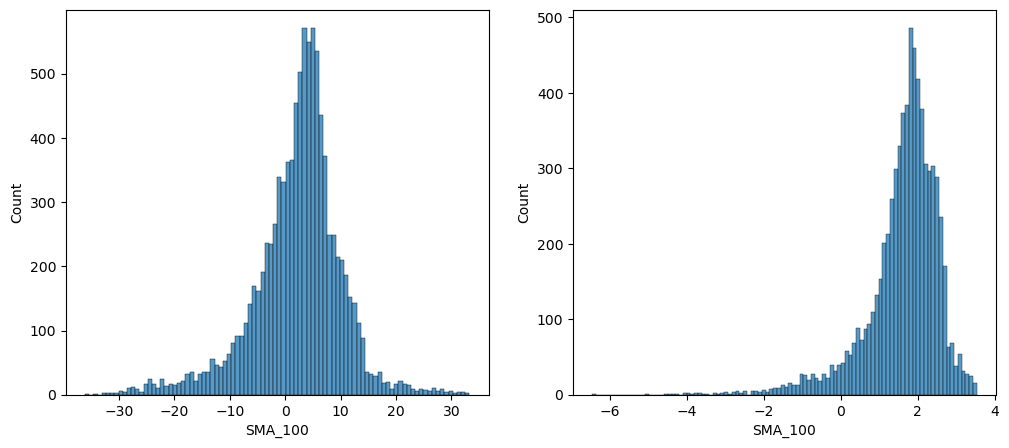

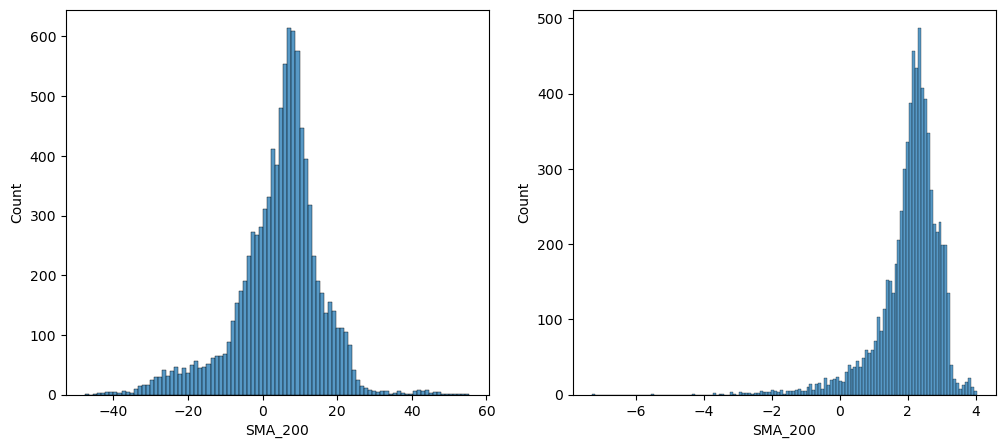

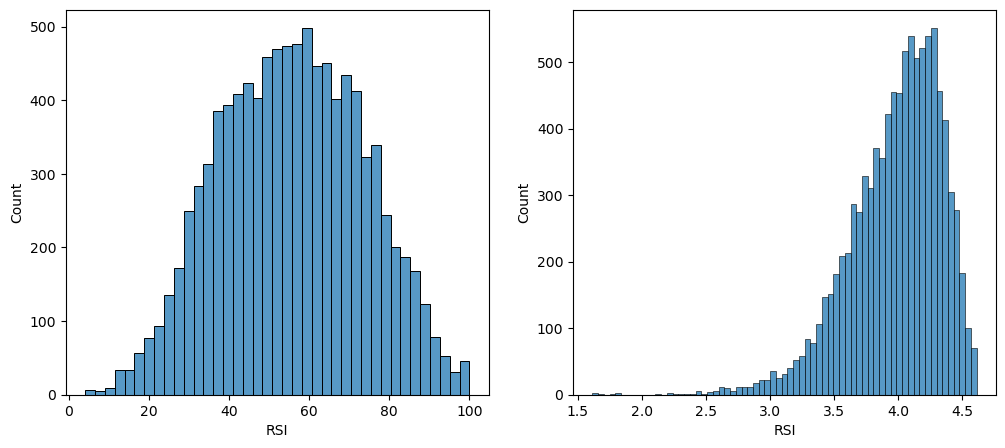

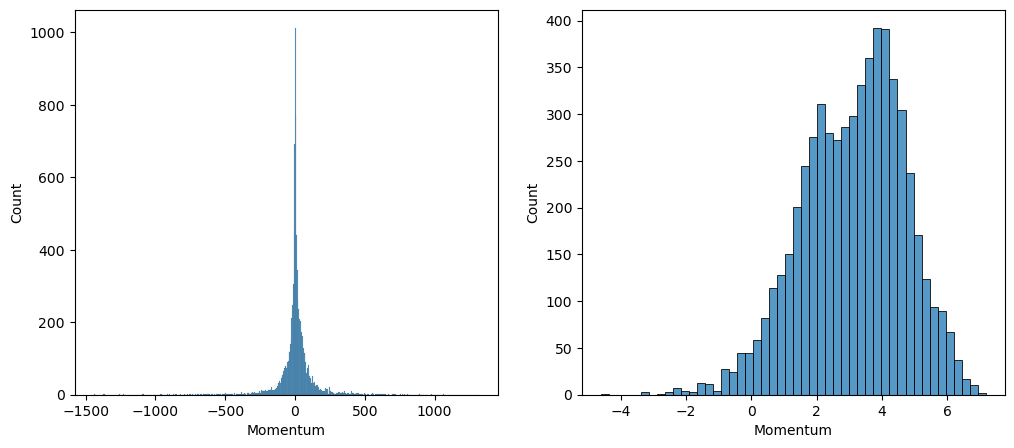

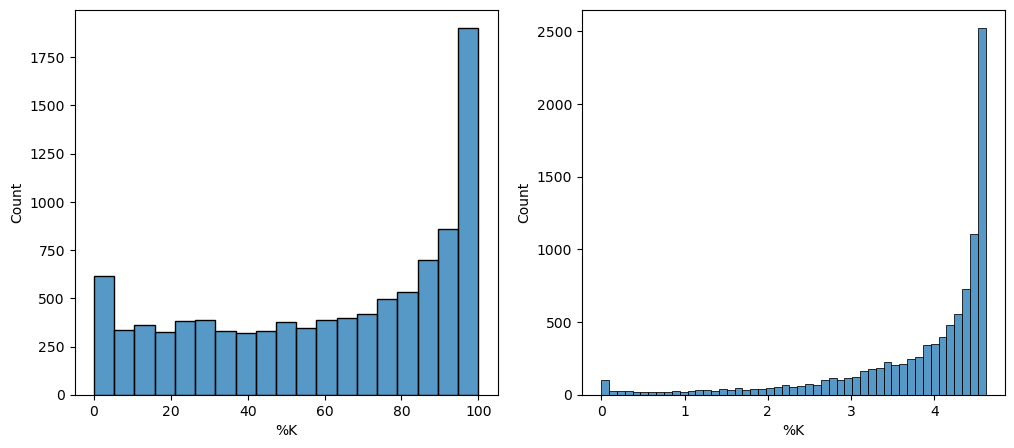

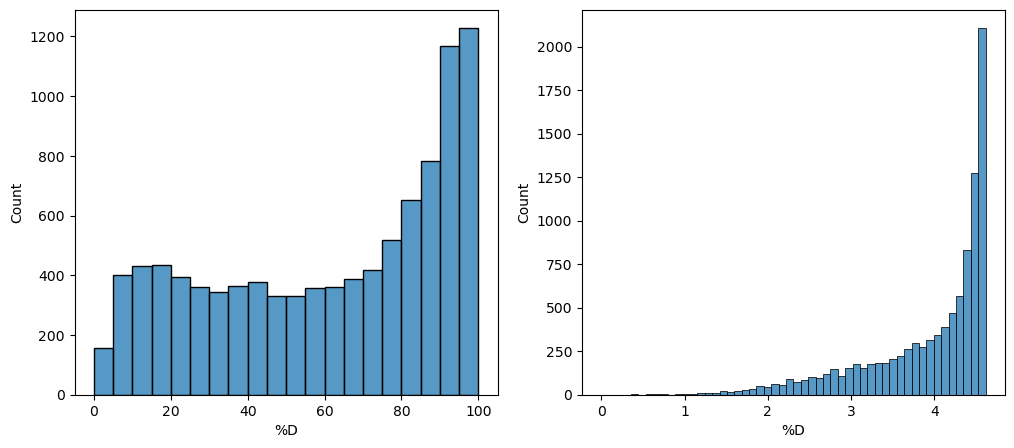

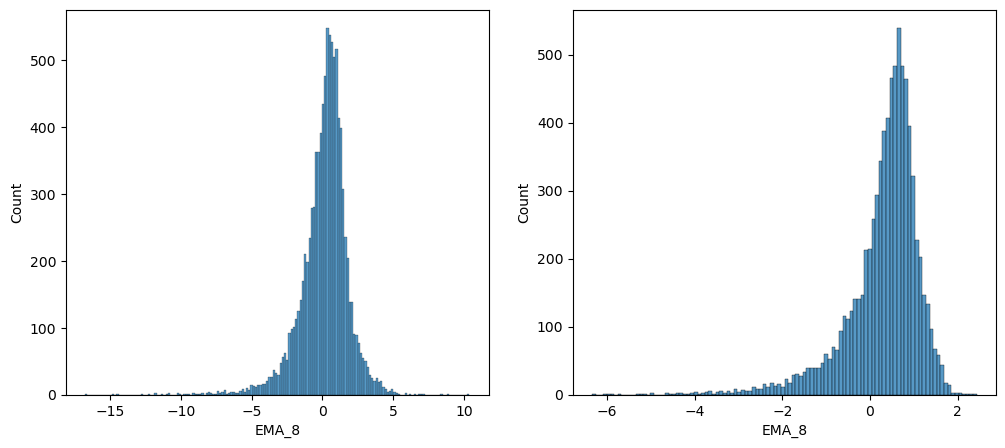

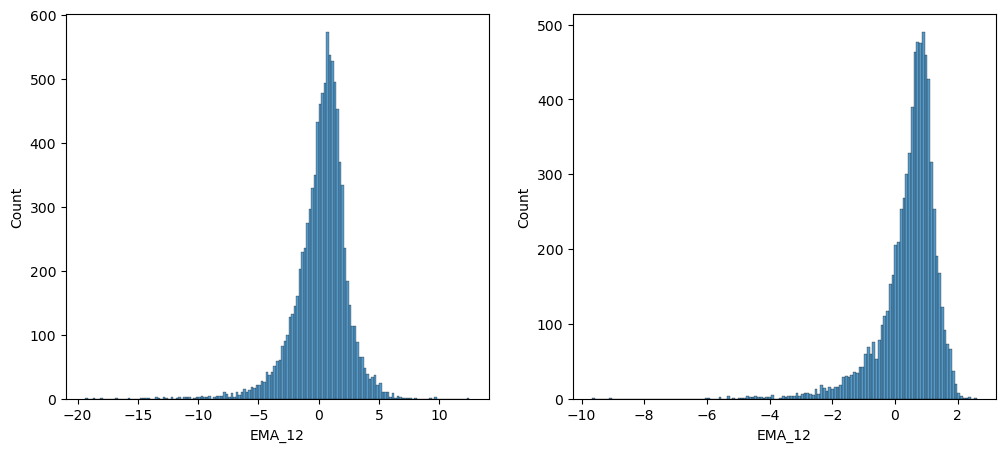

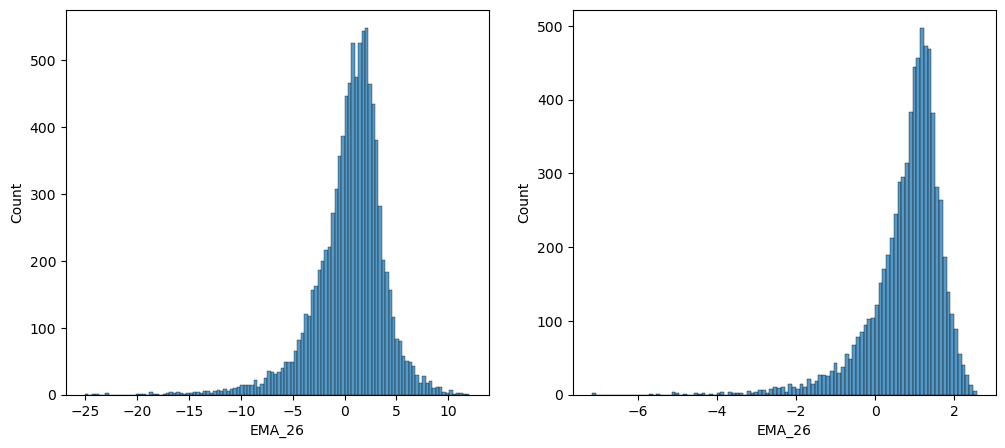

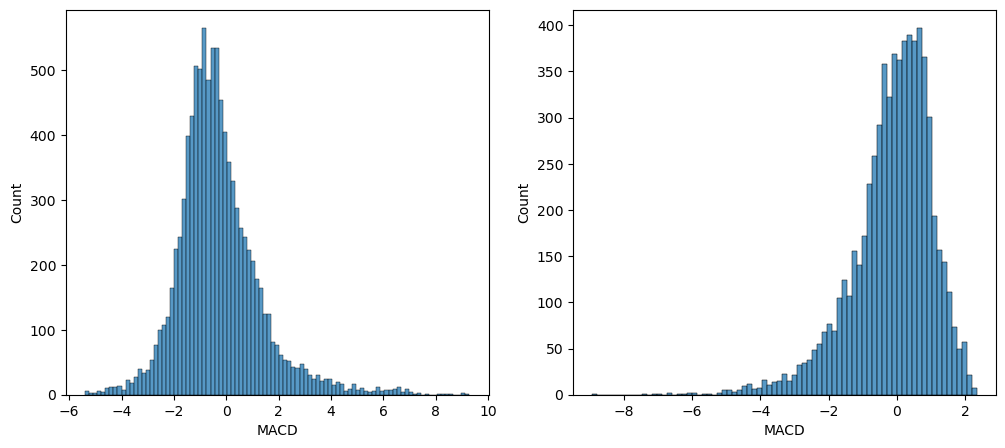

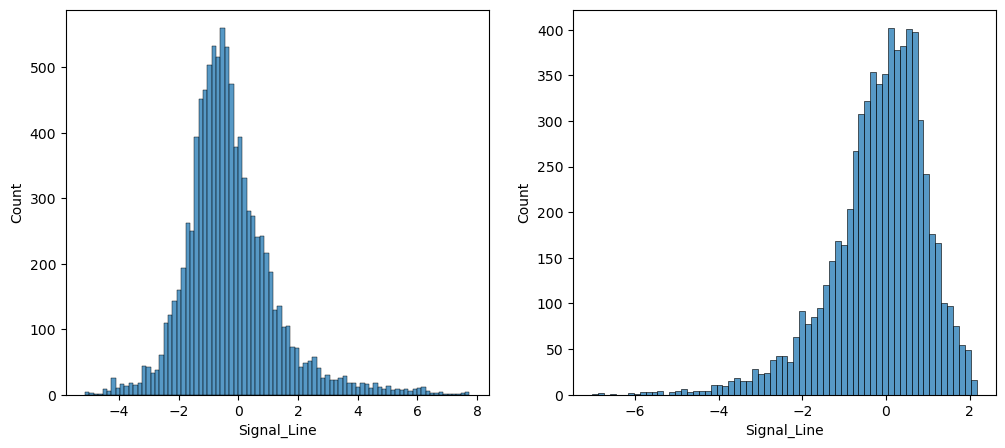

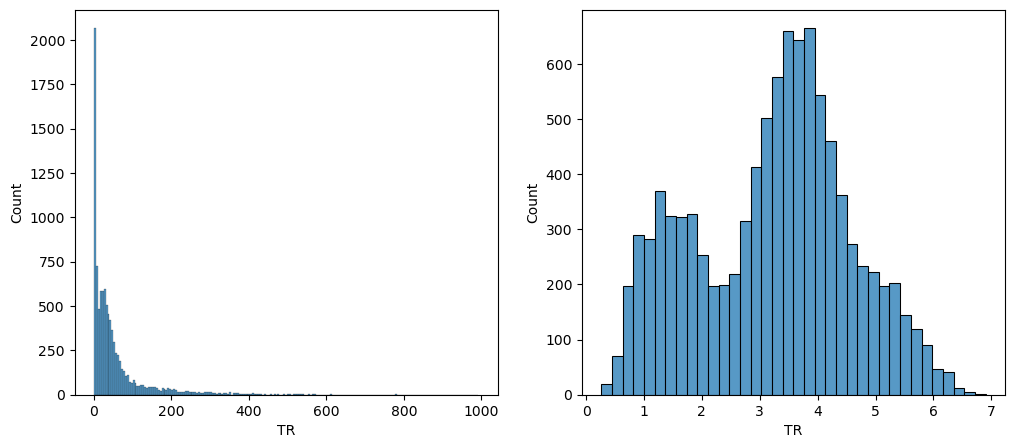

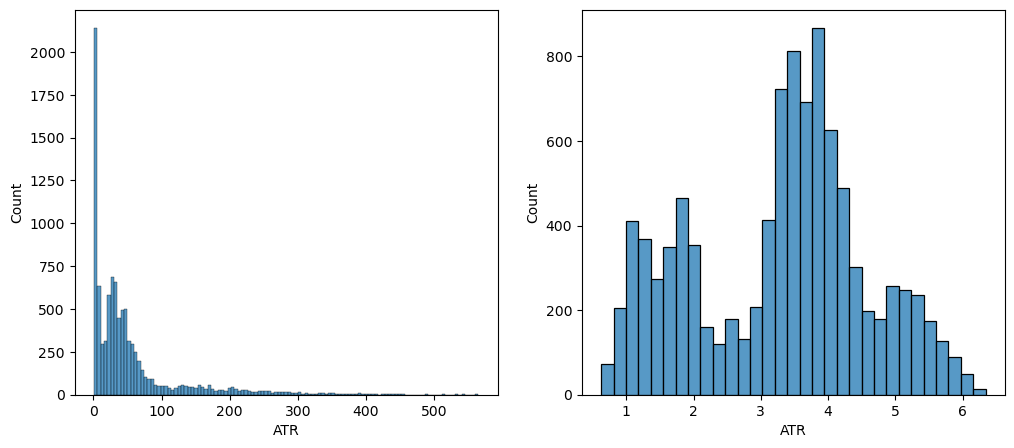

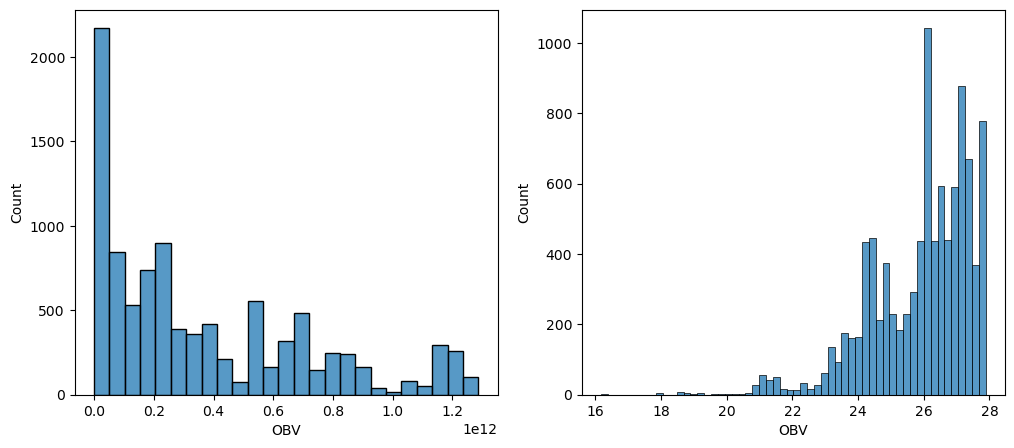

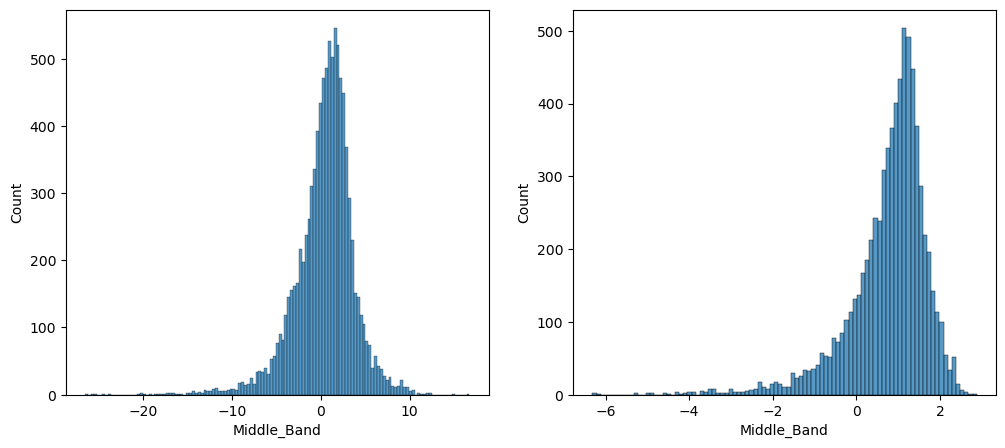

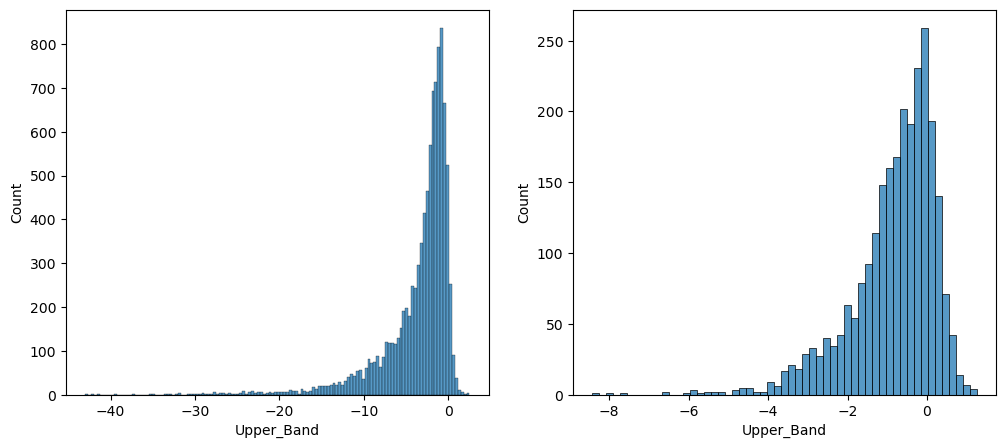

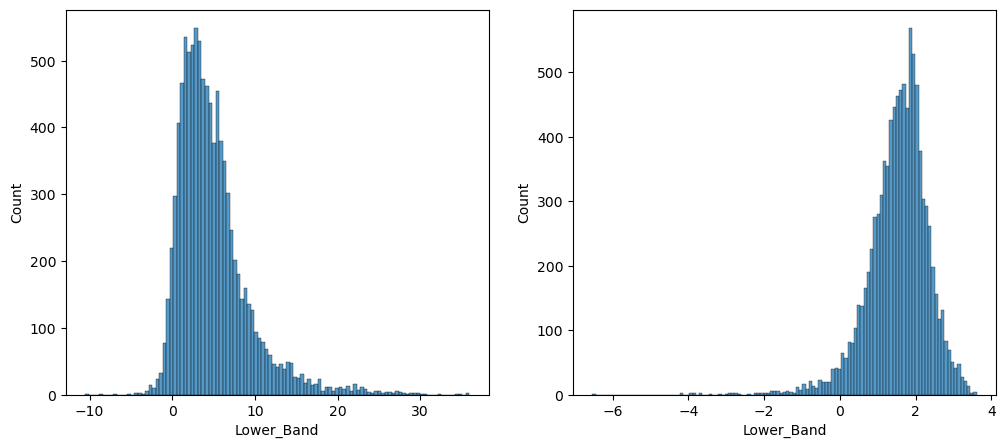

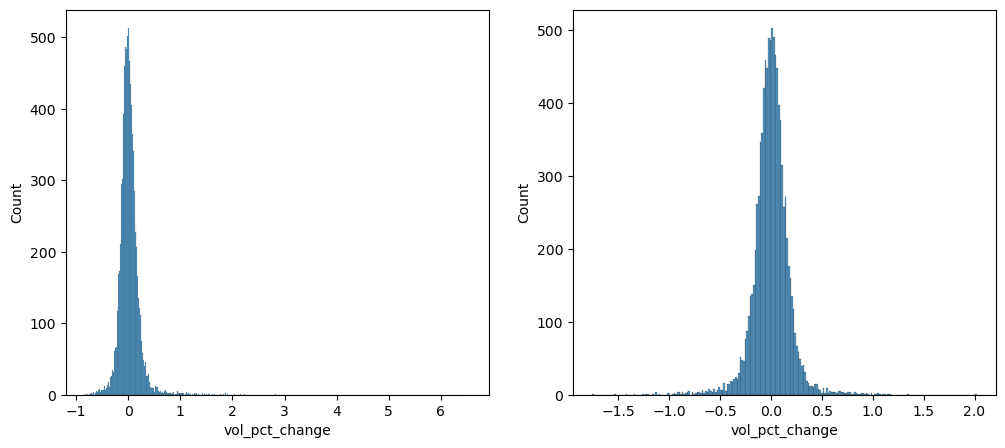

In [10]:
for i in dis_cols:
    fig, ax = plt.subplots(1,2,figsize = (12,5))
    sns.histplot(df_NASDAQ_technical[i], ax=ax[0])
    sns.histplot(np.log1p(df_NASDAQ_technical[i]), ax=ax[1])
    plt.show()

In [11]:
columns_with_outliers    = ['Volume', 'SMA_50', 'SMA_100', 'SMA_200', 'Momentum', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'TR', 'ATR', 'Middle_Band', 'Upper_Band', 'Lower_Band', 'vol_pct_change']
columns_to_log_transform = ['Volume', 'Momentum', 'TR', 'ATR', 'OBV', 'Upper_Band', 'Lower_Band', 'vol_pct_change']

explanations = [] #"explanation", "RMSE", "best params", "TN", "FP", "FN", "TP", "accuracy", "precision", "recall", "f1"

In [12]:
nasdaq = yf.Ticker("^IXIC")
df_NASDAQ = nasdaq.history(period="max")
df_NASDAQ.index = df_NASDAQ.index.date

df_NASDAQ_technical = add_technical_indicators(df_NASDAQ)
df_NASDAQ_technical["pct_close"] = df_NASDAQ_technical["pct_close"].shift(-1)
df_NASDAQ_technical = df_NASDAQ_technical[df_NASDAQ_technical.Volume != 0]
df_NASDAQ_technical.dropna(inplace=True)
df_NASDAQ_technical = df_NASDAQ_technical.iloc[1:]

min_momentum = df_NASDAQ_technical.Momentum.min()
min_OBV = df_NASDAQ_technical.OBV.min()
min_Upper_Band = df_NASDAQ_technical.Upper_Band.min()
min_Lower_Band = df_NASDAQ_technical.Lower_Band.min()
min_vol_pct_change = df_NASDAQ_technical.vol_pct_change.min()

df_NASDAQ_technical.loc[:, 'Momentum']       = df_NASDAQ_technical['Momentum'] - min_momentum + 1
df_NASDAQ_technical.loc[:, 'OBV']            = df_NASDAQ_technical['OBV'] - min_OBV + 1
df_NASDAQ_technical.loc[:, 'Upper_Band']     = df_NASDAQ_technical['Upper_Band'] - min_Upper_Band + 1
df_NASDAQ_technical.loc[:, 'Lower_Band']     = df_NASDAQ_technical['Lower_Band'] - min_Lower_Band + 1
df_NASDAQ_technical.loc[:, 'vol_pct_change'] = df_NASDAQ_technical['vol_pct_change'] - min_vol_pct_change + 1

In [13]:
target = "pct_close"

func_list = ["Only technical indicators"]

look_back = 30
test_coef = 20

X = df_NASDAQ_technical.drop(['pct_close'], axis = 1)
y = df_NASDAQ_technical[target].values

X_train = X[:-2 * look_back * test_coef]
X_test  = X[-2 * look_back * test_coef:] 

y_train = y[:-2 * look_back * test_coef]
y_test  = y[-2 * look_back * test_coef:]

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.05)
    max_depth = trial.suggest_int('max_depth', 8, 15)
    gamma = trial.suggest_float('gamma', 0.001, 0.02)
    
    pipeline = pip.Pipeline([
        ('log_transform', LogTransformer(columns=columns_to_log_transform)),
        ("scaler", pre.MinMaxScaler()),
        ("regressor", xgb.XGBRegressor(objective="reg:squarederror",
                                       eval_metric="rmse",
                                       random_state=42,
                                       n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                       gamma=gamma))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return met.mean_squared_error(y_test, y_pred, squared=False)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-09-01 19:01:36,093] A new study created in memory with name: no-name-6654c97f-7a71-4786-94a6-d3061f6f0f25


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-01 19:01:57,310] Trial 6 finished with value: 1.6873995306648202 and parameters: {'n_estimators': 102, 'learning_rate': 0.019457984021021363, 'max_depth': 11, 'gamma': 0.014041414202148259}. Best is trial 6 with value: 1.6873995306648202.
[I 2023-09-01 19:01:57,630] Trial 4 finished with value: 1.7180675548250957 and parameters: {'n_estimators': 126, 'learning_rate': 0.028810370522197735, 'max_depth': 9, 'gamma': 0.015085706863021207}. Best is trial 6 with value: 1.6873995306648202.
[I 2023-09-01 19:02:07,525] Trial 11 finished with value: 1.7487736961638156 and parameters: {'n_estimators': 118, 'learning_rate': 0.03152156400049786, 'max_depth': 12, 'gamma': 0.010681631883947072}. Best is trial 6 with value: 1.6873995306648202.
[I 2023-09-01 19:02:23,544] Trial 14 finished with value: 1.669838914608498 and parameters: {'n_estimators': 105, 'learning_rate': 0.016340718868459312, 'max_depth': 10, 'gamma': 0.007471366958997699}. Best is trial 14 with value: 1.669838914608498.
[

[I 2023-09-01 19:04:17,701] Trial 16 finished with value: 1.8244594068097408 and parameters: {'n_estimators': 365, 'learning_rate': 0.01973239405493911, 'max_depth': 13, 'gamma': 0.004520635255778372}. Best is trial 34 with value: 1.6471390528275511.
[I 2023-09-01 19:04:18,364] Trial 31 finished with value: 1.7189422814852182 and parameters: {'n_estimators': 253, 'learning_rate': 0.016945677693902105, 'max_depth': 8, 'gamma': 0.008203149851765009}. Best is trial 34 with value: 1.6471390528275511.
[I 2023-09-01 19:04:18,853] Trial 38 finished with value: 1.6531601653786225 and parameters: {'n_estimators': 256, 'learning_rate': 0.00577451343235017, 'max_depth': 8, 'gamma': 0.01710942873007802}. Best is trial 34 with value: 1.6471390528275511.
[I 2023-09-01 19:04:19,849] Trial 36 finished with value: 1.6672981487730723 and parameters: {'n_estimators': 258, 'learning_rate': 0.0012693964800734514, 'max_depth': 8, 'gamma': 0.017002699664859865}. Best is trial 34 with value: 1.647139052827551

[I 2023-09-01 19:06:22,939] Trial 64 finished with value: 1.710333271109176 and parameters: {'n_estimators': 312, 'learning_rate': 0.009257914651066936, 'max_depth': 11, 'gamma': 0.013099259497409867}. Best is trial 34 with value: 1.6471390528275511.
[I 2023-09-01 19:06:23,039] Trial 67 finished with value: 1.698594796675705 and parameters: {'n_estimators': 278, 'learning_rate': 0.008711105572953246, 'max_depth': 10, 'gamma': 0.010161476661488856}. Best is trial 34 with value: 1.6471390528275511.
[I 2023-09-01 19:06:23,224] Trial 61 finished with value: 1.7556595716712515 and parameters: {'n_estimators': 317, 'learning_rate': 0.013154363457102173, 'max_depth': 11, 'gamma': 0.014874788917737906}. Best is trial 34 with value: 1.6471390528275511.
[I 2023-09-01 19:06:28,312] Trial 72 finished with value: 1.6635424114109587 and parameters: {'n_estimators': 271, 'learning_rate': 0.003521896656018798, 'max_depth': 11, 'gamma': 0.016095153961306997}. Best is trial 34 with value: 1.647139052827

[I 2023-09-01 19:07:48,064] Trial 89 finished with value: 1.6992342842712767 and parameters: {'n_estimators': 291, 'learning_rate': 0.004535123656329306, 'max_depth': 14, 'gamma': 0.018130577616471834}. Best is trial 34 with value: 1.6471390528275511.


In [14]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: 1.6471390528275511
Params: 
    n_estimators: 258
    learning_rate: 0.003860880632434508
    max_depth: 8
    gamma: 0.017320465079684096


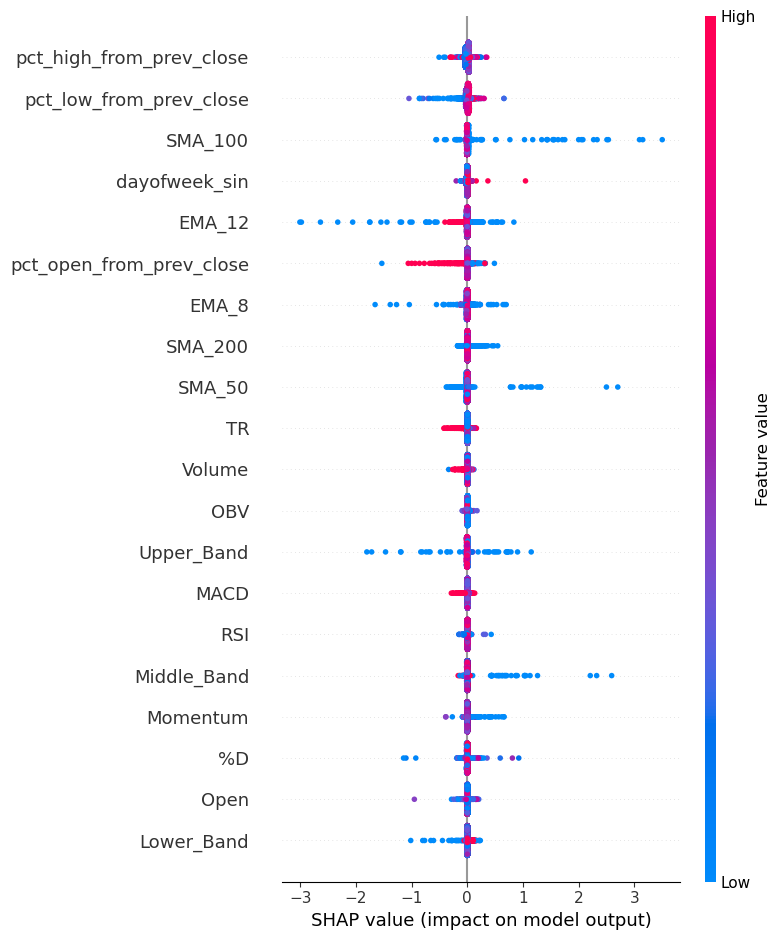

In [15]:
best_params = study.best_params

best_model = xgb.XGBRegressor(objective="reg:squarederror",
                              eval_metric="rmse",
                              random_state=42,
                              n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

r2 = met.r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]

adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
func_list.append(adj_r2)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

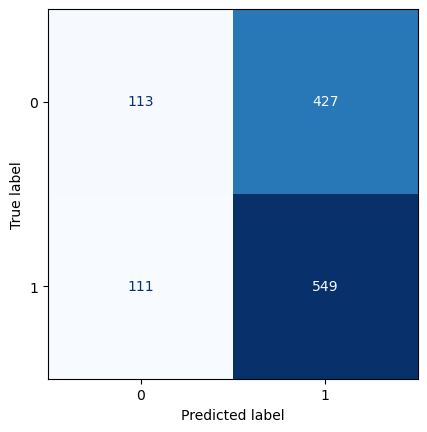

In [16]:
y_pred_classified = (y_pred > 0).astype(int)
y_test_classified = (y_test > 0).astype(int)

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

func_list.append(y_pred)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [17]:
indices = [
    "BTC-USD",
    "^VIX",    # CBOE Volatility Index (VIX)
    "^DJI",    # Dow Jones Industrial Average
    "^GSPC",   # S&P 500 Index
    "^FTSE",   # FTSE 100 Index (UK)
    "^GDAXI",  # DAX 30 Index (Germany)
    "^FCHI",   # CAC 40 Index (France)
    "^N225",   # Nikkei 225 Index (Japan)
    "^HSI",    # Hang Seng Index (Hong Kong)
    "^AXJO",   # S&P/ASX 200 Index (Australia)
    "^KS11",   # KOSPI Composite Index (South Korea)
    "^BSESN",  # BSE SENSEX (India)
    "^BVSP",   # Bovespa Index (Brazil)
    "GC=F",    # Gold Futures
    "SI=F",    # Silver Futures
    "CL=F",    # Crude Oil WTI Futures
    "NG=F",    # Natural Gas Futures
    "ZC=F",    # Corn Futures
    "ZW=F",    # Wheat Futures
]

In [18]:
df_indices = get_indices_pct_change(indices)
df_indices.head()

^GSPC  ^N225  ^FTSE  ^HSI  ^GDAXI  ^FCHI  ^VIX  ^DJI  ^AXJO  \
1927-12-30  17.660000    NaN    NaN   NaN     NaN    NaN   NaN   NaN    NaN   
1928-01-03  17.760000    NaN    NaN   NaN     NaN    NaN   NaN   NaN    NaN   
1928-01-04  17.719999    NaN    NaN   NaN     NaN    NaN   NaN   NaN    NaN   
1928-01-05  17.549999    NaN    NaN   NaN     NaN    NaN   NaN   NaN    NaN   
1928-01-06  17.660000    NaN    NaN   NaN     NaN    NaN   NaN   NaN    NaN   

            ^BVSP  ^KS11  ^BSESN  ZC=F  CL=F  NG=F  SI=F  ZW=F  GC=F  BTC-USD  
1927-12-30    NaN    NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN      NaN  
1928-01-03    NaN    NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN      NaN  
1928-01-04    NaN    NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN      NaN  
1928-01-05    NaN    NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN      NaN  
1928-01-06    NaN    NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN      NaN

In [19]:
final_df = pd.concat([df_indices, df_NASDAQ], axis = 1)
final_df.fillna(method = "ffill", inplace=True)
final_df = add_technical_indicators(final_df)
final_df["pct_close"] = final_df["pct_close"].shift(-1)
final_df.tail()

^GSPC         ^N225        ^FTSE          ^HSI  \
2023-08-28  4433.310059  32169.990234  7338.600098  18130.740234   
2023-08-29  4497.629883  32226.970703  7465.000000  18484.029297   
2023-08-30  4514.870117  32333.460938  7473.700195  18482.859375   
2023-08-31  4507.660156  32619.339844  7439.100098  18382.060547   
2023-09-01  4504.370117  32710.619141  7464.540039  18382.060547   

                  ^GDAXI        ^FCHI   ^VIX          ^DJI        ^AXJO  \
2023-08-28  15792.610352  7324.709961  15.08  34559.980469  7159.799805   
2023-08-29  15930.879883  7373.430176  14.45  34852.671875  7210.500000   
2023-08-30  15891.929688  7364.399902  13.88  34890.238281  7297.700195   
2023-08-31  15947.080078  7316.700195  13.57  34721.910156  7305.299805   
2023-09-01  15840.339844  7296.770020  13.34  34740.171875  7278.299805   

                    ^BVSP  ...    EMA_26      MACD  Signal_Line          TR  \
2023-08-28  117121.000000  ...  0.393995  0.527272     0.784565  145.330078   
2023-08-29  118404.000000  ...  1.980217  0.276889     0.683030  282.750000   
2023-08-30  117535.000000  ...  2.340760  0.027664     0.551957  126.620117   
2023-08-31  115742.000000  ...  2.269095 -0.176280     0.406310  104.189453   
2023-09-01  117563.976562  ...  1.787139 -0.304308     0.264186  164.028320   

                   ATR           OBV  Middle_Band  Upper_Band  Lower_Band  \
2023-08-28  212.974400  1.182779e+12     1.091385   -1.239305    3.534739   
2023-08-29  220.571568  1.187528e+12     2.767517    0.131491    5.546085   
2023-08-30  217.380859  1.191892e+12     3.217326    0.233161    6.384635   
2023-08-31  208.277274  1.196461e+12     3.184438   -0.133601    6.730536   
2023-09-01  207.557129  1.194710e+12     2.715328   -0.808793    6.499088   

            vol_pct_change  
2023-08-28       -0.076417  
2023-08-29        0.294953  
2023-08-30       -0.080785  
2023-08-31        0.046742  
2023-09-01       -0.616782  

[5 rows x 49 columns]

In [20]:
for idx in indices:
    final_df[idx] = final_df[idx].pct_change()
    
final_df.dropna(inplace = True)
final_df.head()

^GSPC     ^N225     ^FTSE      ^HSI    ^GDAXI     ^FCHI  \
2014-09-18  0.004891  0.011260  0.005663 -0.008520  0.014142  0.007512   
2014-09-19 -0.000477  0.015783  0.002728  0.005687  0.000115 -0.000779   
2014-09-20  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2014-09-21  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2014-09-22 -0.008013 -0.007063 -0.009403 -0.014427 -0.005074 -0.004185   

                ^VIX      ^DJI     ^AXJO     ^BVSP  ...    EMA_26      MACD  \
2014-09-18 -0.049012  0.006361  0.001572 -0.012418  ...  1.153780 -0.537743   
2014-09-19  0.006650  0.000796  0.003194 -0.010022  ...  0.789691 -0.521372   
2014-09-20  0.000000  0.000000  0.000000  0.000000  ...  0.730768 -0.503822   
2014-09-21  0.000000  0.000000  0.000000  0.000000  ...  0.676271 -0.484307   
2014-09-22  0.130471 -0.006196 -0.012902 -0.016803  ... -0.434439 -0.368741   

            Signal_Line         TR        ATR           OBV  Middle_Band  \
2014-09-18    -0.675390  31.790039  40.890032  6.566522e+11     0.525750   
2014-09-19    -0.644586  47.129883  42.364293  6.534737e+11     0.182031   
2014-09-20    -0.616434  47.129883  44.171422  6.534737e+11     0.157449   
2014-09-21    -0.590008  47.129883  44.340681  6.534737e+11     0.147429   
2014-09-22    -0.545755  66.669922  45.542829  6.515922e+11    -0.946446   

            Upper_Band  Lower_Band  vol_pct_change  
2014-09-18   -0.347468    1.414407       -0.012172  
2014-09-19   -0.633454    1.011012        0.790860  
2014-09-20   -0.648194    0.976265        0.000000  
2014-09-21   -0.660731    0.968847        0.000000  
2014-09-22   -1.856437   -0.019422       -0.408046  

[5 rows x 49 columns]

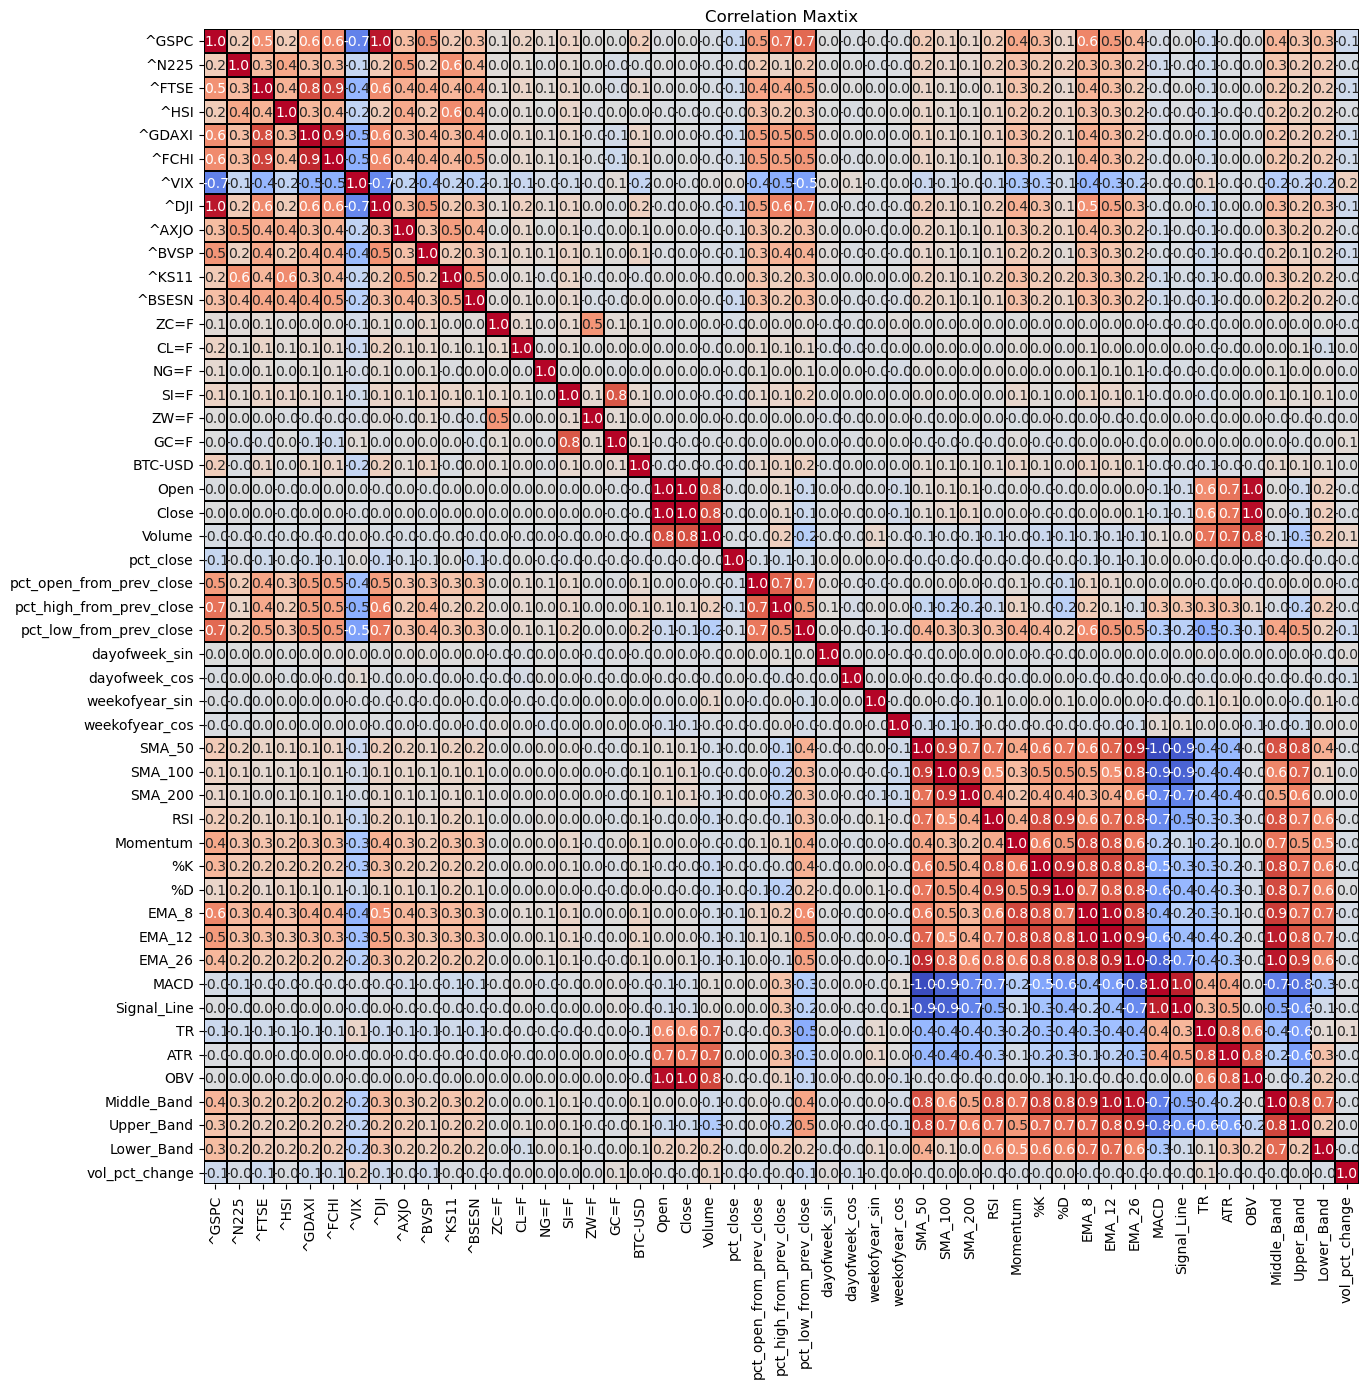

In [21]:
fig, ax = plt.subplots (figsize = (15, 15))
corr_matrix = final_df.corr()

sns.heatmap(corr_matrix,
            cmap= "coolwarm",
            cbar= False,
            square=True,
            annot=True,
            linecolor="black",
            linewidths=0.1,
            fmt= ".1f",
            ax=ax
           )
ax.set_title("Correlation Maxtix", fontsize = 12)
plt.show()

All in one cell

In [22]:
nasdaq = yf.Ticker("^IXIC")
df_NASDAQ = nasdaq.history(period="max")
df_NASDAQ.index = df_NASDAQ.index.date

df_indices = get_indices_pct_change(indices)
final_df = pd.concat([df_indices, df_NASDAQ], axis = 1)
final_df.fillna(method = "ffill", inplace=True)
final_df = add_technical_indicators(final_df)
final_df["pct_close"] = final_df["pct_close"].shift(-1)

for idx in indices:
    final_df[idx] = final_df[idx].pct_change()

final_df = final_df[final_df.Volume != 0]
final_df.dropna(inplace=True)
final_df = final_df.iloc[1:]

min_momentum = final_df.Momentum.min()
min_OBV = final_df.OBV.min()
min_Upper_Band = final_df.Upper_Band.min()
min_Lower_Band = final_df.Lower_Band.min()
min_vol_pct_change = final_df.vol_pct_change.min()

final_df.loc[:, 'Momentum']       = final_df['Momentum'] - min_momentum + 1
final_df.loc[:, 'OBV']            = final_df['OBV'] - min_OBV + 1
final_df.loc[:, 'Upper_Band']     = final_df['Upper_Band'] - min_Upper_Band + 1
final_df.loc[:, 'Lower_Band']     = final_df['Lower_Band'] - min_Lower_Band + 1
final_df.loc[:, 'vol_pct_change'] = final_df['vol_pct_change'] - min_vol_pct_change + 1

final_df.describe()

^GSPC        ^N225        ^FTSE         ^HSI       ^GDAXI  \
count  3269.000000  3269.000000  3269.000000  3269.000000  3269.000000   
mean      0.000293     0.000270     0.000064    -0.000024     0.000205   
std       0.009613     0.010367     0.008594     0.010893     0.010559   
min      -0.119841    -0.079216    -0.108738    -0.063563    -0.122386   
25%      -0.001502    -0.002274    -0.002043    -0.003122    -0.002397   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.002908     0.003653     0.002889     0.003474     0.003614   
max       0.093828     0.080381     0.090530     0.090818     0.109759   

             ^FCHI         ^VIX         ^DJI        ^AXJO        ^BVSP  ...  \
count  3269.000000  3269.000000  3269.000000  3269.000000  3269.000000  ...   
mean      0.000205     0.002377     0.000259     0.000126     0.000299  ...   
std       0.010326     0.071863     0.009513     0.008277     0.013303  ...   
min      -0.122768    -0.259057    -0.129265    -0.096998    -0.147797  ...   
25%      -0.002357    -0.026502    -0.001540    -0.001824    -0.003495  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.003670     0.014809     0.002780     0.003219     0.005019  ...   
max       0.083895     1.155979     0.113650     0.070007     0.139082  ...   

            EMA_26         MACD  Signal_Line           TR          ATR  \
count  3269.000000  3269.000000  3269.000000  3269.000000  3269.000000   
mean      0.420385    -0.237394    -0.238718   136.688515   136.365268   
std       2.472039     1.125661     1.056468   118.567920   100.859046   
min     -17.883478    -3.080547    -2.527627    14.379883    26.236537   
25%      -0.754482    -0.980822    -0.940700    50.910156    55.565778   
50%       0.889525    -0.426808    -0.412598    94.919922   102.984235   
75%       1.993149     0.295151     0.266796   187.849609   190.425014   
max       7.988424     6.640379     5.907990   992.020020   606.285052   

                OBV  Middle_Band   Upper_Band   Lower_Band  vol_pct_change  
count  3.269000e+03  3269.000000  3269.000000  3269.000000     3269.000000  
mean   2.756488e+11     0.333263    25.210239     9.586353        1.649510  
std    2.101533e+11     2.527882     3.270364     3.084005        0.147921  
min    1.000000e+00   -16.985790     1.000000     1.000000        1.000000  
25%    6.016490e+10    -0.909792    24.394885     7.399973        1.603442  
50%    2.176163e+11     0.768927    26.336452     9.103046        1.639642  
75%    5.235900e+11     1.872627    27.234177    11.045218        1.674119  
max    6.475708e+11     9.204200    29.671697    28.021280        3.510901  

[8 rows x 49 columns]

In [23]:
target = "pct_close"

func_list = ["Technical indicators and Other indices"]

X = final_df.drop(['pct_close'], axis = 1)
y = final_df[target].values

X_train = X[:-2 * look_back * test_coef]
X_test  = X[-2 * look_back * test_coef:] 

y_train = y[:-2 * look_back * test_coef]
y_test  = y[-2 * look_back * test_coef:]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-09-01 19:08:26,200] A new study created in memory with name: no-name-061b51f2-dc98-46f9-84a7-e7b1d856cb28


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-01 19:08:30,748] Trial 6 finished with value: 1.3849080908989482 and parameters: {'n_estimators': 108, 'learning_rate': 0.010793318524068531, 'max_depth': 8, 'gamma': 0.009954420608024855}. Best is trial 6 with value: 1.3849080908989482.
[I 2023-09-01 19:08:33,399] Trial 3 finished with value: 1.3160518027515284 and parameters: {'n_estimators': 108, 'learning_rate': 0.0015394456958081177, 'max_depth': 13, 'gamma': 0.0015054425619347783}. Best is trial 3 with value: 1.3160518027515284.
[I 2023-09-01 19:08:33,958] Trial 9 finished with value: 1.6414713555221234 and parameters: {'n_estimators': 156, 'learning_rate': 0.021801583592411453, 'max_depth': 8, 'gamma': 0.018737968407807542}. Best is trial 3 with value: 1.3160518027515284.
[I 2023-09-01 19:08:35,057] Trial 4 finished with value: 1.6905539774616898 and parameters: {'n_estimators': 170, 'learning_rate': 0.028851509402240003, 'max_depth': 8, 'gamma': 0.010218351561679908}. Best is trial 3 with value: 1.3160518027515284.
[

[I 2023-09-01 19:09:31,950] Trial 36 finished with value: 1.4594315314778452 and parameters: {'n_estimators': 206, 'learning_rate': 0.006847084931753468, 'max_depth': 15, 'gamma': 0.003045720888794267}. Best is trial 3 with value: 1.3160518027515284.
[I 2023-09-01 19:09:32,713] Trial 32 finished with value: 1.6187732142296656 and parameters: {'n_estimators': 311, 'learning_rate': 0.007190758912119065, 'max_depth': 15, 'gamma': 0.0012359082884582705}. Best is trial 3 with value: 1.3160518027515284.
[I 2023-09-01 19:09:33,946] Trial 33 finished with value: 1.6178630814959813 and parameters: {'n_estimators': 315, 'learning_rate': 0.00709326781149941, 'max_depth': 15, 'gamma': 0.0022627978304105667}. Best is trial 3 with value: 1.3160518027515284.
[I 2023-09-01 19:09:35,441] Trial 39 finished with value: 1.407233437199346 and parameters: {'n_estimators': 206, 'learning_rate': 0.005652950097128661, 'max_depth': 11, 'gamma': 0.0034454657598243475}. Best is trial 3 with value: 1.3160518027515

[I 2023-09-01 19:10:15,637] Trial 69 finished with value: 1.3292279243478875 and parameters: {'n_estimators': 105, 'learning_rate': 0.005043447816615098, 'max_depth': 13, 'gamma': 0.005652771496100826}. Best is trial 3 with value: 1.3160518027515284.
[I 2023-09-01 19:10:16,001] Trial 71 finished with value: 1.3243713482370276 and parameters: {'n_estimators': 101, 'learning_rate': 0.003807739854679224, 'max_depth': 13, 'gamma': 0.0068231946549045745}. Best is trial 3 with value: 1.3160518027515284.
[I 2023-09-01 19:10:16,109] Trial 72 finished with value: 1.3237032875197823 and parameters: {'n_estimators': 101, 'learning_rate': 0.003660797167369216, 'max_depth': 13, 'gamma': 0.00651349202894793}. Best is trial 3 with value: 1.3160518027515284.
[I 2023-09-01 19:10:16,215] Trial 70 finished with value: 1.3356557940744573 and parameters: {'n_estimators': 103, 'learning_rate': 0.004490906938967795, 'max_depth': 14, 'gamma': 0.00662705533979901}. Best is trial 3 with value: 1.316051802751528

In [24]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: 1.3160518027515284
Params: 
    n_estimators: 108
    learning_rate: 0.0015394456958081177
    max_depth: 13
    gamma: 0.0015054425619347783


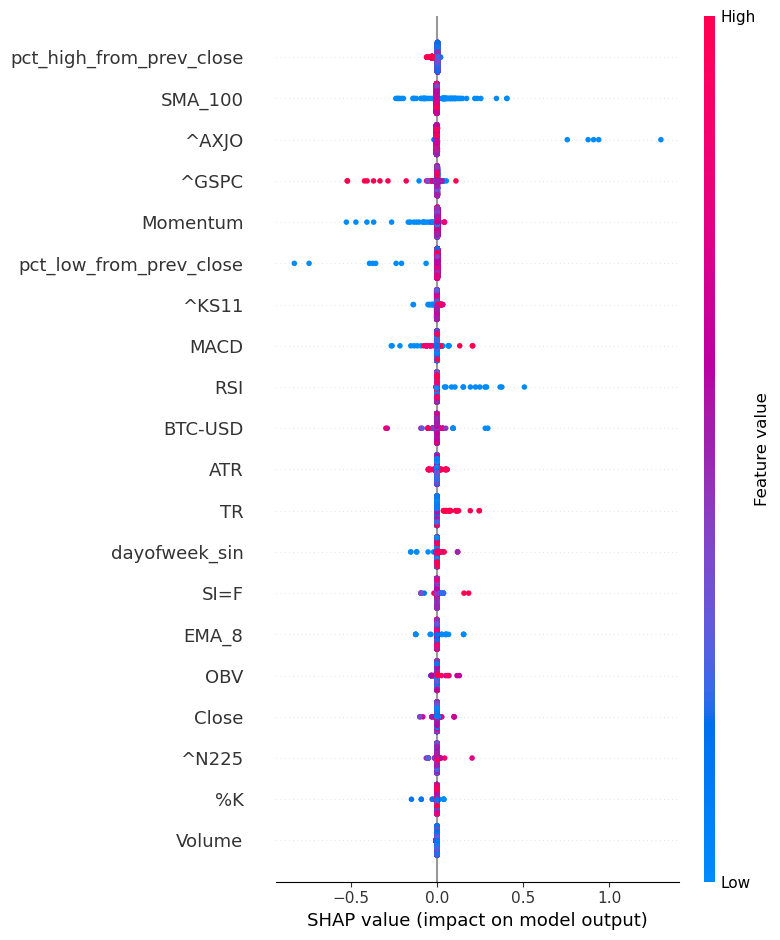

In [25]:
best_params = study.best_params

best_model = xgb.XGBRegressor(objective="reg:squarederror",
                              eval_metric="rmse",
                              random_state=42,
                              n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

r2 = met.r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]

adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
func_list.append(adj_r2)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

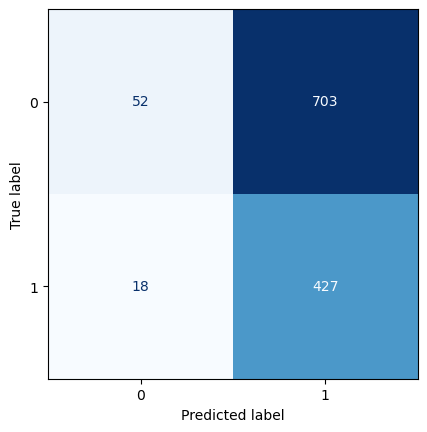

In [26]:
y_pred_classified = (y_pred > 0).astype(int)
y_test_classified = (y_test > 0).astype(int)

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

func_list.append(y_pred)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [27]:
target = "pct_close"

func_list = ["Technical indicators, Other indices and Feature engine"]

X = final_df.drop(['pct_close'], axis = 1)
y = final_df[target].values

X_train = X[:-2 * look_back * test_coef]
X_test  = X[-2 * look_back * test_coef:] 

y_train = y[:-2 * look_back * test_coef]
y_test  = y[-2 * look_back * test_coef:]

columns_with_outliers = ['Volume', 'SMA_50', 'SMA_100', 'SMA_200', 'Momentum', 'EMA_8', 'EMA_12', 'EMA_26', 'MACD',\
                         'Signal_Line', 'TR', 'ATR', 'Middle_Band', 'Upper_Band', 'Lower_Band', 'vol_pct_change']
columns_to_log_transform = ['Volume', 'Momentum', 'TR', 'ATR', 'OBV', 'Upper_Band', 'Lower_Band', 'vol_pct_change']

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.05)
    max_depth = trial.suggest_int('max_depth', 8, 15)
    gamma = trial.suggest_float('gamma', 0.001, 0.02)
    
    pipeline = pip.Pipeline([
        ('log_transform', LogTransformer(columns=columns_to_log_transform)),
        ('winsorizer', fout.Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=columns_with_outliers)),
        ('scaler', pre.MinMaxScaler()),
        ('drop_duplicate', fsel.DropDuplicateFeatures()),
        ('drop_correlated', fsel.DropCorrelatedFeatures()),
        ('drop_constant', fsel.DropConstantFeatures(tol=0.998)),
        ('rfa', fsel.RecursiveFeatureAddition(estimator=xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse"), scoring="r2")),
        ('regressor', xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", random_state=42, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, gamma=gamma))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return met.mean_squared_error(y_test, y_pred, squared=False)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-09-01 19:10:58,903] A new study created in memory with name: no-name-d0d4e770-9408-4c75-986c-1a9a291aaf95


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-01 19:12:17,840] Trial 8 finished with value: 1.3677230446921422 and parameters: {'n_estimators': 121, 'learning_rate': 0.008030477395368406, 'max_depth': 9, 'gamma': 0.01534257698702119}. Best is trial 8 with value: 1.3677230446921422.
[I 2023-09-01 19:12:19,340] Trial 1 finished with value: 1.5034585613327744 and parameters: {'n_estimators': 197, 'learning_rate': 0.049690808450202274, 'max_depth': 8, 'gamma': 0.01282046054265357}. Best is trial 8 with value: 1.3677230446921422.
[I 2023-09-01 19:12:20,213] Trial 3 finished with value: 1.5195466439040584 and parameters: {'n_estimators': 112, 'learning_rate': 0.03343349121248951, 'max_depth': 11, 'gamma': 0.006077954350238282}. Best is trial 8 with value: 1.3677230446921422.
[I 2023-09-01 19:12:21,159] Trial 2 finished with value: 1.5067774531760598 and parameters: {'n_estimators': 305, 'learning_rate': 0.0441224146485668, 'max_depth': 8, 'gamma': 0.01038955741522717}. Best is trial 8 with value: 1.3677230446921422.
[I 2023-0

[I 2023-09-01 19:15:16,066] Trial 30 finished with value: 1.3527021841688522 and parameters: {'n_estimators': 388, 'learning_rate': 0.0010217358766974826, 'max_depth': 10, 'gamma': 0.0015329996934954585}. Best is trial 32 with value: 1.3427330541383027.
[I 2023-09-01 19:15:21,424] Trial 35 finished with value: 1.4481980367322702 and parameters: {'n_estimators': 163, 'learning_rate': 0.010525368866681404, 'max_depth': 10, 'gamma': 0.015988701695830596}. Best is trial 32 with value: 1.3427330541383027.
[I 2023-09-01 19:15:21,997] Trial 34 finished with value: 1.4454626670203519 and parameters: {'n_estimators': 156, 'learning_rate': 0.010185528890344915, 'max_depth': 10, 'gamma': 0.01584973461852572}. Best is trial 32 with value: 1.3427330541383027.
[I 2023-09-01 19:16:27,214] Trial 36 finished with value: 1.4386966066978522 and parameters: {'n_estimators': 145, 'learning_rate': 0.010501092575464551, 'max_depth': 10, 'gamma': 0.015870493376283955}. Best is trial 32 with value: 1.342733054

[I 2023-09-01 19:19:26,729] Trial 66 finished with value: 1.3798168939327482 and parameters: {'n_estimators': 322, 'learning_rate': 0.006582229748288607, 'max_depth': 8, 'gamma': 0.019363294747564267}. Best is trial 48 with value: 1.3217997704478064.
[I 2023-09-01 19:19:29,984] Trial 67 finished with value: 1.380467742194757 and parameters: {'n_estimators': 322, 'learning_rate': 0.006480196487335528, 'max_depth': 8, 'gamma': 0.01898493472168936}. Best is trial 48 with value: 1.3217997704478064.
[I 2023-09-01 19:19:32,429] Trial 69 finished with value: 1.383205493268546 and parameters: {'n_estimators': 320, 'learning_rate': 0.006756807830304028, 'max_depth': 8, 'gamma': 0.019392971004253457}. Best is trial 48 with value: 1.3217997704478064.
[I 2023-09-01 19:19:35,118] Trial 68 finished with value: 1.5232699957597164 and parameters: {'n_estimators': 321, 'learning_rate': 0.00659024856118259, 'max_depth': 14, 'gamma': 0.018964899416771666}. Best is trial 48 with value: 1.3217997704478064.

[I 2023-09-01 19:22:54,160] Trial 99 finished with value: 1.3340581364007267 and parameters: {'n_estimators': 348, 'learning_rate': 0.002468799250065876, 'max_depth': 8, 'gamma': 0.01788445782546501}. Best is trial 48 with value: 1.3217997704478064.


In [28]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: 1.3217997704478064
Params: 
    n_estimators: 364
    learning_rate: 0.0010754039351862782
    max_depth: 8
    gamma: 0.0177671488261991


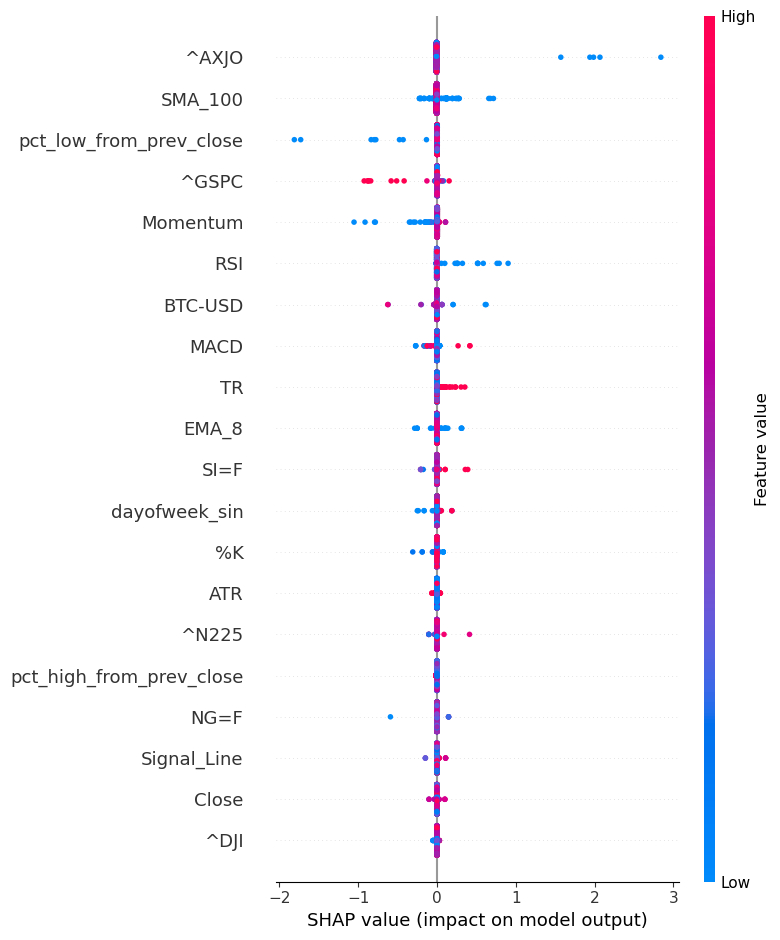

In [29]:
best_params = study.best_params

best_model = xgb.XGBRegressor(objective="reg:squarederror",
                              eval_metric="rmse",
                              random_state=42,
                              n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

r2 = met.r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]

adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
func_list.append(adj_r2)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

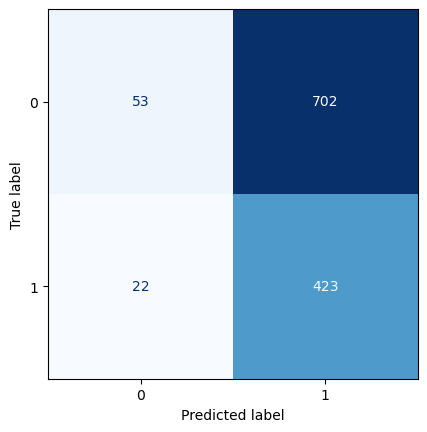

In [30]:
y_pred_classified = (y_pred > 0).astype(int)
y_test_classified = (y_test > 0).astype(int)

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

func_list.append(y_pred)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [31]:
df_results_base = pd.DataFrame(explanations, columns=["Explanation", "RMSE", "Best Params", "Adj-R2", "TN", "FP", "FN", "TP", "Accuracy", "Precision", "Recall", "F1", "y_pred"])
df_results_base.iloc[:, :-1]

Explanation      RMSE  \
0                          Only technical indicators  1.647139   
1             Technical indicators and Other indices  1.316052   
2  Technical indicators, Other indices and Featur...  1.321800   

                                         Best Params    Adj-R2   TN   FP   FN  \
0  {'n_estimators': 258, 'learning_rate': 0.00386... -0.052382  113  427  111   
1  {'n_estimators': 108, 'learning_rate': 0.00153... -0.147019   52  703   18   
2  {'n_estimators': 364, 'learning_rate': 0.00107... -0.139854   53  702   22   

    TP  Accuracy  Precision    Recall        F1  
0  549  0.551667   0.562500  0.831818  0.671149  
1  427  0.399167   0.377876  0.959551  0.542222  
2  423  0.396667   0.376000  0.950562  0.538854

In [32]:
def custom_loss_numpy(y_true, y_pred):
    signs_match = np.sign(y_true) == np.sign(y_pred)
    error = np.where(signs_match, 0.0, (y_true - y_pred) ** 2)
    loss = np.mean(error)
    return loss

In [33]:
target = "pct_close"

func_list = ["Only technical indicators with custom loss"]

look_back = 30
test_coef = 20

X = df_NASDAQ_technical.drop(['pct_close'], axis = 1)
y = df_NASDAQ_technical[target].values

X_train = X[:-2 * look_back * test_coef]
X_test  = X[-2 * look_back * test_coef:] 

y_train = y[:-2 * look_back * test_coef]
y_test  = y[-2 * look_back * test_coef:]

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.05)
    max_depth = trial.suggest_int('max_depth', 8, 15)
    gamma = trial.suggest_float('gamma', 0.001, 0.02)
    
    pipeline = pip.Pipeline([
        ('log_transform', LogTransformer(columns=columns_to_log_transform)),
        ("scaler", pre.MinMaxScaler()),
        ("regressor", xgb.XGBRegressor(objective="reg:squarederror",
                                       eval_metric="rmse",
                                       random_state=42,
                                       n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                       gamma=gamma))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return custom_loss_numpy(y_test, y_pred) 

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-09-01 19:22:58,318] A new study created in memory with name: no-name-298df4ea-853b-45d8-bbd9-2e2bb5707a39


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-01 19:23:14,114] Trial 2 finished with value: 1.8553169919790313 and parameters: {'n_estimators': 125, 'learning_rate': 0.025479330044976677, 'max_depth': 8, 'gamma': 0.0014641546377281956}. Best is trial 2 with value: 1.8553169919790313.
[I 2023-09-01 19:23:27,471] Trial 9 finished with value: 2.3663528368908073 and parameters: {'n_estimators': 187, 'learning_rate': 0.04981827443538349, 'max_depth': 9, 'gamma': 0.010783842748156303}. Best is trial 2 with value: 1.8553169919790313.
[I 2023-09-01 19:23:30,788] Trial 8 finished with value: 2.338274637776871 and parameters: {'n_estimators': 128, 'learning_rate': 0.04189111770991349, 'max_depth': 12, 'gamma': 0.011178575801165762}. Best is trial 2 with value: 1.8553169919790313.
[I 2023-09-01 19:23:31,215] Trial 1 finished with value: 2.072146733113759 and parameters: {'n_estimators': 282, 'learning_rate': 0.013761001160737512, 'max_depth': 8, 'gamma': 0.008991978193679185}. Best is trial 2 with value: 1.8553169919790313.
[I 202

[I 2023-09-01 19:25:37,265] Trial 38 finished with value: 1.7894007342970604 and parameters: {'n_estimators': 328, 'learning_rate': 0.0011590241996909598, 'max_depth': 9, 'gamma': 0.004518296218968914}. Best is trial 38 with value: 1.7894007342970604.
[I 2023-09-01 19:25:46,732] Trial 36 finished with value: 2.082070211806627 and parameters: {'n_estimators': 290, 'learning_rate': 0.02078150087065714, 'max_depth': 9, 'gamma': 0.004358402912569991}. Best is trial 38 with value: 1.7894007342970604.
[I 2023-09-01 19:25:49,437] Trial 35 finished with value: 2.102174387094615 and parameters: {'n_estimators': 323, 'learning_rate': 0.020527500317396377, 'max_depth': 9, 'gamma': 0.0010501949571968087}. Best is trial 38 with value: 1.7894007342970604.
[I 2023-09-01 19:25:55,452] Trial 37 finished with value: 2.279749869004185 and parameters: {'n_estimators': 321, 'learning_rate': 0.021874522155179148, 'max_depth': 9, 'gamma': 0.0038518504522794357}. Best is trial 38 with value: 1.789400734297060

[I 2023-09-01 19:27:37,346] Trial 67 finished with value: 1.777472418405877 and parameters: {'n_estimators': 202, 'learning_rate': 0.00747508919928265, 'max_depth': 11, 'gamma': 0.006561716764482712}. Best is trial 44 with value: 1.5751154382922468.
[I 2023-09-01 19:27:38,020] Trial 66 finished with value: 1.8326193048761805 and parameters: {'n_estimators': 220, 'learning_rate': 0.0071793928062365625, 'max_depth': 11, 'gamma': 0.006305261085002823}. Best is trial 44 with value: 1.5751154382922468.
[I 2023-09-01 19:27:55,041] Trial 76 finished with value: 1.6864276766060629 and parameters: {'n_estimators': 194, 'learning_rate': 0.008364009753589339, 'max_depth': 9, 'gamma': 0.0071318138090126024}. Best is trial 44 with value: 1.5751154382922468.
[I 2023-09-01 19:27:56,227] Trial 75 finished with value: 1.6769583153689218 and parameters: {'n_estimators': 202, 'learning_rate': 0.009085162805865264, 'max_depth': 9, 'gamma': 0.002830706155956747}. Best is trial 44 with value: 1.575115438292

In [34]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: 1.5751154382922468
Params: 
    n_estimators: 259
    learning_rate: 0.0034799175884647764
    max_depth: 9
    gamma: 0.004133004340641724


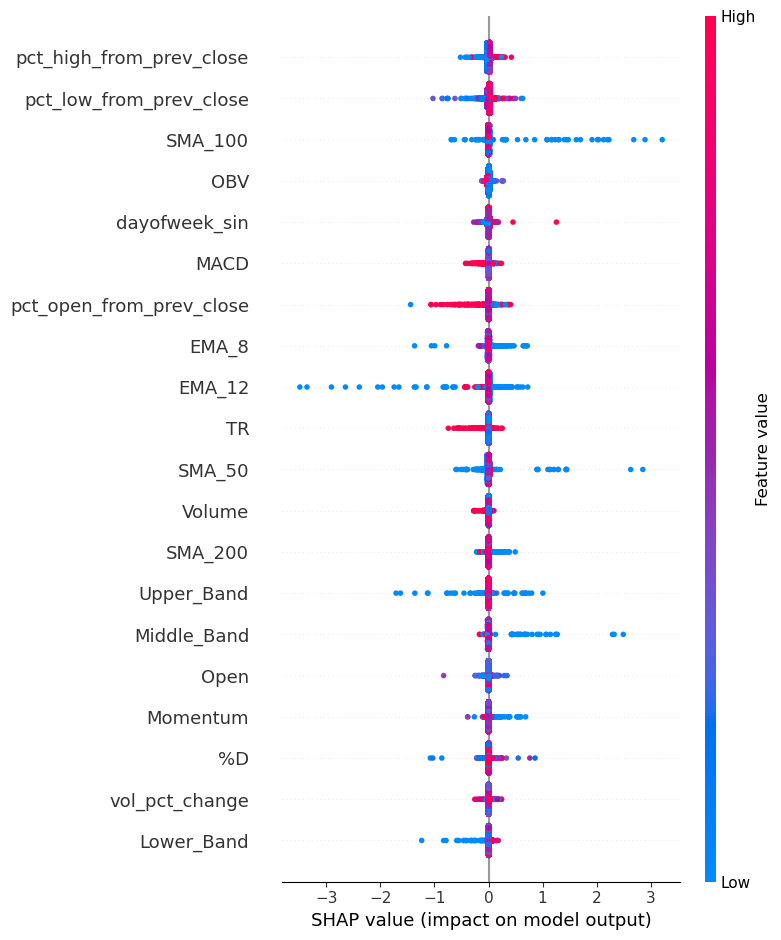

In [35]:
best_params = study.best_params

best_model = xgb.XGBRegressor(objective="reg:squarederror",
                              eval_metric="rmse",
                              random_state=42,
                              n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

r2 = met.r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]

adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
func_list.append(adj_r2)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

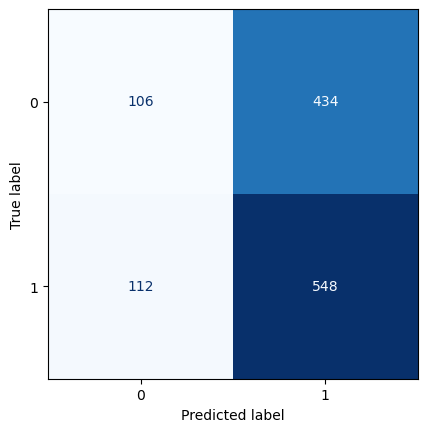

In [36]:
y_pred_classified = (y_pred > 0).astype(int)
y_test_classified = (y_test > 0).astype(int)

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

func_list.append(y_pred)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [37]:
target = "pct_close"

func_list = ["Technical indicators and Other indices with custom loss"]

X = final_df.drop(['pct_close'], axis = 1)
y = final_df[target].values

X_train = X[:-2 * look_back * test_coef]
X_test  = X[-2 * look_back * test_coef:] 

y_train = y[:-2 * look_back * test_coef]
y_test  = y[-2 * look_back * test_coef:]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-09-01 19:29:18,489] A new study created in memory with name: no-name-2b603f11-76ef-48ee-8890-faf26fa8aac4


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-01 19:29:23,613] Trial 0 finished with value: 1.7528916227106424 and parameters: {'n_estimators': 112, 'learning_rate': 0.019454938363368087, 'max_depth': 8, 'gamma': 0.0047639146111844955}. Best is trial 0 with value: 1.7528916227106424.
[I 2023-09-01 19:29:25,638] Trial 7 finished with value: 1.2557545184413634 and parameters: {'n_estimators': 108, 'learning_rate': 0.0030468450600963847, 'max_depth': 13, 'gamma': 0.008625720133996642}. Best is trial 7 with value: 1.2557545184413634.
[I 2023-09-01 19:29:26,690] Trial 1 finished with value: 1.2392810399701124 and parameters: {'n_estimators': 122, 'learning_rate': 0.00611670877172124, 'max_depth': 13, 'gamma': 0.019574170898963086}. Best is trial 1 with value: 1.2392810399701124.
[I 2023-09-01 19:29:27,451] Trial 2 finished with value: 1.3767835793708982 and parameters: {'n_estimators': 236, 'learning_rate': 0.004863897628210713, 'max_depth': 8, 'gamma': 0.01066169394461727}. Best is trial 1 with value: 1.2392810399701124.
[I

[I 2023-09-01 19:30:16,337] Trial 38 finished with value: 1.2406738720380421 and parameters: {'n_estimators': 142, 'learning_rate': 0.0010590002607264277, 'max_depth': 14, 'gamma': 0.015367675307827181}. Best is trial 27 with value: 1.2289165813570941.
[I 2023-09-01 19:30:16,358] Trial 37 finished with value: 1.239629274450724 and parameters: {'n_estimators': 144, 'learning_rate': 0.0011022443129867473, 'max_depth': 14, 'gamma': 0.01525388503210142}. Best is trial 27 with value: 1.2289165813570941.
[I 2023-09-01 19:30:16,499] Trial 36 finished with value: 1.237234198317343 and parameters: {'n_estimators': 148, 'learning_rate': 0.0012289814211954263, 'max_depth': 14, 'gamma': 0.019990432737108887}. Best is trial 27 with value: 1.2289165813570941.
[I 2023-09-01 19:30:16,648] Trial 32 finished with value: 1.9357015432242948 and parameters: {'n_estimators': 188, 'learning_rate': 0.011336875076318555, 'max_depth': 14, 'gamma': 0.006377865248583008}. Best is trial 27 with value: 1.2289165813

[I 2023-09-01 19:30:56,032] Trial 67 finished with value: 1.247076748797204 and parameters: {'n_estimators': 158, 'learning_rate': 0.0034200607029958754, 'max_depth': 12, 'gamma': 0.01901503881719346}. Best is trial 27 with value: 1.2289165813570941.
[I 2023-09-01 19:30:56,294] Trial 68 finished with value: 1.2885257766040725 and parameters: {'n_estimators': 159, 'learning_rate': 0.003030220856564928, 'max_depth': 11, 'gamma': 0.01943837402727343}. Best is trial 27 with value: 1.2289165813570941.
[I 2023-09-01 19:31:00,294] Trial 72 finished with value: 1.27441776334909 and parameters: {'n_estimators': 105, 'learning_rate': 0.0023234184611275934, 'max_depth': 11, 'gamma': 0.019612816649616505}. Best is trial 27 with value: 1.2289165813570941.
[I 2023-09-01 19:31:01,020] Trial 69 finished with value: 1.2788904403037193 and parameters: {'n_estimators': 166, 'learning_rate': 0.002549033104501764, 'max_depth': 12, 'gamma': 0.019009934897503473}. Best is trial 27 with value: 1.2289165813570

In [38]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: 1.2289165813570941
Params: 
    n_estimators: 171
    learning_rate: 0.0012405436972645649
    max_depth: 13
    gamma: 0.01937492220460848


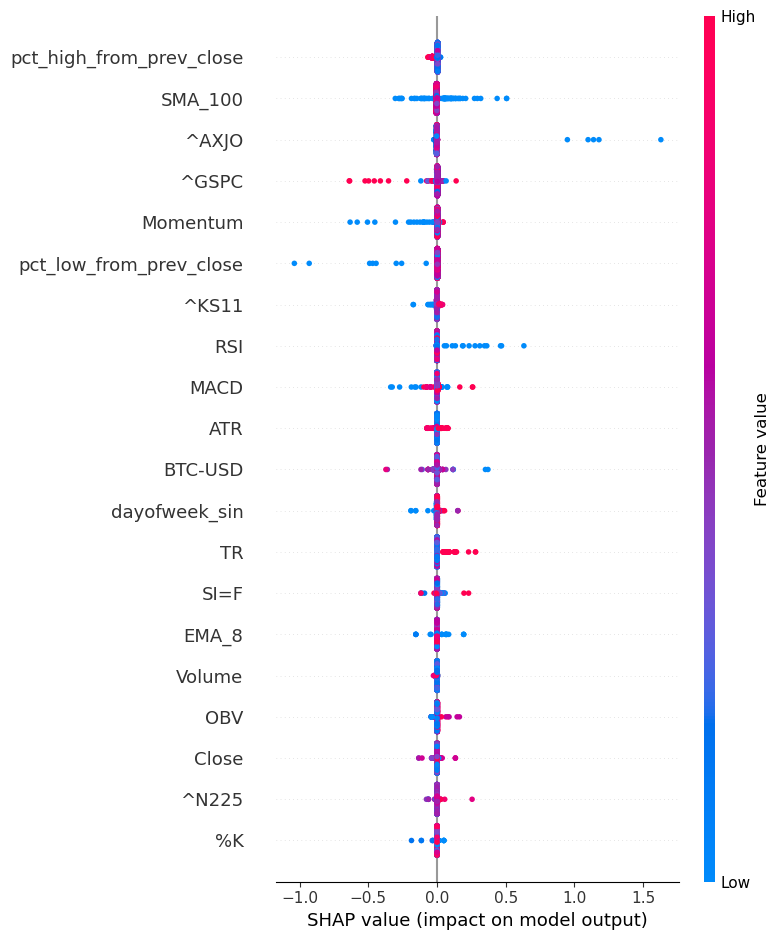

In [39]:
best_params = study.best_params

best_model = xgb.XGBRegressor(objective="reg:squarederror",
                              eval_metric="rmse",
                              random_state=42,
                              n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

r2 = met.r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]

adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
func_list.append(adj_r2)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

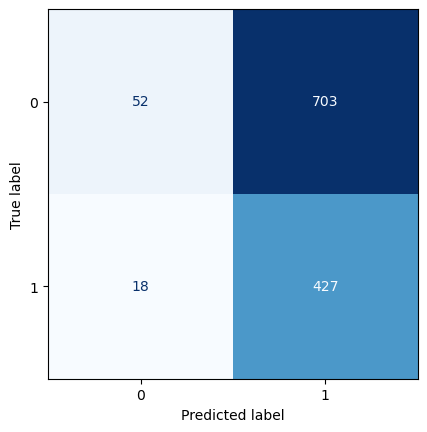

In [40]:
y_pred_classified = (y_pred > 0).astype(int)
y_test_classified = (y_test > 0).astype(int)

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

func_list.append(y_pred)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [41]:
target = "pct_close"

func_list = ["Technical indicators, Other indices and Feature engine with custom loss"]

X = final_df.drop(['pct_close'], axis = 1)
y = final_df[target].values

X_train = X[:-2 * look_back * test_coef]
X_test  = X[-2 * look_back * test_coef:] 

y_train = y[:-2 * look_back * test_coef]
y_test  = y[-2 * look_back * test_coef:]

columns_with_outliers = ['Volume', 'SMA_50', 'SMA_100', 'SMA_200', 'Momentum', 'EMA_8', 'EMA_12', 'EMA_26', 'MACD',\
                         'Signal_Line', 'TR', 'ATR', 'Middle_Band', 'Upper_Band', 'Lower_Band', 'vol_pct_change']
columns_to_log_transform = ['Volume', 'Momentum', 'TR', 'ATR', 'OBV', 'Upper_Band', 'Lower_Band', 'vol_pct_change']

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.05)
    max_depth = trial.suggest_int('max_depth', 8, 15)
    gamma = trial.suggest_float('gamma', 0.001, 0.02)
    
    pipeline = pip.Pipeline([
        ('log_transform', LogTransformer(columns=columns_to_log_transform)),
        ('winsorizer', fout.Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=columns_with_outliers)),
        ('scaler', pre.MinMaxScaler()),
        ('drop_duplicate', fsel.DropDuplicateFeatures()),
        ('drop_correlated', fsel.DropCorrelatedFeatures()),
        ('drop_constant', fsel.DropConstantFeatures(tol=0.998)),
        ('rfa', fsel.RecursiveFeatureAddition(estimator=xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse"), scoring="r2")),
        ('regressor', xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", random_state=42, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, gamma=gamma))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return custom_loss_numpy(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-09-01 19:31:25,248] A new study created in memory with name: no-name-3816a8d1-3e56-4b59-8951-c4258744e482


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-01 19:32:44,544] Trial 0 finished with value: 1.686821270170961 and parameters: {'n_estimators': 150, 'learning_rate': 0.04660653189053041, 'max_depth': 8, 'gamma': 0.010558296475642628}. Best is trial 0 with value: 1.686821270170961.
[I 2023-09-01 19:32:45,389] Trial 1 finished with value: 1.2755673073127458 and parameters: {'n_estimators': 229, 'learning_rate': 0.007234894237817996, 'max_depth': 8, 'gamma': 0.005498453597500337}. Best is trial 1 with value: 1.2755673073127458.
[I 2023-09-01 19:32:45,834] Trial 3 finished with value: 1.5618273380209091 and parameters: {'n_estimators': 120, 'learning_rate': 0.04380560422181986, 'max_depth': 8, 'gamma': 0.019724578198631854}. Best is trial 1 with value: 1.2755673073127458.
[I 2023-09-01 19:32:47,208] Trial 10 finished with value: 1.8836684021129775 and parameters: {'n_estimators': 172, 'learning_rate': 0.04722289454842469, 'max_depth': 10, 'gamma': 0.009387817900240788}. Best is trial 1 with value: 1.2755673073127458.
[I 2023

[I 2023-09-01 19:35:39,077] Trial 33 finished with value: 1.4211859860928895 and parameters: {'n_estimators': 196, 'learning_rate': 0.007109245569489134, 'max_depth': 9, 'gamma': 0.0067689871289149895}. Best is trial 14 with value: 1.1749906536818473.
[I 2023-09-01 19:35:42,163] Trial 34 finished with value: 1.3862828387478692 and parameters: {'n_estimators': 196, 'learning_rate': 0.006243819804614066, 'max_depth': 9, 'gamma': 0.007525268607894442}. Best is trial 14 with value: 1.1749906536818473.
[I 2023-09-01 19:35:43,825] Trial 35 finished with value: 1.400433161416808 and parameters: {'n_estimators': 189, 'learning_rate': 0.0063528359293321245, 'max_depth': 9, 'gamma': 0.007109711340455127}. Best is trial 14 with value: 1.1749906536818473.
[I 2023-09-01 19:36:52,485] Trial 38 finished with value: 1.3491219867575404 and parameters: {'n_estimators': 103, 'learning_rate': 0.006696022861674915, 'max_depth': 9, 'gamma': 0.008180018854951362}. Best is trial 14 with value: 1.1749906536818

[I 2023-09-01 19:39:46,221] Trial 67 finished with value: 1.2450196089588401 and parameters: {'n_estimators': 124, 'learning_rate': 0.014121304550741759, 'max_depth': 8, 'gamma': 0.004061524364948662}. Best is trial 60 with value: 1.153481923538252.
[I 2023-09-01 19:39:46,343] Trial 69 finished with value: 1.2684750397511872 and parameters: {'n_estimators': 125, 'learning_rate': 0.014341875272109422, 'max_depth': 8, 'gamma': 0.011382393986949844}. Best is trial 60 with value: 1.153481923538252.
[I 2023-09-01 19:39:47,021] Trial 68 finished with value: 1.3642776231707434 and parameters: {'n_estimators': 159, 'learning_rate': 0.01376654057936183, 'max_depth': 8, 'gamma': 0.0038428423503193013}. Best is trial 60 with value: 1.153481923538252.
[I 2023-09-01 19:39:47,278] Trial 66 finished with value: 1.3673322780361032 and parameters: {'n_estimators': 154, 'learning_rate': 0.013800577706435961, 'max_depth': 8, 'gamma': 0.009822251419094683}. Best is trial 60 with value: 1.153481923538252.


[I 2023-09-01 19:42:59,616] Trial 98 finished with value: 1.2094759664797026 and parameters: {'n_estimators': 146, 'learning_rate': 0.00841674518305919, 'max_depth': 8, 'gamma': 0.004456249555422572}. Best is trial 60 with value: 1.153481923538252.


In [42]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: 1.153481923538252
Params: 
    n_estimators: 138
    learning_rate: 0.004436259002714309
    max_depth: 8
    gamma: 0.00404790639189605


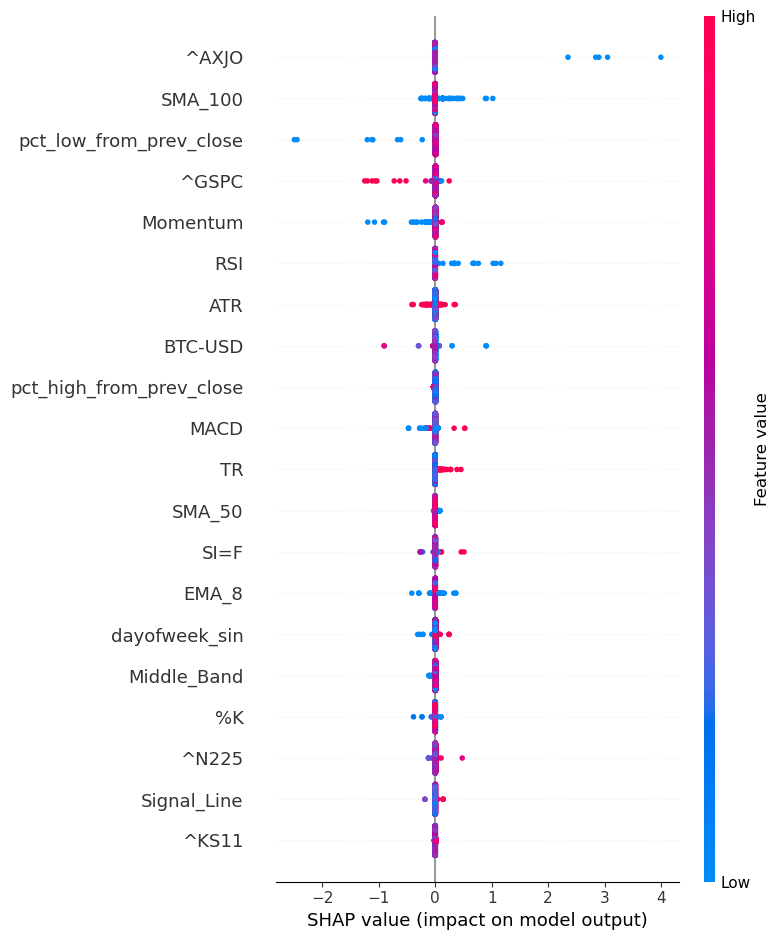

In [43]:
best_params = study.best_params

best_model = xgb.XGBRegressor(objective="reg:squarederror",
                              eval_metric="rmse",
                              random_state=42,
                              n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

r2 = met.r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]

adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
func_list.append(adj_r2)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

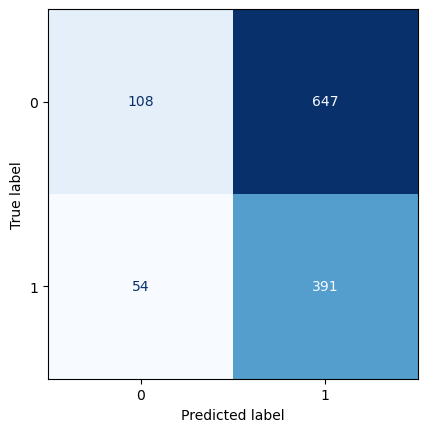

In [44]:
y_pred_classified = (y_pred > 0).astype(int)
y_test_classified = (y_test > 0).astype(int)

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

func_list.append(y_pred)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [45]:
df_results_base = pd.DataFrame(explanations, columns=["Explanation", "RMSE", "Best Params", "Adj-R2", "TN", "FP", "FN", "TP", "Accuracy", "Precision", "Recall", "F1", "y_pred"])
df_results_base.iloc[:, :-1]

Explanation      RMSE  \
0                          Only technical indicators  1.647139   
1             Technical indicators and Other indices  1.316052   
2  Technical indicators, Other indices and Featur...  1.321800   
3         Only technical indicators with custom loss  1.575115   
4  Technical indicators and Other indices with cu...  1.228917   
5  Technical indicators, Other indices and Featur...  1.153482   

                                         Best Params    Adj-R2   TN   FP   FN  \
0  {'n_estimators': 258, 'learning_rate': 0.00386... -0.052382  113  427  111   
1  {'n_estimators': 108, 'learning_rate': 0.00153... -0.147019   52  703   18   
2  {'n_estimators': 364, 'learning_rate': 0.00107... -0.139854   53  702   22   
3  {'n_estimators': 259, 'learning_rate': 0.00347... -0.060085  106  434  112   
4  {'n_estimators': 171, 'learning_rate': 0.00124... -0.144862   52  703   18   
5  {'n_estimators': 138, 'learning_rate': 0.00443... -0.161717  108  647   54   

    TP  Accuracy  Precision    Recall        F1  
0  549  0.551667   0.562500  0.831818  0.671149  
1  427  0.399167   0.377876  0.959551  0.542222  
2  423  0.396667   0.376000  0.950562  0.538854  
3  548  0.545000   0.558045  0.830303  0.667479  
4  427  0.399167   0.377876  0.959551  0.542222  
5  391  0.415833   0.376686  0.878652  0.527310

In [46]:
def profit(df, y_pred):
    df = df[-len(y_pred):]
    actual_change = df["pct_close"].values
    high = df["pct_high_from_prev_close"].values
    low = df["pct_low_from_prev_close"].values
    
    profit = 0
    daily_profit = []
    cumulative_profit = []
    compounded_profit = 1
    compounded_profit_list = []

    for idx, i in enumerate(y_pred):
        daily = 0
        if i > 0:
            if actual_change[idx] > 0:
                daily = min(abs(i), abs(actual_change[idx]))
            else:
                if high[idx] >= abs(i):
                    daily = abs(i)
                else:
                    daily = -abs(actual_change[idx])
        else:
            if actual_change[idx] < 0:
                daily = min(abs(i), abs(actual_change[idx]))
            else:
                if low[idx] <= abs(i):
                    daily = abs(i)
                else:
                    daily = -abs(actual_change[idx])
        
        daily_profit.append(daily)
        profit += daily
        cumulative_profit.append(profit)

        compounded_profit *= (1 + daily / 100)
        compounded_profit_list.append((compounded_profit - 1) * 100)

    profit_df = pd.DataFrame({
        'daily_profit': daily_profit,
        'Cumulative Profit': cumulative_profit,
        'Compounded Profit': compounded_profit_list
    }, index=df.index)

    return profit, profit_df

def loss(df, y_pred):
    df = df[-len(y_pred):]
    actual_change = df["pct_close"].values
    high = df["pct_high_from_prev_close"].values
    low = df["pct_low_from_prev_close"].values
    
    loss_days = []

    for idx, i in enumerate(y_pred):
        
        if i > 0:
            if actual_change[idx] > 0:
                loss_days.append(0)
            else:
                if high[idx] >= abs(i):
                    loss_days.append(0)
                else:
                    loss_days.append(1)
        else:
            if actual_change[idx] < 0:
                loss_days.append(0)
            else:
                if low[idx] <= abs(i):
                    loss_days.append(0)
                else:
                    loss_days.append(1)
    return loss_days

def plot_loss_days(df, loss_arr, ticker):
   
    fig, ax = plt.subplots(figsize=(12, 5))
    bar_df = df[-len(loss_arr):]
    bar_df["loss"] = np.array(loss_arr)
    color = ["green" if close_price >= open_price else "red" for close_price, open_price in zip(bar_df["Close"], bar_df["Open"])]
    candlesticks = ax.bar(x=bar_df.index, height=np.abs(bar_df["Open"] - bar_df["Close"]), bottom=np.min((bar_df["Open"], bar_df["Close"]), axis=0), color=color, width=0.6, align='center')
    ax.vlines(x=bar_df.index, ymin=bar_df["Low"], ymax=bar_df["High"], color=color)
    
    errors = pd.Series(loss_arr, index=df[-len(loss_arr):].index)
    for idx in bar_df.index:
        if bar_df.loc[idx, 'loss'] == 1:
            ax.axvline(x=idx, color='red', linestyle='dotted', label='Loss Days' if 'Loss Days' not in [l.get_label() for l in ax.lines] else "")
    
    ax.legend()

    ax.set_xlabel('Time')
    ax.set_ylabel(f'{ticker} Closing Price')
    ax.set_title(f'Number of Trading Days with\nLoss: {sum(loss_arr)}, Profit: {len(loss_arr) - sum(loss_arr)}')
    plt.tight_layout()
    plt.show()

## Maximize

In [47]:
def custom_loss_numpy_maximize(y_true, y_pred):
    signs_match = np.sign(y_true) == np.sign(y_pred)
    error = np.where(signs_match, (y_true - y_pred) ** 2, -(y_true - y_pred) ** 2)
    loss = np.mean(error)
    return loss

In [48]:
target = "pct_close"

func_list = ["Only technical indicators with custom loss (maximize)"]

look_back = 30
test_coef = 20

X = df_NASDAQ_technical.drop(['pct_close'], axis = 1)
y = df_NASDAQ_technical[target].values

X_train = X[:-2 * look_back * test_coef]
X_test  = X[-2 * look_back * test_coef:] 

y_train = y[:-2 * look_back * test_coef]
y_test  = y[-2 * look_back * test_coef:]

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.05)
    max_depth = trial.suggest_int('max_depth', 8, 15)
    gamma = trial.suggest_float('gamma', 0.001, 0.02)
    
    pipeline = pip.Pipeline([
        ('log_transform', LogTransformer(columns=columns_to_log_transform)),
        ("scaler", pre.MinMaxScaler()),
        ("regressor", xgb.XGBRegressor(objective="reg:squarederror",
                                       eval_metric="rmse",
                                       random_state=42,
                                       n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                       gamma=gamma))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return custom_loss_numpy_maximize(y_test, y_pred) 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-09-01 19:43:01,770] A new study created in memory with name: no-name-5d298d78-7cee-4fe8-a3ab-c6b6dc70291a


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-01 19:43:20,942] Trial 10 finished with value: -0.6268155717663036 and parameters: {'n_estimators': 138, 'learning_rate': 0.005153600350978344, 'max_depth': 10, 'gamma': 0.00215066366286323}. Best is trial 10 with value: -0.6268155717663036.
[I 2023-09-01 19:43:26,352] Trial 1 finished with value: -0.6596986795269206 and parameters: {'n_estimators': 141, 'learning_rate': 0.011024183424963033, 'max_depth': 11, 'gamma': 0.014609389025932971}. Best is trial 10 with value: -0.6268155717663036.
[I 2023-09-01 19:43:29,179] Trial 0 finished with value: -0.536530324136865 and parameters: {'n_estimators': 200, 'learning_rate': 0.009160957120400395, 'max_depth': 9, 'gamma': 0.01048312828936453}. Best is trial 0 with value: -0.536530324136865.
[I 2023-09-01 19:43:40,090] Trial 6 finished with value: -0.7176437894486011 and parameters: {'n_estimators': 356, 'learning_rate': 0.0046605821772942625, 'max_depth': 8, 'gamma': 0.008698914383444745}. Best is trial 0 with value: -0.536530324136

[I 2023-09-01 19:45:52,991] Trial 42 finished with value: -0.6906839922245196 and parameters: {'n_estimators': 101, 'learning_rate': 0.005457856248406764, 'max_depth': 10, 'gamma': 0.016714184503227307}. Best is trial 3 with value: -0.46206041438955225.
[I 2023-09-01 19:45:55,493] Trial 43 finished with value: -0.707393448245537 and parameters: {'n_estimators': 104, 'learning_rate': 0.005627918224330172, 'max_depth': 10, 'gamma': 0.01763553448256575}. Best is trial 3 with value: -0.46206041438955225.
[I 2023-09-01 19:45:58,536] Trial 29 finished with value: -1.454607808237472 and parameters: {'n_estimators': 321, 'learning_rate': 0.02131161765553018, 'max_depth': 13, 'gamma': 0.012797334400525561}. Best is trial 3 with value: -0.46206041438955225.
[I 2023-09-01 19:46:03,132] Trial 44 finished with value: -0.6803533274227346 and parameters: {'n_estimators': 100, 'learning_rate': 0.006008389930291436, 'max_depth': 10, 'gamma': 0.016857405017331923}. Best is trial 3 with value: -0.4620604

[I 2023-09-01 19:47:35,384] Trial 62 finished with value: -1.137722776569701 and parameters: {'n_estimators': 239, 'learning_rate': 0.012601839022347756, 'max_depth': 11, 'gamma': 0.001488954314581862}. Best is trial 3 with value: -0.46206041438955225.
[I 2023-09-01 19:47:37,160] Trial 71 finished with value: -0.6228397106240664 and parameters: {'n_estimators': 259, 'learning_rate': 0.0027760852105227453, 'max_depth': 8, 'gamma': 0.003003137930084351}. Best is trial 3 with value: -0.46206041438955225.
[I 2023-09-01 19:47:37,688] Trial 63 finished with value: -1.2211930259776402 and parameters: {'n_estimators': 247, 'learning_rate': 0.013445551148746095, 'max_depth': 11, 'gamma': 0.002274008562926963}. Best is trial 3 with value: -0.46206041438955225.
[I 2023-09-01 19:47:43,742] Trial 68 finished with value: -0.7355664534690757 and parameters: {'n_estimators': 251, 'learning_rate': 0.006386282166862306, 'max_depth': 11, 'gamma': 0.0022818974687303607}. Best is trial 3 with value: -0.462

In [49]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: -0.3743767469813229
Params: 
    n_estimators: 278
    learning_rate: 0.004563381414532124
    max_depth: 9
    gamma: 0.005631205698208353


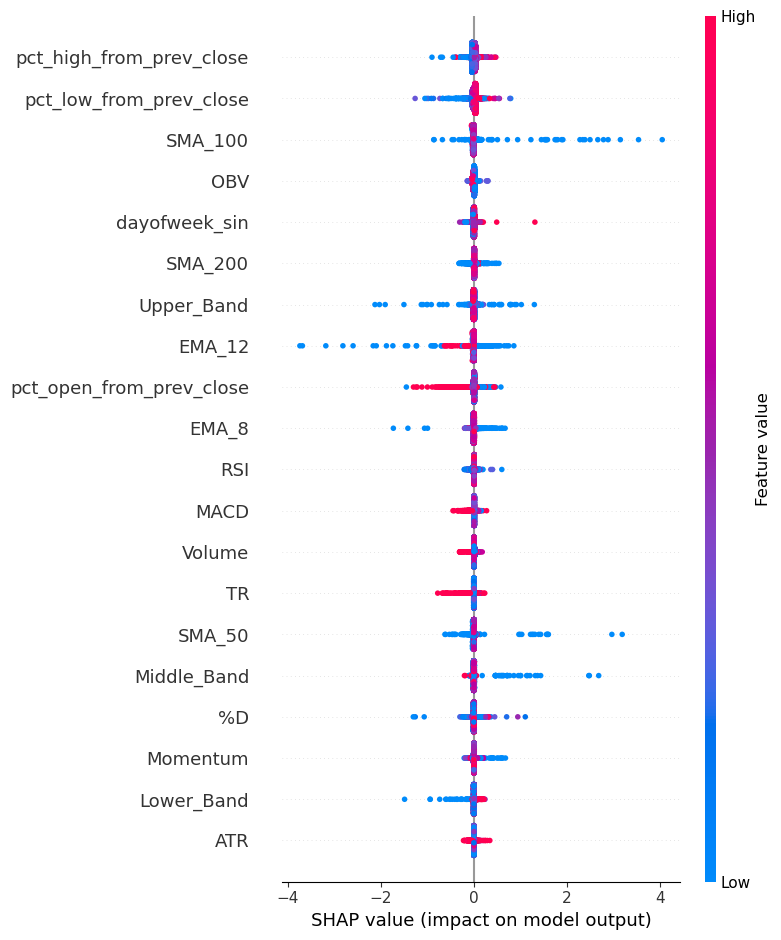

In [50]:
best_params = study.best_params

best_model = xgb.XGBRegressor(objective="reg:squarederror",
                              eval_metric="rmse",
                              random_state=42,
                              n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

r2 = met.r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]

adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
func_list.append(adj_r2)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

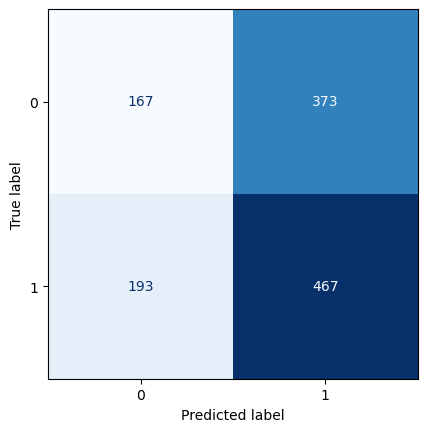

In [51]:
y_pred_classified = (y_pred > 0).astype(int)
y_test_classified = (y_test > 0).astype(int)

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

func_list.append(y_pred)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [52]:
target = "pct_close"

func_list = ["Technical indicators and Other indices with custom loss(maximize)"]

X = final_df.drop(['pct_close'], axis = 1)
y = final_df[target].values

X_train = X[:-2 * look_back * test_coef]
X_test  = X[-2 * look_back * test_coef:] 

y_train = y[:-2 * look_back * test_coef]
y_test  = y[-2 * look_back * test_coef:]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-09-01 19:49:24,653] A new study created in memory with name: no-name-e39290c4-21f3-48a7-95ed-5f584426c8e8


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-01 19:49:30,910] Trial 0 finished with value: -0.8594290247375074 and parameters: {'n_estimators': 120, 'learning_rate': 0.010097324219745955, 'max_depth': 10, 'gamma': 0.018587651948429443}. Best is trial 0 with value: -0.8594290247375074.
[I 2023-09-01 19:49:36,046] Trial 3 finished with value: -1.8223766027465915 and parameters: {'n_estimators': 179, 'learning_rate': 0.023787212590652, 'max_depth': 10, 'gamma': 0.0050895569607740145}. Best is trial 0 with value: -0.8594290247375074.
[I 2023-09-01 19:49:36,973] Trial 5 finished with value: -0.7096812892227061 and parameters: {'n_estimators': 175, 'learning_rate': 0.004347976322800904, 'max_depth': 14, 'gamma': 0.019574837445200888}. Best is trial 5 with value: -0.7096812892227061.
[I 2023-09-01 19:49:38,090] Trial 2 finished with value: -1.96850775547372 and parameters: {'n_estimators': 183, 'learning_rate': 0.04202997911124747, 'max_depth': 10, 'gamma': 0.014846612658172501}. Best is trial 5 with value: -0.709681289222706

[I 2023-09-01 19:50:21,185] Trial 37 finished with value: -1.2409151937319 and parameters: {'n_estimators': 137, 'learning_rate': 0.014899011386473327, 'max_depth': 11, 'gamma': 0.017411456627954538}. Best is trial 27 with value: -0.6823102440635805.
[I 2023-09-01 19:50:21,766] Trial 38 finished with value: -1.1824181230210384 and parameters: {'n_estimators': 128, 'learning_rate': 0.012881594694937337, 'max_depth': 11, 'gamma': 0.018084919913140124}. Best is trial 27 with value: -0.6823102440635805.
[I 2023-09-01 19:50:22,185] Trial 43 finished with value: -0.7190836524100701 and parameters: {'n_estimators': 100, 'learning_rate': 0.008067581463045039, 'max_depth': 11, 'gamma': 0.018245018758455436}. Best is trial 27 with value: -0.6823102440635805.
[I 2023-09-01 19:50:23,515] Trial 40 finished with value: -1.0753229527904857 and parameters: {'n_estimators': 154, 'learning_rate': 0.009444954605485651, 'max_depth': 11, 'gamma': 0.01787967700914474}. Best is trial 27 with value: -0.682310

[I 2023-09-01 19:50:53,165] Trial 69 finished with value: -0.764166935456959 and parameters: {'n_estimators': 114, 'learning_rate': 0.004451838335994184, 'max_depth': 14, 'gamma': 0.013690444757457391}. Best is trial 27 with value: -0.6823102440635805.
[I 2023-09-01 19:50:53,339] Trial 68 finished with value: -0.7972628735412198 and parameters: {'n_estimators': 117, 'learning_rate': 0.003684618130350249, 'max_depth': 14, 'gamma': 0.01411796958463708}. Best is trial 27 with value: -0.6823102440635805.
[I 2023-09-01 19:50:54,703] Trial 65 finished with value: -0.6937560461136753 and parameters: {'n_estimators': 193, 'learning_rate': 0.004028836021636988, 'max_depth': 12, 'gamma': 0.016866311947134345}. Best is trial 27 with value: -0.6823102440635805.
[I 2023-09-01 19:50:55,280] Trial 56 finished with value: -1.1411600300273654 and parameters: {'n_estimators': 236, 'learning_rate': 0.005826922654845832, 'max_depth': 14, 'gamma': 0.016249061794601775}. Best is trial 27 with value: -0.6823

[I 2023-09-01 19:51:34,237] Trial 98 finished with value: -0.6736520206912904 and parameters: {'n_estimators': 397, 'learning_rate': 0.002167687872544505, 'max_depth': 12, 'gamma': 0.01724445586882663}. Best is trial 98 with value: -0.6736520206912904.


In [53]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: -0.6736520206912904
Params: 
    n_estimators: 397
    learning_rate: 0.002167687872544505
    max_depth: 12
    gamma: 0.01724445586882663


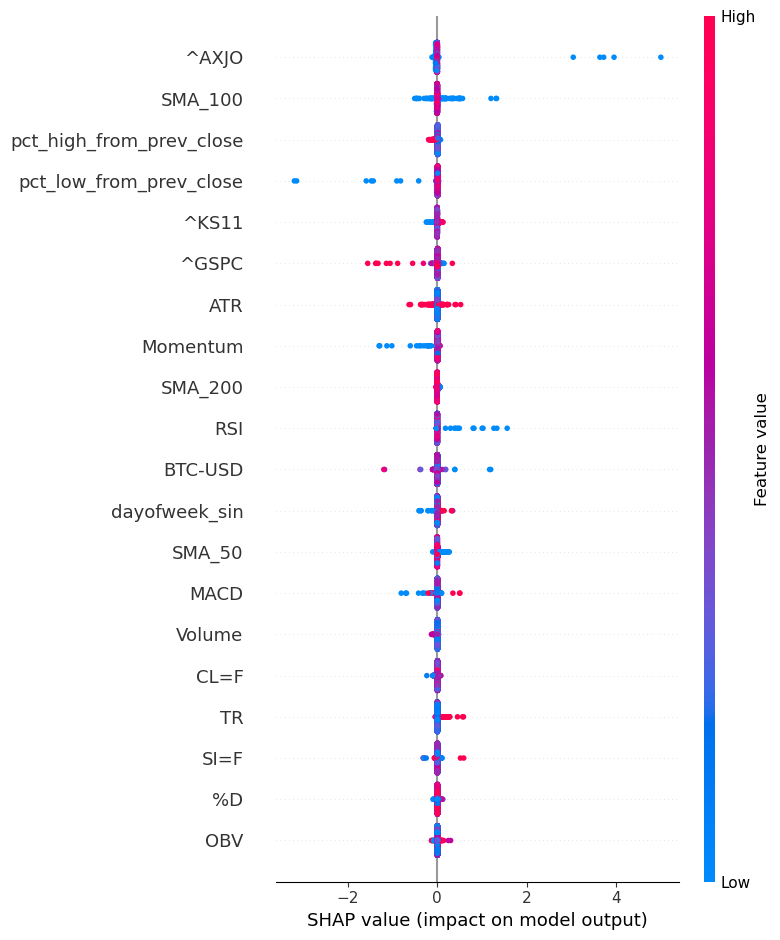

In [54]:
best_params = study.best_params

best_model = xgb.XGBRegressor(objective="reg:squarederror",
                              eval_metric="rmse",
                              random_state=42,
                              n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

r2 = met.r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]

adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
func_list.append(adj_r2)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

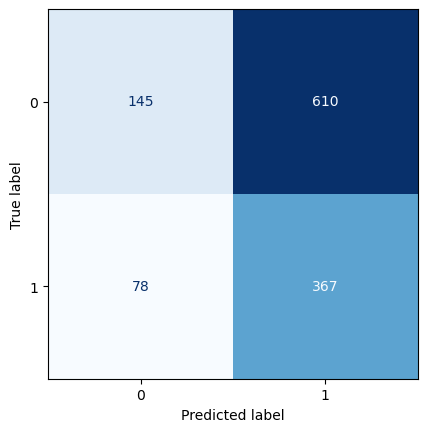

In [55]:
y_pred_classified = (y_pred > 0).astype(int)
y_test_classified = (y_test > 0).astype(int)

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

func_list.append(y_pred)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [56]:
target = "pct_close"

func_list = ["Technical indicators, Other indices and Feature engine with custom loss(maximize)"]

X = final_df.drop(['pct_close'], axis = 1)
y = final_df[target].values

X_train = X[:-2 * look_back * test_coef]
X_test  = X[-2 * look_back * test_coef:] 

y_train = y[:-2 * look_back * test_coef]
y_test  = y[-2 * look_back * test_coef:]

columns_with_outliers = ['Volume', 'SMA_50', 'SMA_100', 'SMA_200', 'Momentum', 'EMA_8', 'EMA_12', 'EMA_26', 'MACD',\
                         'Signal_Line', 'TR', 'ATR', 'Middle_Band', 'Upper_Band', 'Lower_Band', 'vol_pct_change']
columns_to_log_transform = ['Volume', 'Momentum', 'TR', 'ATR', 'OBV', 'Upper_Band', 'Lower_Band', 'vol_pct_change']

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.05)
    max_depth = trial.suggest_int('max_depth', 8, 15)
    gamma = trial.suggest_float('gamma', 0.001, 0.02)
    
    pipeline = pip.Pipeline([
        ('log_transform', LogTransformer(columns=columns_to_log_transform)),
        ('winsorizer', fout.Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=columns_with_outliers)),
        ('scaler', pre.MinMaxScaler()),
        ('drop_duplicate', fsel.DropDuplicateFeatures()),
        ('drop_correlated', fsel.DropCorrelatedFeatures()),
        ('drop_constant', fsel.DropConstantFeatures(tol=0.998)),
        ('rfa', fsel.RecursiveFeatureAddition(estimator=xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse"), scoring="r2")),
        ('regressor', xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", random_state=42, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, gamma=gamma))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return custom_loss_numpy_maximize(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs= -1, show_progress_bar=True)

[I 2023-09-01 19:51:41,787] A new study created in memory with name: no-name-795d5f07-14d8-4f3b-b276-ae70f7345c19


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-09-01 19:53:00,585] Trial 7 finished with value: -0.8459084383519353 and parameters: {'n_estimators': 152, 'learning_rate': 0.016148473033720134, 'max_depth': 8, 'gamma': 0.011613212322592215}. Best is trial 7 with value: -0.8459084383519353.
[I 2023-09-01 19:53:01,434] Trial 0 finished with value: -1.0292864951548877 and parameters: {'n_estimators': 125, 'learning_rate': 0.037834351785808136, 'max_depth': 8, 'gamma': 0.005419446022288142}. Best is trial 7 with value: -0.8459084383519353.
[I 2023-09-01 19:53:02,607] Trial 4 finished with value: -1.0961955449468461 and parameters: {'n_estimators': 117, 'learning_rate': 0.00795323065624132, 'max_depth': 10, 'gamma': 0.006215452250354288}. Best is trial 7 with value: -0.8459084383519353.
[I 2023-09-01 19:53:03,081] Trial 8 finished with value: -1.4297061487077556 and parameters: {'n_estimators': 101, 'learning_rate': 0.03572117615670655, 'max_depth': 13, 'gamma': 0.003049748691935059}. Best is trial 7 with value: -0.84590843835193

[I 2023-09-01 19:55:56,761] Trial 34 finished with value: -0.8901314436410795 and parameters: {'n_estimators': 171, 'learning_rate': 0.0017533666263828153, 'max_depth': 14, 'gamma': 0.009757057845810789}. Best is trial 30 with value: -0.6130455102285256.
[I 2023-09-01 19:55:57,300] Trial 32 finished with value: -0.8528408115370512 and parameters: {'n_estimators': 178, 'learning_rate': 0.0011230135004757116, 'max_depth': 14, 'gamma': 0.009278816695918438}. Best is trial 30 with value: -0.6130455102285256.
[I 2023-09-01 19:56:00,154] Trial 35 finished with value: -0.8532517621646498 and parameters: {'n_estimators': 189, 'learning_rate': 0.002779840355514856, 'max_depth': 14, 'gamma': 0.00884720006792446}. Best is trial 30 with value: -0.6130455102285256.
[I 2023-09-01 19:57:07,719] Trial 36 finished with value: -0.8931851283711312 and parameters: {'n_estimators': 229, 'learning_rate': 0.001341486722303443, 'max_depth': 14, 'gamma': 0.016625497653554738}. Best is trial 30 with value: -0.6

[I 2023-09-01 19:59:58,517] Trial 66 finished with value: -0.8955645244204443 and parameters: {'n_estimators': 110, 'learning_rate': 0.008857447448397641, 'max_depth': 13, 'gamma': 0.012791942096307693}. Best is trial 30 with value: -0.6130455102285256.
[I 2023-09-01 20:00:02,009] Trial 67 finished with value: -1.3545147083560884 and parameters: {'n_estimators': 184, 'learning_rate': 0.010159276503496194, 'max_depth': 13, 'gamma': 0.012859466445289883}. Best is trial 30 with value: -0.6130455102285256.
[I 2023-09-01 20:00:03,498] Trial 69 finished with value: -0.5781662138732905 and parameters: {'n_estimators': 159, 'learning_rate': 0.008874481462824633, 'max_depth': 8, 'gamma': 0.012676902416956008}. Best is trial 69 with value: -0.5781662138732905.
[I 2023-09-01 20:00:04,925] Trial 68 finished with value: -1.3403909354494978 and parameters: {'n_estimators': 182, 'learning_rate': 0.009142990791130047, 'max_depth': 12, 'gamma': 0.012865246674837957}. Best is trial 69 with value: -0.578

In [57]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
func_list.append(trial.value)
func_list.append(trial.params)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
Value: -0.5582595358785378
Params: 
    n_estimators: 184
    learning_rate: 0.003393978590947582
    max_depth: 8
    gamma: 0.01019326997684792


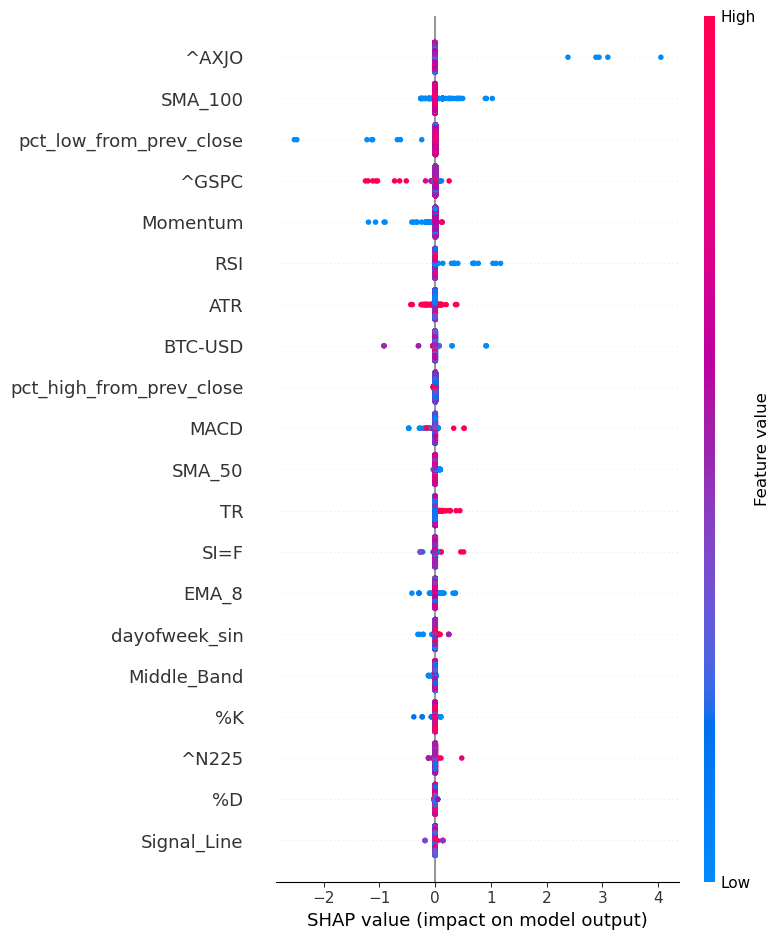

In [58]:
best_params = study.best_params

best_model = xgb.XGBRegressor(objective="reg:squarederror",
                              eval_metric="rmse",
                              random_state=42,
                              n_estimators=best_params['n_estimators'],
                              learning_rate=best_params['learning_rate'],
                              max_depth=best_params['max_depth'],
                              gamma=best_params['gamma'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

r2 = met.r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]

adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)
func_list.append(adj_r2)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

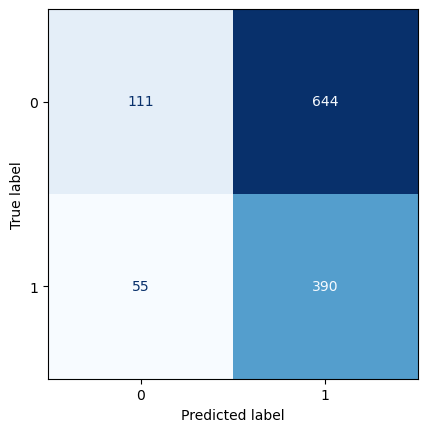

In [59]:
y_pred_classified = (y_pred > 0).astype(int)
y_test_classified = (y_test > 0).astype(int)

cf_matrix = met.confusion_matrix(y_test_classified, y_pred_classified)

TN, FP, FN, TP = cf_matrix.ravel()

func_list.append(TN)
func_list.append(FP)
func_list.append(FN)
func_list.append(TP)

accuracy = met.accuracy_score(y_test_classified, y_pred_classified)
func_list.append(accuracy)
precision = met.precision_score(y_test_classified, y_pred_classified)
func_list.append(precision)
recall = met.recall_score(y_test_classified, y_pred_classified)
func_list.append(recall)
f1 = met.f1_score(y_test_classified, y_pred_classified)
func_list.append(f1)

func_list.append(y_pred)

explanations.append(func_list)

disp = met.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

In [60]:
df_results_base = pd.DataFrame(explanations, columns=["Explanation", "RMSE", "Best Params", "Adj-R2", "TN", "FP", "FN", "TP", "Accuracy", "Precision", "Recall", "F1", "y_pred"])
df_results_base.iloc[:, :-1]

Explanation      RMSE  \
0                          Only technical indicators  1.647139   
1             Technical indicators and Other indices  1.316052   
2  Technical indicators, Other indices and Featur...  1.321800   
3         Only technical indicators with custom loss  1.575115   
4  Technical indicators and Other indices with cu...  1.228917   
5  Technical indicators, Other indices and Featur...  1.153482   
6  Only technical indicators with custom loss (ma... -0.374377   
7  Technical indicators and Other indices with cu... -0.673652   
8  Technical indicators, Other indices and Featur... -0.558260   

                                         Best Params    Adj-R2   TN   FP   FN  \
0  {'n_estimators': 258, 'learning_rate': 0.00386... -0.052382  113  427  111   
1  {'n_estimators': 108, 'learning_rate': 0.00153... -0.147019   52  703   18   
2  {'n_estimators': 364, 'learning_rate': 0.00107... -0.139854   53  702   22   
3  {'n_estimators': 259, 'learning_rate': 0.00347... -0.060085  106  434  112   
4  {'n_estimators': 171, 'learning_rate': 0.00124... -0.144862   52  703   18   
5  {'n_estimators': 138, 'learning_rate': 0.00443... -0.161717  108  647   54   
6  {'n_estimators': 278, 'learning_rate': 0.00456... -0.068961  167  373  193   
7  {'n_estimators': 397, 'learning_rate': 0.00216... -0.213219  145  610   78   
8  {'n_estimators': 184, 'learning_rate': 0.00339... -0.163002  111  644   55   

    TP  Accuracy  Precision    Recall        F1  
0  549  0.551667   0.562500  0.831818  0.671149  
1  427  0.399167   0.377876  0.959551  0.542222  
2  423  0.396667   0.376000  0.950562  0.538854  
3  548  0.545000   0.558045  0.830303  0.667479  
4  427  0.399167   0.377876  0.959551  0.542222  
5  391  0.415833   0.376686  0.878652  0.527310  
6  467  0.528333   0.555952  0.707576  0.622667  
7  367  0.426667   0.375640  0.824719  0.516174  
8  390  0.417500   0.377176  0.876404  0.527383

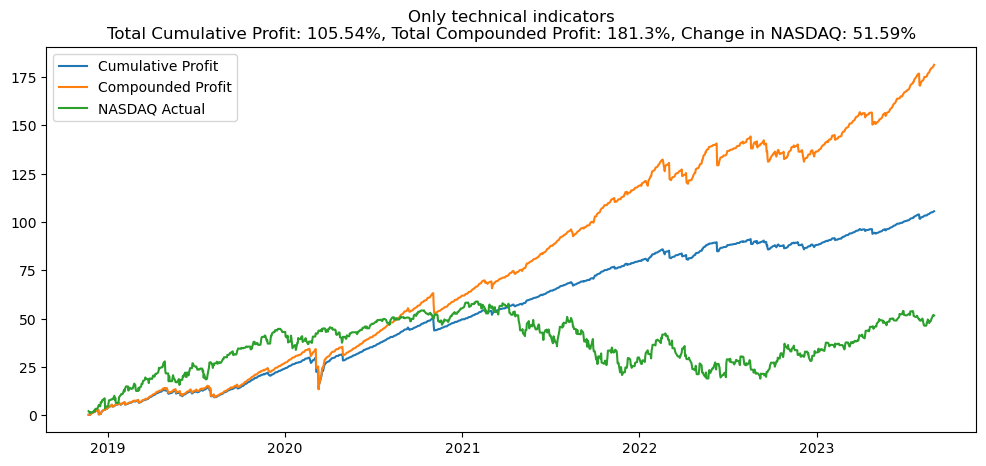

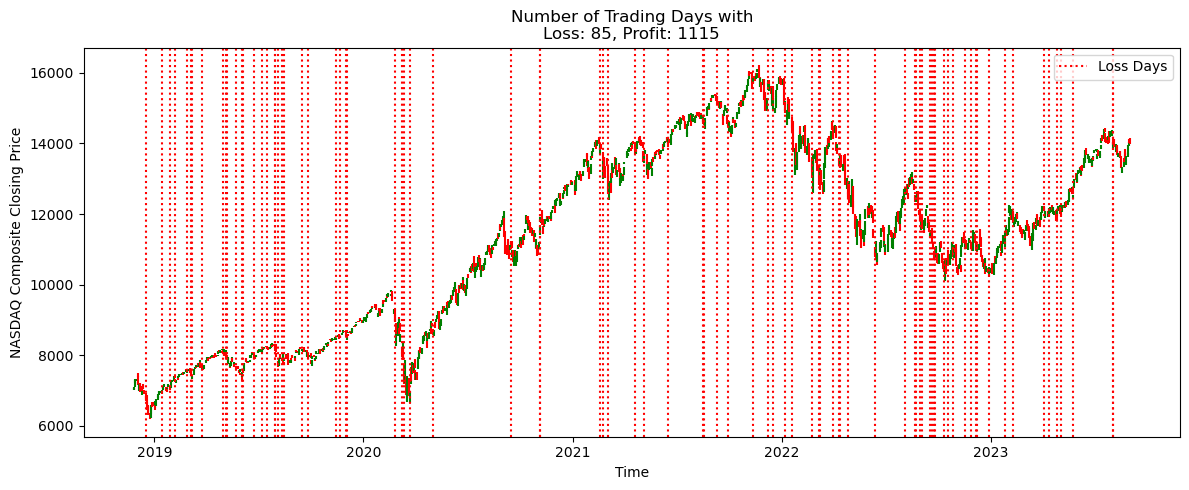

---------------


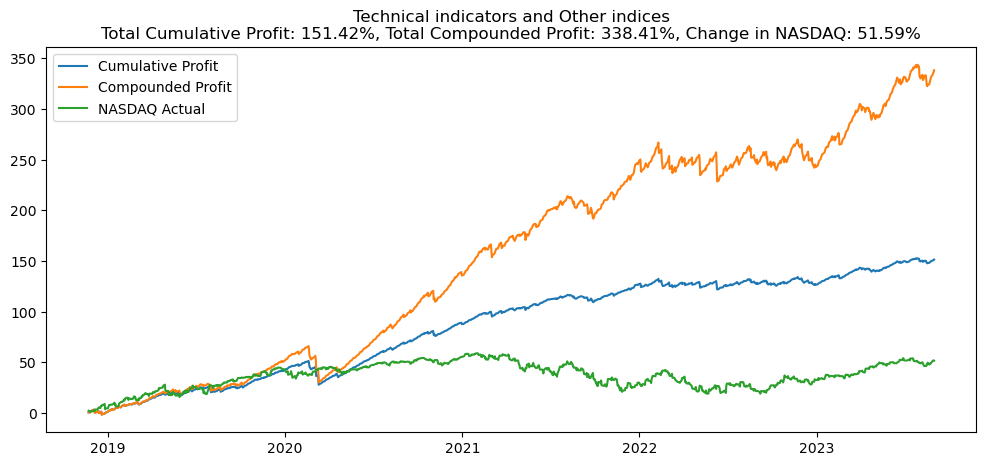

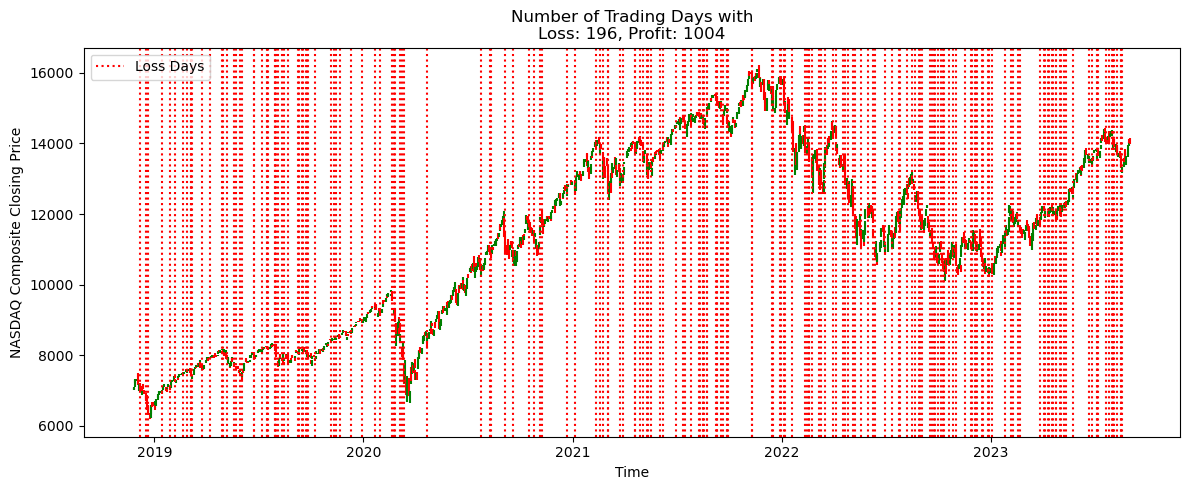

---------------


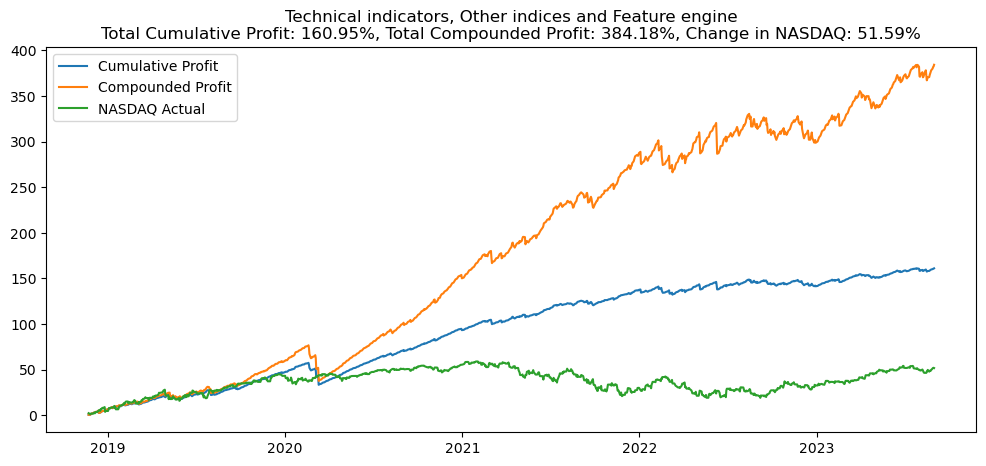

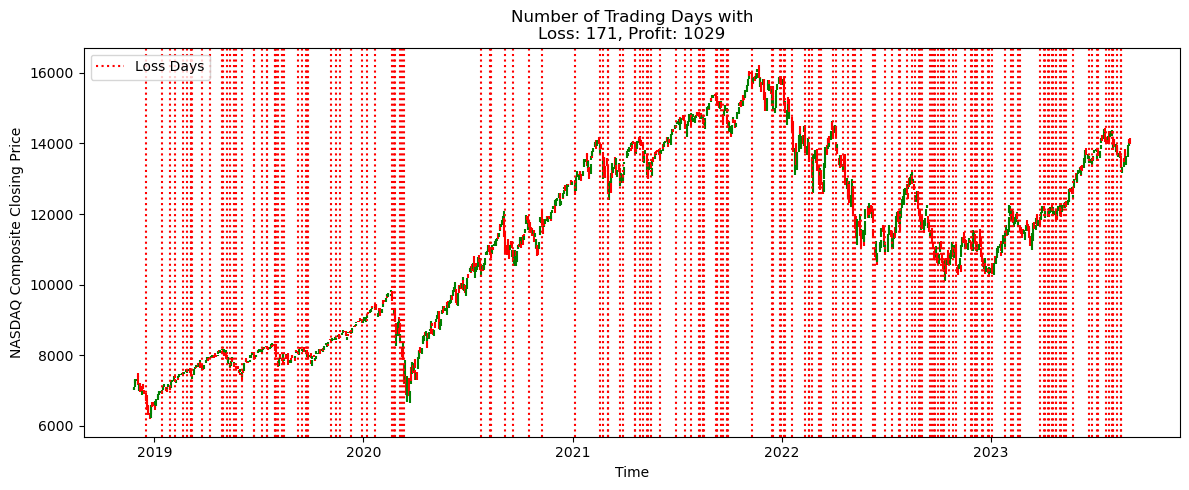

---------------


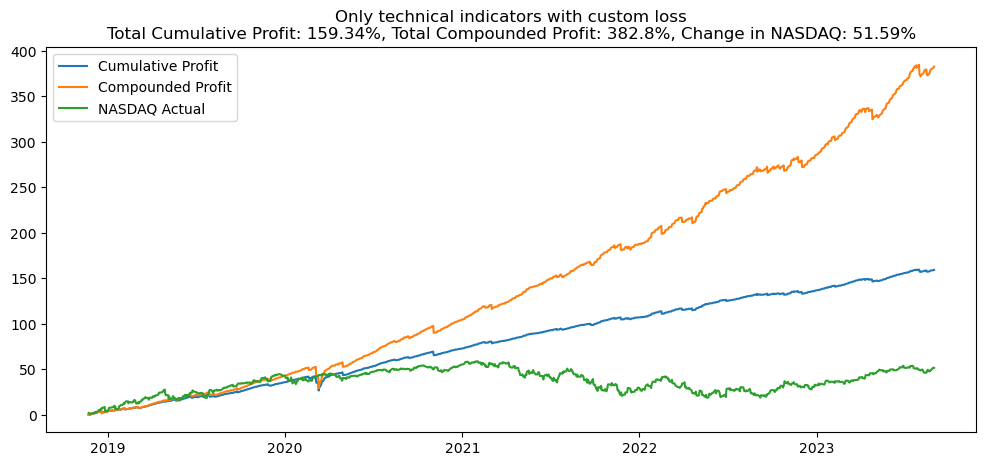

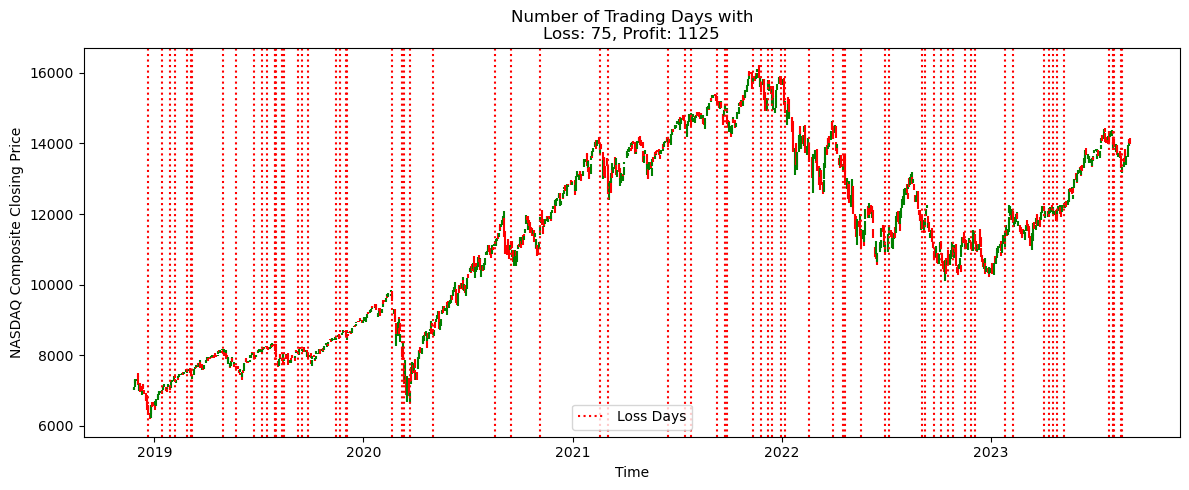

---------------


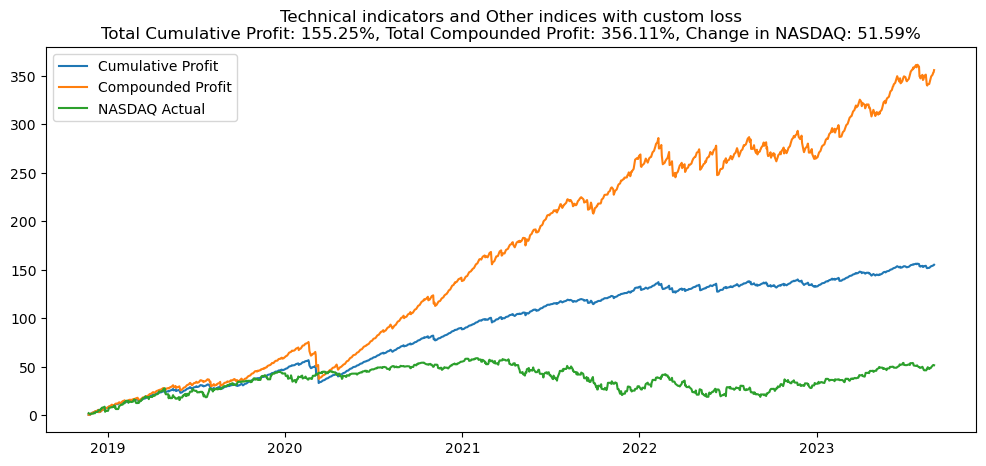

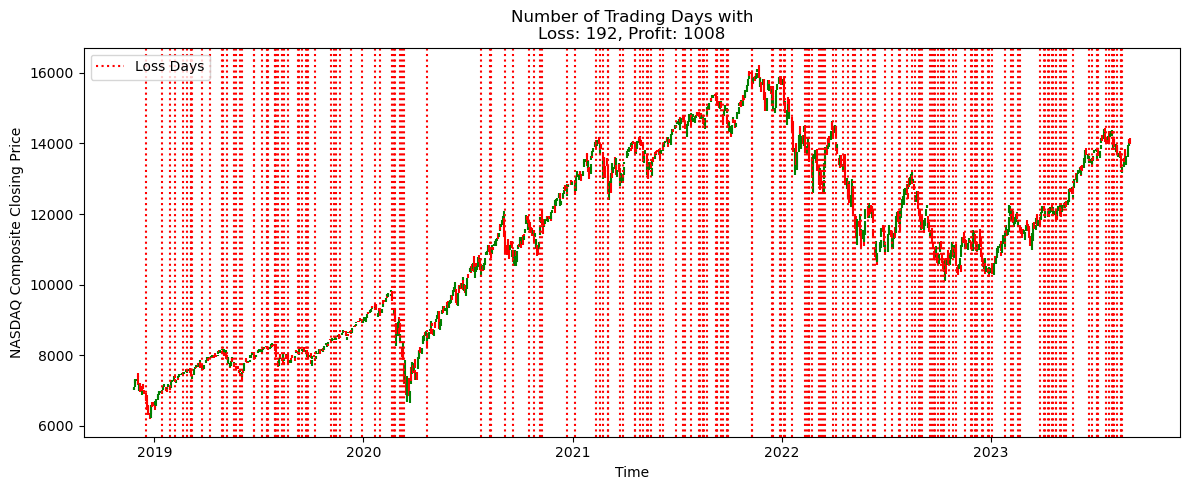

---------------


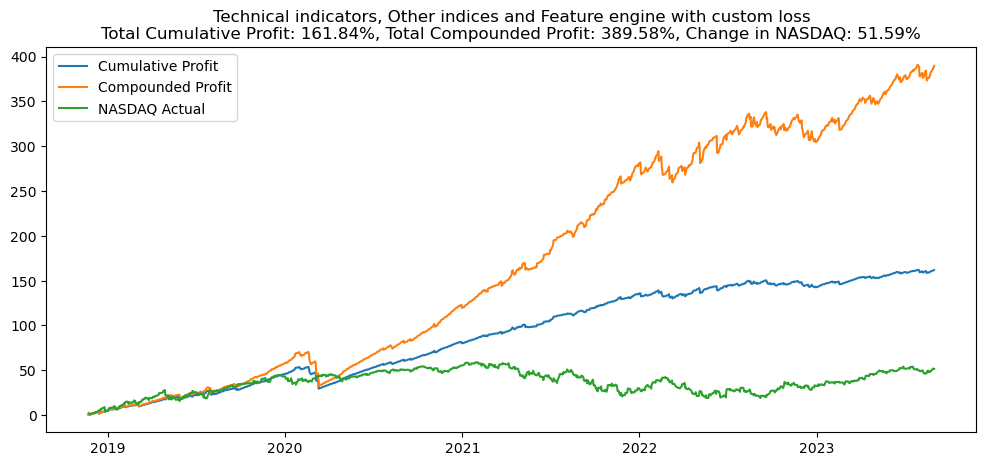

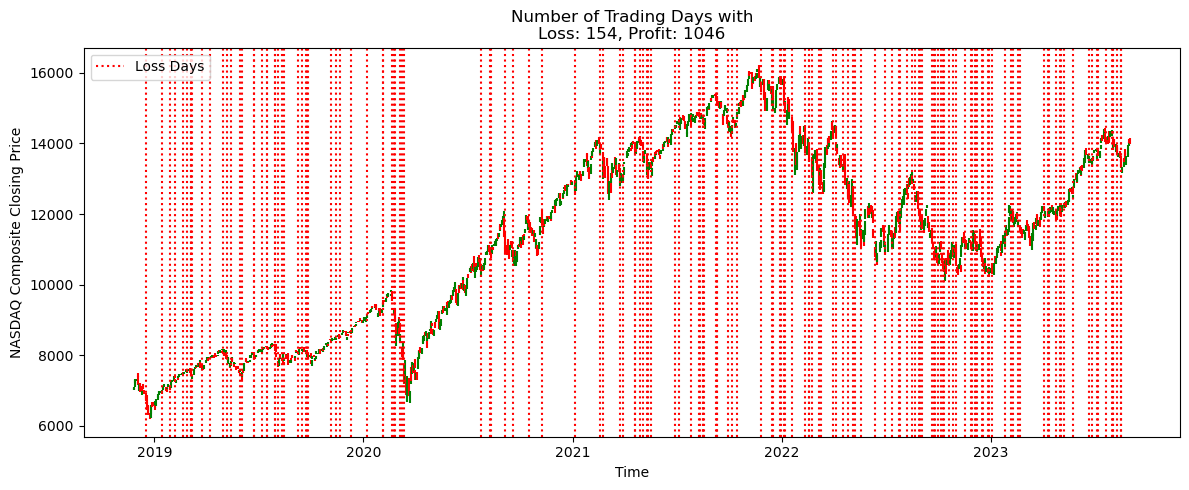

---------------


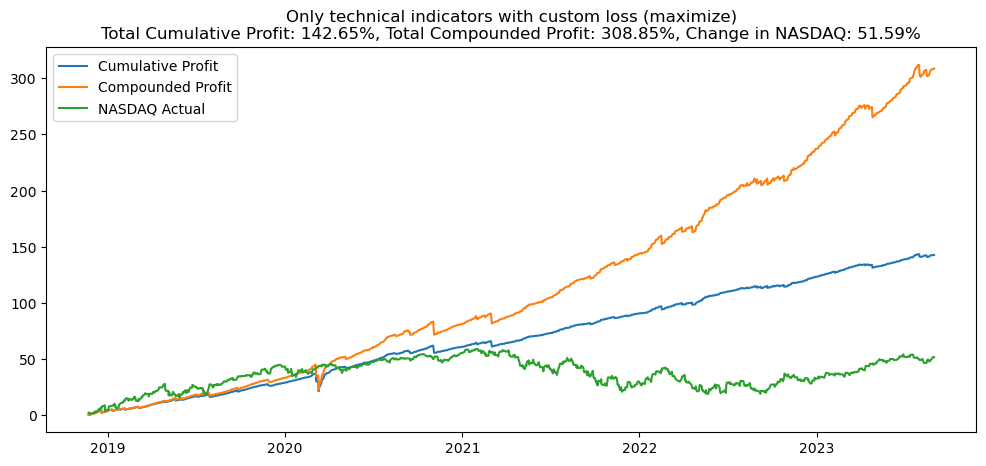

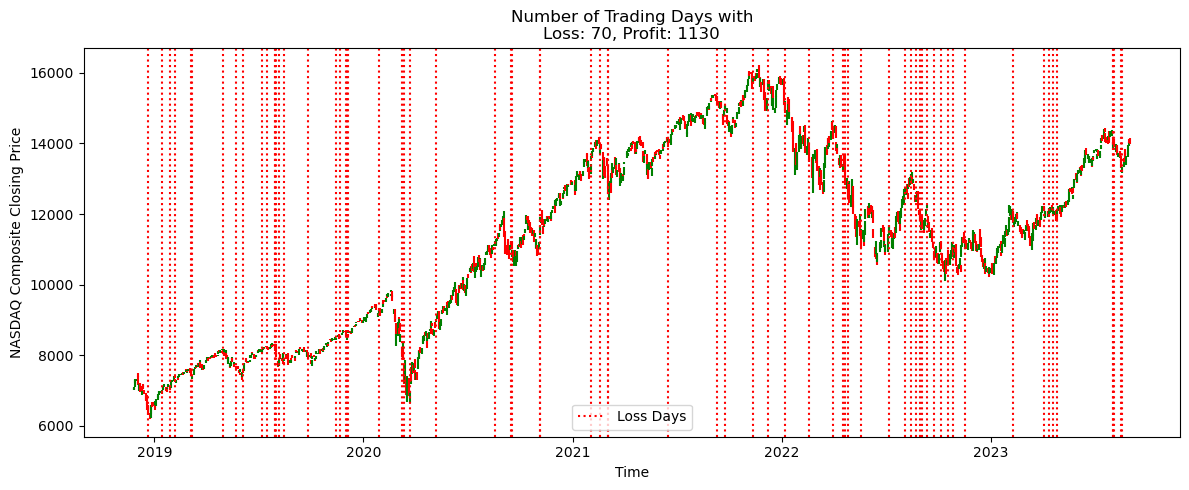

---------------


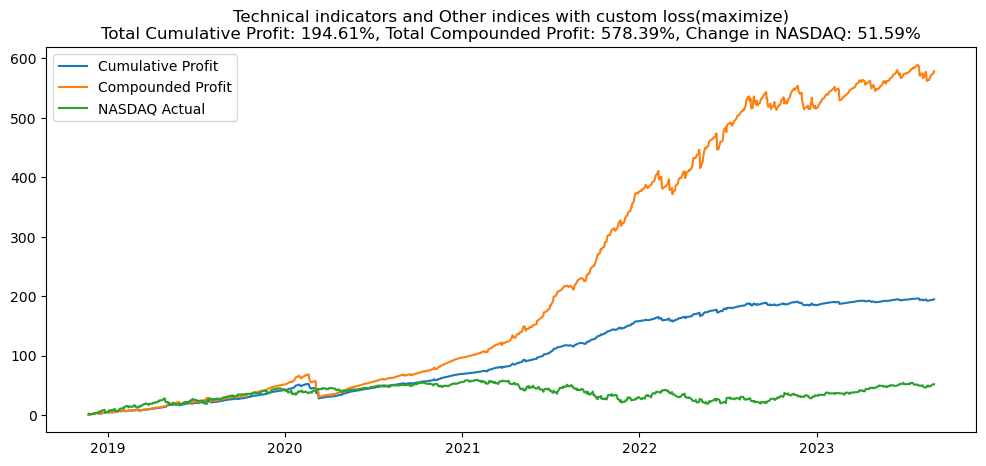

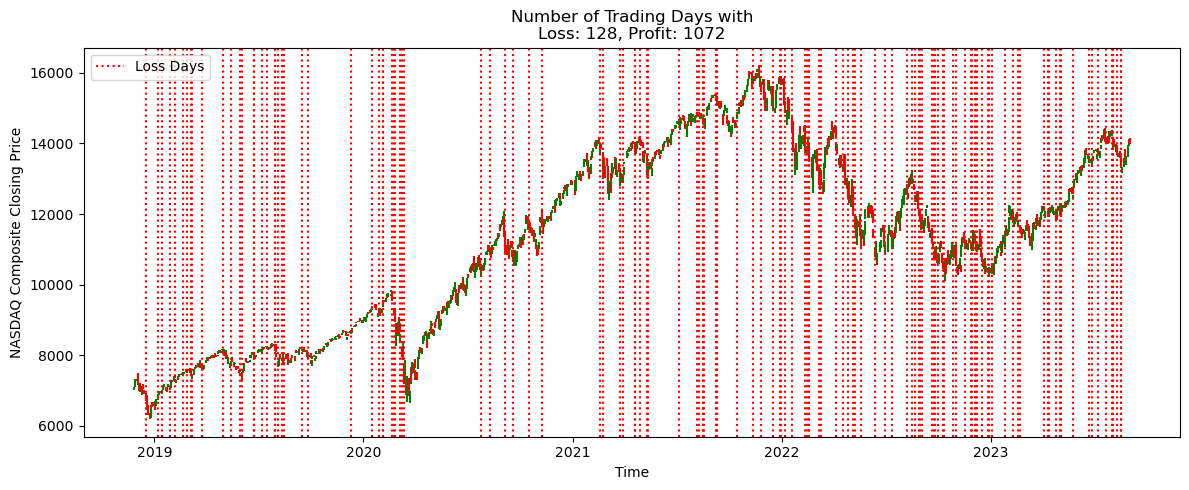

---------------


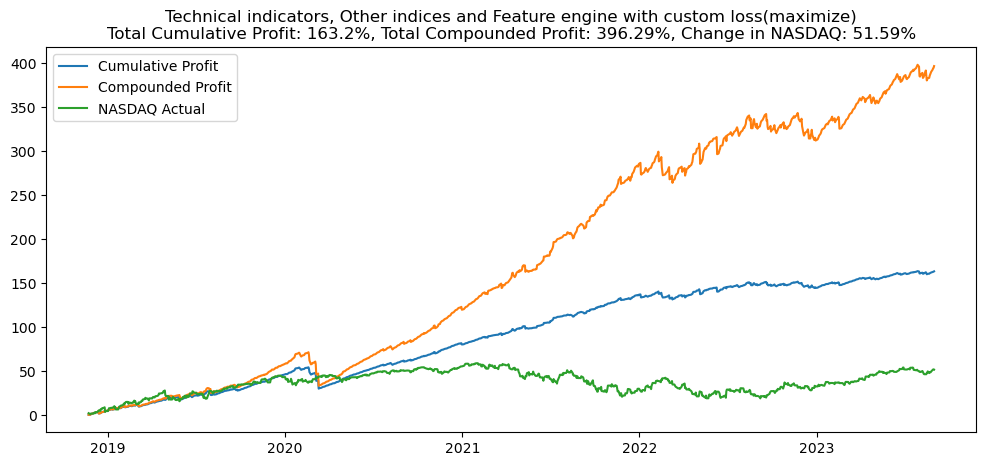

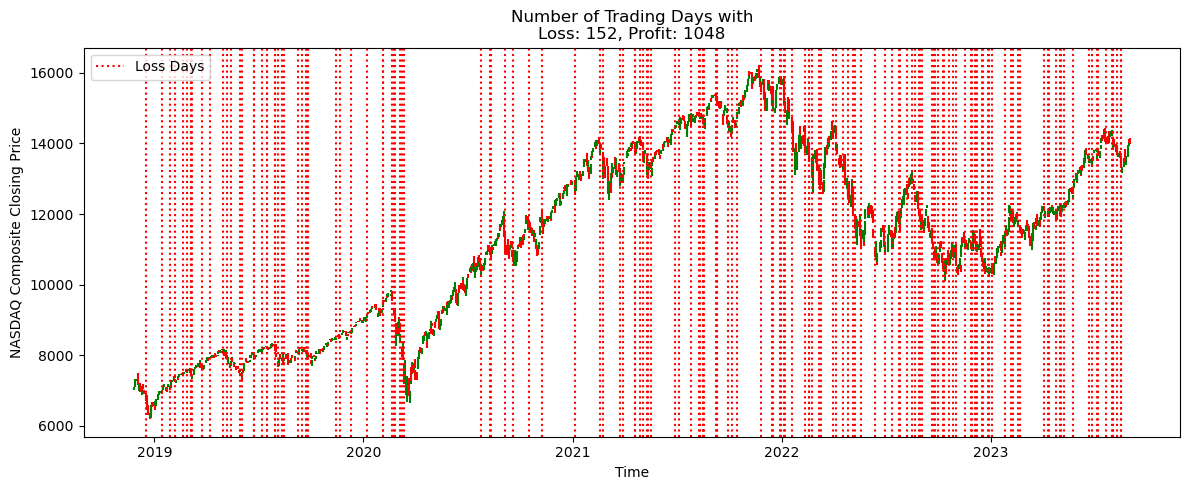

---------------


In [63]:
info = [] #Explanation, Cumulative Profit, Compounded Profit, Nr of Loss Days, Nr of Profit Days

for i in df_results_base.index:
    line = [df_results_base.loc[i, "Explanation"]]
    y_pred = df_results_base.loc[i, "y_pred"]

    total, profitDf = profit(df_NASDAQ_technical, y_pred)
    profitDf["NASDAQ Actual"] = np.cumsum(y_test)
    profitDf[['Cumulative Profit', 'Compounded Profit', 'NASDAQ Actual']].plot(figsize = (12,5))
    plt.title(f'{df_results_base.loc[i, "Explanation"]}\nTotal Cumulative Profit: {round(profitDf["Cumulative Profit"][-1], 2)}%, Total Compounded Profit: {round(profitDf["Compounded Profit"][-1], 2)}%, Change in NASDAQ: {round(profitDf["NASDAQ Actual"][-1], 2)}%')
    line.append(round(profitDf["Cumulative Profit"][-1], 2))
    line.append(round(profitDf["Compounded Profit"][-1], 2))
    plt.show()
    
    loss_arr = loss(df_NASDAQ_technical, y_pred)
    line.append(sum(loss_arr))
    line.append(len(loss_arr) - sum(loss_arr))
    plot_loss_days(df_NASDAQ, loss_arr, "NASDAQ Composite")
    print("-"*15)
    info.append(line)

In [65]:
pd.set_option('display.max_colwidth', None)
df_results_final = pd.DataFrame(info, columns=["Explanation", "Cumulative Profit", "Compounded Profit", "Nr of Loss Days", "Nr of Profit Days"])
df_results_final

Explanation  \
0                                                          Only technical indicators   
1                                             Technical indicators and Other indices   
2                             Technical indicators, Other indices and Feature engine   
3                                         Only technical indicators with custom loss   
4                            Technical indicators and Other indices with custom loss   
5            Technical indicators, Other indices and Feature engine with custom loss   
6                              Only technical indicators with custom loss (maximize)   
7                  Technical indicators and Other indices with custom loss(maximize)   
8  Technical indicators, Other indices and Feature engine with custom loss(maximize)   

   Cumulative Profit  Compounded Profit  Nr of Loss Days  Nr of Profit Days  
0             105.54             181.30               85               1115  
1             151.42             338.41              196               1004  
2             160.95             384.18              171               1029  
3             159.34             382.80               75               1125  
4             155.25             356.11              192               1008  
5             161.84             389.58              154               1046  
6             142.65             308.85               70               1130  
7             194.61             578.39              128               1072  
8             163.20             396.29              152               1048